# Proyecto Aurelion - IA Fundamentals
## IBM - Guayerd 2025



# Spring 4 - Dashboard de resultados en Power BI

Se implementa el dashboard de resultados en Power BI para que refleje los datos de la base de datos de la tienda Aurelion y muestre kpi's y datos relevantes para la tienda .




In [3]:
#Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuraciones generales
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


## Paso 1: Carga de Datos

Importamos los 7 archivos de datos estructurados, proporcionados en formato `.xlsx`.

In [4]:
# Verificar o reemplazar las rutas de los archivos
df_clientes = pd.read_excel("../BD_Aurelion_expanded/clientes_expanded.xlsx")
df_productos = pd.read_excel("../BD_Aurelion_expanded/productos_expanded.xlsx")
df_ventas = pd.read_excel("../BD_Aurelion_expanded/ventas_expanded.xlsx")
df_detalle_ventas = pd.read_excel("../BD_Aurelion_expanded/detalle_ventas_expanded.xlsx")
df_sucursales = pd.read_excel("../BD_Aurelion_expanded/sucursales_expanded.xlsx")
df_vendedores = pd.read_excel("../BD_Aurelion_expanded/vendedores_expanded.xlsx")
df_medios_pago = pd.read_excel("../BD_Aurelion_expanded/medios_pago_expanded.xlsx")

print("Tablas cargadas correctamente.")

Tablas cargadas correctamente.


### Verificación de correspondencia lógica entre tablas
Se verifica que las claves primarias y foráneas entre las tablas coincidan correctamente, asegurando la integridad referencial antes de proceder con la consolidación de datos.

In [5]:
def verificar_correspondencia(df_origen, col_origen, df_destino, col_destino, nombre_origen, nombre_destino):
    """
    Verifica si todos los valores en una columna de un DataFrame existen en
    otra columna de un segundo DataFrame.

    Args:
        df_origen (pd.DataFrame): DataFrame que contiene la columna a verificar.
        col_origen (str): Nombre de la columna en df_origen.
        df_destino (pd.DataFrame): DataFrame que contiene la columna de referencia.
        col_destino (str): Nombre de la columna en df_destino.
        nombre_origen (str): Nombre descriptivo del DataFrame de origen para los mensajes.
        nombre_destino (str): Nombre descriptivo del DataFrame de destino para los mensajes.
    """
    ids_origen = df_origen[col_origen].unique()
    ids_destino = df_destino[col_destino].unique()

    ids_sin_correspondencia = [id_val for id_val in ids_origen if id_val not in ids_destino]

    if ids_sin_correspondencia:
        print(f"Los siguientes {col_origen} en {nombre_origen} no tienen un {col_destino} asociado en {nombre_destino}: {ids_sin_correspondencia}")
    else:
        print(f"Todos los {col_origen} en {nombre_origen} tienen un {col_destino} asociado en {nombre_destino}.")

# Realizar las verificaciones utilizando la función refactorizada
verificar_correspondencia(df_detalle_ventas, 'id_producto', df_productos, 'id_producto', 'df_detalle_ventas', 'df_productos')
verificar_correspondencia(df_detalle_ventas, 'id_venta', df_ventas, 'id_venta', 'df_detalle_ventas', 'df_ventas')
verificar_correspondencia(df_ventas, 'id_cliente', df_clientes, 'id_cliente', 'df_ventas', 'df_clientes')
verificar_correspondencia(df_ventas, 'id_sucursal', df_sucursales, 'id_sucursal', 'df_ventas', 'df_sucursales')
verificar_correspondencia(df_ventas, 'id_vendedor', df_vendedores, 'id_vendedor', 'df_ventas', 'df_vendedores')
verificar_correspondencia(df_ventas, 'id_medio_pago', df_medios_pago, 'id_medio_pago', 'df_ventas', 'df_medios_pago')

Todos los id_producto en df_detalle_ventas tienen un id_producto asociado en df_productos.
Todos los id_venta en df_detalle_ventas tienen un id_venta asociado en df_ventas.
Todos los id_cliente en df_ventas tienen un id_cliente asociado en df_clientes.
Todos los id_sucursal en df_ventas tienen un id_sucursal asociado en df_sucursales.
Todos los id_vendedor en df_ventas tienen un id_vendedor asociado en df_vendedores.
Todos los id_medio_pago en df_ventas tienen un id_medio_pago asociado en df_medios_pago.


## Paso 2: Exploración y Validación Inicial

Revisamos estructura, nulos y tipos de datos para cada DataFrame.


In [6]:
datasets = {
    'clientes': df_clientes,
    'productos': df_productos,
    'ventas': df_ventas,
    'detalle_ventas': df_detalle_ventas,
    'sucursales': df_sucursales,
    'vendedores': df_vendedores,
    'medios_pago': df_medios_pago
}

for name, df in datasets.items():
    print(f"\n--- {name.upper()} ---")
    print(df.info())
    print(df.isnull().sum())


--- CLIENTES ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id_cliente           100 non-null    int64         
 1   nombre_cliente       100 non-null    object        
 2   email                100 non-null    object        
 3   ciudad               100 non-null    object        
 4   fecha_alta           100 non-null    datetime64[ns]
 5   genero               100 non-null    object        
 6   edad_rango           100 non-null    object        
 7   activo_como_cliente  100 non-null    bool          
dtypes: bool(1), datetime64[ns](1), int64(1), object(5)
memory usage: 5.7+ KB
None
id_cliente             0
nombre_cliente         0
email                  0
ciudad                 0
fecha_alta             0
genero                 0
edad_rango             0
activo_como_cliente    0
dtype: int64

--- PRODUCTO

## Paso 3: Limpieza y Conversión de Fechas

Convertimos campos de fecha y revisamos integridad.

In [51]:
df_clientes["fecha_alta"] = pd.to_datetime(df_clientes["fecha_alta"])
df_ventas["fecha"] = pd.to_datetime(df_ventas["fecha"])
df_vendedores["fecha_ingreso"] = pd.to_datetime(df_vendedores["fecha_ingreso"])
print("Fechas convertidas correctamente.")

Fechas convertidas correctamente.


## Paso 4: Unificación de Tablas

Unimos las tablas según claves foráneas para construir un DataFrame maestro `df_master`.

In [73]:
# 1. Unimos detalle con productos
dv_prod = df_detalle_ventas.merge(df_productos, on='id_producto', how='left')

# 2. Unimos con venta (encabezado)
ventas_detalle = dv_prod.merge(df_ventas, on='id_venta', how='left')

# 3. Unimos con clientes
completo_clientes = ventas_detalle.merge(df_clientes, on='id_cliente', how='left')

# 4. Unimos con sucursales
completo_sucursal = completo_clientes.merge(df_sucursales, on='id_sucursal', how='left')

# 5. Unimos con vendedores
completo_vendedor = completo_sucursal.merge(df_vendedores, on='id_vendedor', how='left')

# 6. Unimos con medios de pago
df_master = completo_vendedor.merge(df_medios_pago, on='id_medio_pago', how='left')
# Exportar el DataFrame maestro a un archivo Excel
df_master.to_excel("df_master.xlsx", index=False)

print("Unión de tablas realizada correctamente.")
df_master.head()
#df_master.shape

Unión de tablas realizada correctamente.


,id_venta,id_producto,nombre_producto_x,cantidad,precio_unitario_x,importe,descuento_aplicado_pct,subtotal,nombre_producto_y,categoria,precio_unitario_y,subcategoria,fecha,id_cliente,id_sucursal_x,id_vendedor,id_medio_pago,nombre_cliente_x,email_x,medio_pago_original,estado_venta,monto_bruto,monto_neto,nombre_cliente_y,email_y,ciudad_x,fecha_alta,genero,edad_rango,activo_como_cliente,nombre_sucursal,ciudad_y,provincia,nombre_vendedor,id_sucursal_y,fecha_ingreso,activo,nombre_medio_pago
0,1,90,Toallas Húmedas x50,1,29.02,29.02,0,29.02,Toallas Húmedas x50,Cuidado Personal,29.02,Higiene,2023-01-02,73,5,11,1,Yamila Diaz,yamila.diaz@mail.com,efectivo,OK,29.02,29.02,Yamila Diaz,yamila.diaz@mail.com,Alta Gracia,2023-03-14,F,41-55,True,Tienda Aurelion - Alta Gracia,Alta Gracia,Cordoba,Vendedor 11,5,2022-10-12,True,efectivo
1,2,82,Aceitunas Negras 200g,5,23.94,119.70,0,119.70,Aceitunas Negras 200g,Almacén,23.94,Conservas y Salsas,2023-01-03,74,2,12,3,Zoe Flores,zoe.flores@mail.com,qr,OK,482.98,482.98,Zoe Flores,zoe.flores@mail.com,Carlos Paz,2023-03-15,M,26-40,True,Tienda Aurelion - Río Cuarto,Rio Cuarto,Cordoba,Vendedor 12,2,2023-03-09,True,qr
2,2,39,Helado Vainilla 1L,5,4.69,23.45,0,23.45,Helado Vainilla 1L,Congelados,4.69,Postres Helados,2023-01-03,74,2,12,3,Zoe Flores,zoe.flores@mail.com,qr,OK,482.98,482.98,Zoe Flores,zoe.flores@mail.com,Carlos Paz,2023-03-15,M,26-40,True,Tienda Aurelion - Río Cuarto,Rio Cuarto,Cordoba,Vendedor 12,2,2023-03-09,True,qr
3,2,70,Fernet 750ml,2,40.61,81.22,0,81.22,Fernet 750ml,Bebidas Alcohólicas,40.61,Destilados,2023-01-03,74,2,12,3,Zoe Flores,zoe.flores@mail.com,qr,OK,482.98,482.98,Zoe Flores,zoe.flores@mail.com,Carlos Paz,2023-03-15,M,26-40,True,Tienda Aurelion - Río Cuarto,Rio Cuarto,Cordoba,Vendedor 12,2,2023-03-09,True,qr
4,2,22,Medialunas de Manteca,1,20.69,20.69,0,20.69,Medialunas de Manteca,Panadería y Repostería,20.69,Facturas,2023-01-03,74,2,12,3,Zoe Flores,zoe.flores@mail.com,qr,OK,482.98,482.98,Zoe Flores,zoe.flores@mail.com,Carlos Paz,2023-03-15,M,26-40,True,Tienda Aurelion - Río Cuarto,Rio Cuarto,Cordoba,Vendedor 12,2,2023-03-09,True,qr


## Paso 5: Ingeniería de Características

Creamos columnas adicionales como año, mes, día de la semana, y monto final con descuentos.

In [74]:
df_master["año"] = df_master["fecha"].dt.year
df_master["mes"] = df_master["fecha"].dt.month
df_master["dia_nombre"] = df_master["fecha"].dt.day_name()
# Corregimos el cálculo del descuento_pct dividiendo por 100
df_master["descuento_pct"] = df_master["descuento_aplicado_pct"].fillna(0) / 100
df_master["monto_final"] = df_master["subtotal"] - (df_master["subtotal"] * df_master["descuento_pct"])

print("Columnas nuevas generadas.")
display(df_master[['fecha', 'año', 'mes', 'dia_nombre', 'descuento_aplicado_pct', 'descuento_pct', 'subtotal', 'monto_final']].head())

Columnas nuevas generadas.


,fecha,año,mes,dia_nombre,descuento_aplicado_pct,descuento_pct,subtotal,monto_final
0,2023-01-02,2023,1,Monday,0,0.0,29.02,29.02
1,2023-01-03,2023,1,Tuesday,0,0.0,119.70,119.70
2,2023-01-03,2023,1,Tuesday,0,0.0,23.45,23.45
3,2023-01-03,2023,1,Tuesday,0,0.0,81.22,81.22
4,2023-01-03,2023,1,Tuesday,0,0.0,20.69,20.69


## Paso 6: Análisis de Métricas Relevantes

A continuación realizamos distintos análisis para responder preguntas clave del negocio.

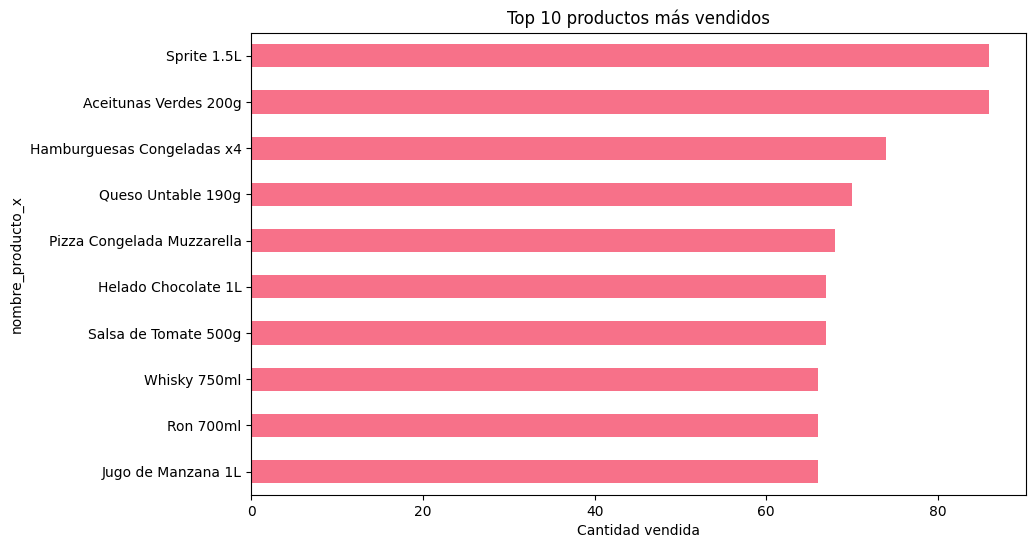

,id_producto,nombre_producto,cantidad,ranking,porcentaje_top10,porcentaje_total_ventas
0,3,Sprite 1.5L,86,1,12.01,1.59
1,81,Aceitunas Verdes 200g,86,1,12.01,1.59
2,79,Hamburguesas Congeladas x4,74,2,10.34,1.37
3,83,Queso Untable 190g,70,3,9.78,1.30
4,76,Pizza Congelada Muzzarella,68,4,9.50,1.26
5,40,Helado Chocolate 1L,67,5,9.36,1.24
6,43,Salsa de Tomate 500g,67,5,9.36,1.24
7,74,Whisky 750ml,66,6,9.22,1.22
8,72,Ron 700ml,66,6,9.22,1.22
9,7,Jugo de Manzana 1L,66,6,9.22,1.22


In [117]:
#Productos más vendidos
# Agrupamos por nombre o por id_producto y sumamos las cantidades
top_productos = df_master.groupby(["id_producto", "nombre_producto_x"])["cantidad"].sum().sort_values(ascending=False).head(10)

# Convertimos a DataFrame
top_productos_df = top_productos.reset_index()
top_productos_df.rename(columns={'nombre_producto_x': 'nombre_producto'}, inplace=True)

# Generamos la gráfica
top_productos.plot(kind="barh", title="Top 10 productos más vendidos", figsize=(10,6))
plt.xlabel("Cantidad vendida")
#Ruta para guardar la gráfica
plt.gca().invert_yaxis()
plt.savefig("imgs_analisis_statistic/top_10_productos_mas_vendidos.png")
plt.show()


# Total del Top 10
total_top10 = top_productos_df["cantidad"].sum()

# Total global de productos vendidos
total_global = df_master["cantidad"].sum()

# Calcular ranking, % dentro del top10 y % global
top_productos_df["ranking"] = top_productos_df["cantidad"].rank(method="dense", ascending=False).astype(int)
top_productos_df["porcentaje_top10"] = (top_productos_df["cantidad"] / total_top10 * 100).round(2)
top_productos_df["porcentaje_total_ventas"] = (top_productos_df["cantidad"] / total_global * 100).round(2)

# Ordenamos por ranking
top_productos_df = top_productos_df.sort_values(by="ranking")

# Guardar en Excel
top_productos_df.to_excel("reports_dframes/top_productos_pBI.xlsx", index=False)
top_productos_df


#for id_producto, cantidad in top_productos.items():
#    nombre_producto = productos_dict.get(id_producto, "Desconocido")
#    print(f"{id_producto} - {nombre_producto} - {cantidad}")

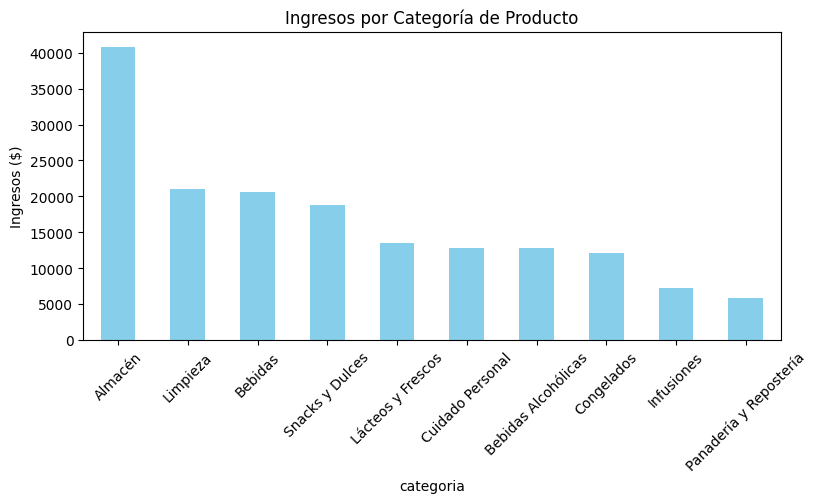

,categoria,ingresos,ranking,porcentaje_total
0,Almacén,40878.35,1,24.71
1,Limpieza,20976.04,2,12.68
2,Bebidas,20594.92,3,12.45
3,Snacks y Dulces,18841.19,4,11.39
4,Lácteos y Frescos,13467.79,5,8.14
5,Cuidado Personal,12769.39,6,7.72
6,Bebidas Alcohólicas,12767.25,7,7.72
7,Congelados,12083.05,8,7.30
8,Infusiones,7260.74,9,4.39
9,Panadería y Repostería,5801.45,10,3.51


In [139]:
#Ingresos por categoría
ingresos_categoria = df_master.groupby("categoria")["monto_final"].sum().sort_values(ascending=False)
ingresos_categoria.plot(kind="bar", title="Ingresos por Categoría de Producto", figsize=(9,4), color='skyblue')
plt.ylabel("Ingresos ($)")
plt.xticks(rotation=45)
plt.savefig("imgs_analisis_statistic/ingresos_por_categoria.png")
plt.show()

# Guardar en un df y exportar a excel para reporte en PowerBI

# Convertir la serie en dataframe
df_ingresos_categoria = (ingresos_categoria).reset_index()
# Renombrar columnas
df_ingresos_categoria.columns = ["categoria", ("ingresos")]
# Agregar ranking y porcentaje sobre el total
# Redondear a 2 decimales
df_ingresos_categoria["ranking"] = df_ingresos_categoria["ingresos"].rank(ascending=False).astype(int)
df_ingresos_categoria["porcentaje_total"] = (
    df_ingresos_categoria["ingresos"] / df_ingresos_categoria["ingresos"].sum() * 100
).round(2)

# Orden final por ranking
df_ingresos_categoria = df_ingresos_categoria.sort_values("ranking").reset_index(drop=True)

# Guardar en excel
df_ingresos_categoria.to_excel("reports_dframes/ingresos_por_categoria_pBI.xlsx", index=False)

df_ingresos_categoria.round(2)


#print("Ingresos por categoría:")
#for categoria, monto in ingresos_categoria.items():
#    print(f"{categoria} - ${monto:,.2f}")

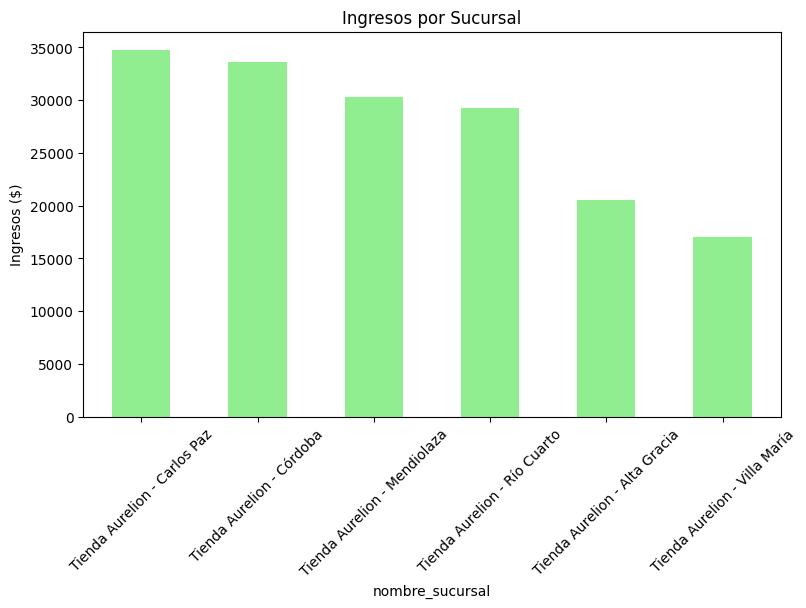

,sucursal,ingresos,ranking,porcentaje_total
0,Tienda Aurelion - Carlos Paz,34760.12,1,21.01
1,Tienda Aurelion - Córdoba,33618.05,2,20.32
2,Tienda Aurelion - Mendiolaza,30282.02,3,18.30
3,Tienda Aurelion - Río Cuarto,29223.06,4,17.66
4,Tienda Aurelion - Alta Gracia,20491.82,5,12.39
5,Tienda Aurelion - Villa María,17065.11,6,10.31


In [140]:
#Ingresos por sucursal
ingresos_sucursal = df_master.groupby("nombre_sucursal")["monto_final"].sum().sort_values(ascending=False)
ingresos_sucursal.plot(kind="bar", title="Ingresos por Sucursal", figsize=(9,5), color='lightgreen')
plt.ylabel("Ingresos ($)")
plt.xticks(rotation=45)
plt.savefig("imgs_analisis_statistic/ingresos_por_sucursal.png")
plt.show()

# Convertir la serie en DataFrame
df_ingresos_sucursal = ingresos_sucursal.reset_index()

# Renombrar columnas
df_ingresos_sucursal.columns = ["sucursal", "ingresos"]

# Agregar ranking y porcentaje del total
df_ingresos_sucursal["ranking"] = df_ingresos_sucursal["ingresos"].rank(ascending=False).astype(int)
df_ingresos_sucursal["porcentaje_total"] = (
    df_ingresos_sucursal["ingresos"] / df_ingresos_sucursal["ingresos"].sum() * 100
).round(2)

# Ordenar por ranking
df_ingresos_sucursal = df_ingresos_sucursal.sort_values("ranking").reset_index(drop=True)

# Guardar el DataFrame en un archivo Excel
df_ingresos_sucursal.to_excel("reports_dframes/ingresos_por_sucursal_pBI.xlsx", index=False)

df_ingresos_sucursal.round(2)

#print("Ingresos por sucursal:")
#or sucursal, monto in ingresos_sucursal.items():
#    print(f"{sucursal} - ${monto:,.2f}")

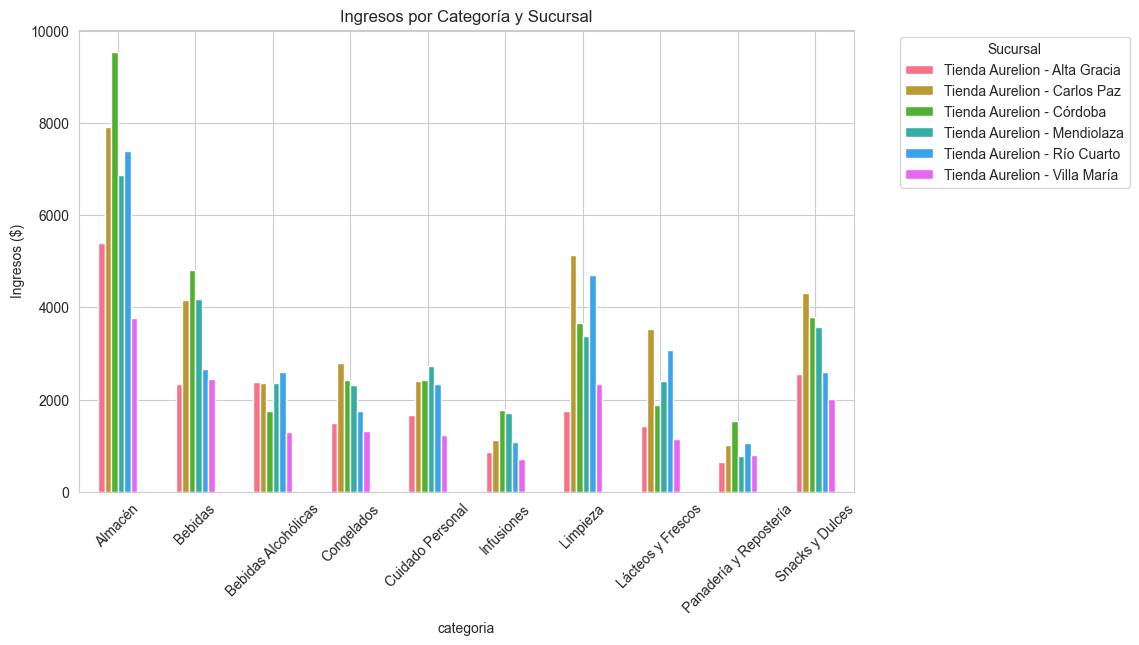

,categoria,sucursal,ingresos,ranking_por_sucursal,porcentaje_en_sucursal
0,Almacén,Tienda Aurelion - Alta Gracia,5395.62,1,26.33
1,Bebidas,Tienda Aurelion - Alta Gracia,2328.03,4,11.36
2,Bebidas Alcohólicas,Tienda Aurelion - Alta Gracia,2372.49,3,11.58
3,Congelados,Tienda Aurelion - Alta Gracia,1496.04,7,7.30
4,Cuidado Personal,Tienda Aurelion - Alta Gracia,1656.19,6,8.08


In [164]:
#Ingresos por categoría y sucursal
ingresos_categoria_sucursal = df_master.groupby(["categoria", "nombre_sucursal"])["monto_final"].sum().unstack()
ingresos_categoria_sucursal.plot(kind="bar", title="Ingresos por Categoría y Sucursal", figsize=(10,6))
plt.ylabel("Ingresos ($)")
plt.xticks(rotation=45)
plt.legend(title="Sucursal", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("imgs_analisis_statistic/ingresos_por_categoria_y_sucursal.png")
plt.show()


# Convertimos la tabla pivote en formato largo
df_categoria_sucursal = ingresos_categoria_sucursal.reset_index().melt(
    id_vars="categoria",
    var_name="sucursal",
    value_name="ingresos"
)
# Eliminamos valores nulos (categorías no vendidas en ciertas sucursales)
df_categoria_sucursal = df_categoria_sucursal.dropna()
# Ranking por categoría dentro de cada sucursal
df_categoria_sucursal["ranking_por_sucursal"] = df_categoria_sucursal.groupby("sucursal")["ingresos"] \
    .rank(ascending=False).astype(int)

# Porcentaje por sucursal (cuánto representa la categoría del total de esa sucursal)
df_categoria_sucursal["porcentaje_en_sucursal"] = (
    df_categoria_sucursal.groupby("sucursal")["ingresos"]
    .apply(lambda x: x / x.sum() * 100)
).round(2).reset_index(drop=True)

# Guardamos el DataFrame en un archivo Excel
df_categoria_sucursal.to_excel("df_categoria_sucursal_pBI.xlsx", index=False)
df_categoria_sucursal.head().round(2)

#print("Ingresos por categoría y sucursal:")
#for categoria, sucursales in ingresos_categoria_sucursal.iterrows():
#    for sucursal, monto in sucursales.items():
#        print(f"{categoria} - {sucursal} - ${monto:,.2f}")

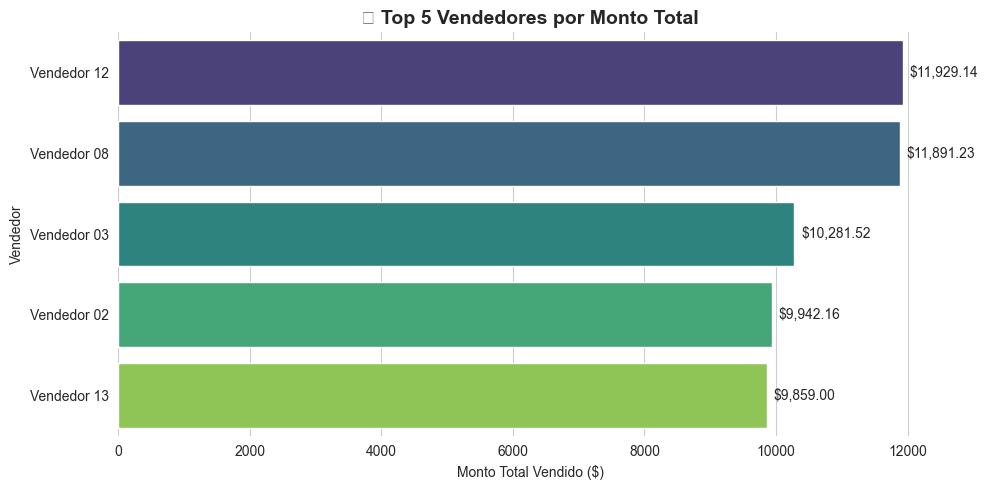

,nombre_vendedor,nombre_sucursal,monto_total,ranking_global,ranking_sucursal,porcentaje_total,porcentaje_sucursal
11,Vendedor 12,Tienda Aurelion - Río Cuarto,11929.13790,1,1,7.21,40.82
7,Vendedor 08,Tienda Aurelion - Carlos Paz,11891.22770,2,1,7.19,34.21
2,Vendedor 03,Tienda Aurelion - Río Cuarto,10281.51695,3,2,6.21,35.18
1,Vendedor 02,Tienda Aurelion - Mendiolaza,9942.16370,4,1,6.01,32.83
12,Vendedor 13,Tienda Aurelion - Córdoba,9859.00065,5,1,5.96,29.33


In [177]:
# Top 5 vendedores por monto final
top_vendedores = df_master.groupby("nombre_vendedor")["monto_final"].sum().sort_values(ascending=False).head(5)

plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
ax = sns.barplot(x=top_vendedores.values, y=top_vendedores.index, palette="viridis")

# Título
plt.title("🏆 Top 5 Vendedores por Monto Total", fontsize=14, weight='bold')
plt.xlabel("Monto Total Vendido ($)")
plt.ylabel("Vendedor")

# Etiquetas de valor en las barras
for i, value in enumerate(top_vendedores.values):
    ax.text(value + 100, i, f"${value:,.2f}", va='center', fontsize=10)

sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.savefig("imgs_analisis_statistic/top_5_vendedores.png", dpi=300)
plt.show()

# Agrupación por vendedor y sucursal
df_vendedores = df_master.groupby(["nombre_vendedor", "nombre_sucursal"])["monto_final"].sum().reset_index()
df_vendedores.rename(columns={"monto_final": "monto_total"}, inplace=True)
# Ranking global (todas las sucursales)
df_vendedores["ranking_global"] = df_vendedores["monto_total"].rank(ascending=False).astype(int)
# Ranking dentro de cada sucursal
df_vendedores["ranking_sucursal"] = df_vendedores.groupby("nombre_sucursal")["monto_total"].rank(ascending=False).astype(int)
# Porcentajes
total_ventas = df_master["monto_final"].sum()
df_vendedores["porcentaje_total"] = (df_vendedores["monto_total"] / total_ventas * 100).round(2)
# Porcentaje dentro de la sucursal
ventas_por_sucursal = df_master.groupby("nombre_sucursal")["monto_final"].sum().to_dict()
df_vendedores["porcentaje_sucursal"] = df_vendedores.apply(
    lambda row: round((row["monto_total"] / ventas_por_sucursal[row["nombre_sucursal"]] * 100), 2), axis=1
)
# Orden final sugerido
df_vendedores = df_vendedores[
    [
        "nombre_vendedor", 
        "nombre_sucursal", 
        "monto_total", 
        "ranking_global", 
        "ranking_sucursal", 
        "porcentaje_total",
        "porcentaje_sucursal"
    ]
]
# Guardar para Power BI
df_vendedores.to_excel("reports_dframes/top_vendedores_pBI.xlsx", index=False)
# Mostrar los 5 mejores vendedores
df_vendedores.sort_values(by="ranking_global", ascending=True).head(5)




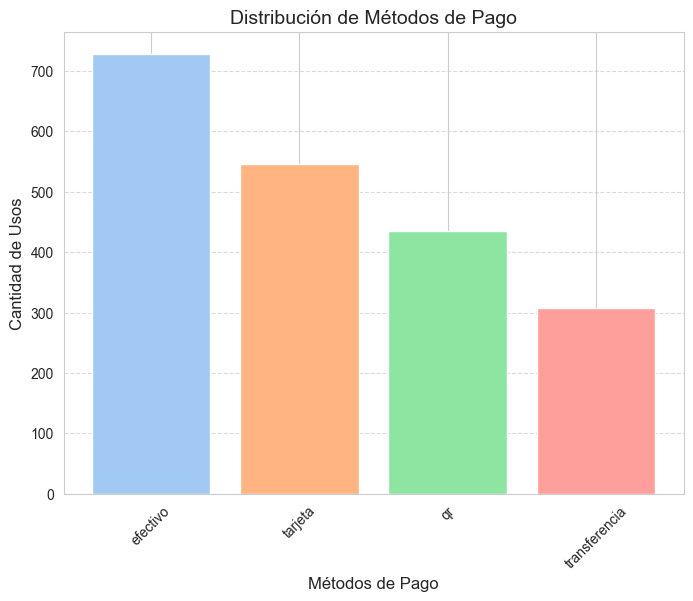

,nombre_sucursal,nombre_medio_pago,cantidad_ventas
0,Tienda Aurelion - Alta Gracia,efectivo,90
1,Tienda Aurelion - Alta Gracia,qr,64
2,Tienda Aurelion - Alta Gracia,tarjeta,68
3,Tienda Aurelion - Alta Gracia,transferencia,36
4,Tienda Aurelion - Carlos Paz,efectivo,161


In [193]:
# Distribución general de métodos de pago
metodos = df_master["nombre_medio_pago"].value_counts()
plt.figure(figsize=(8,6))
colors = sns.color_palette("pastel")
plt.bar(metodos.index, metodos.values, color=colors)
plt.title("Distribución de Métodos de Pago", fontsize=14)
plt.xlabel("Métodos de Pago", fontsize=12)
plt.ylabel("Cantidad de Usos", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("imgs_analisis_statistic/distribucion_metodos_pago_general.png")
plt.show()

# Tabla con métodos de pago por sucursal
metodos_por_sucursal = df_master.groupby(
    ["nombre_sucursal", "nombre_medio_pago"]
).size().reset_index(name="cantidad_ventas")

metodos_por_sucursal.to_excel("reports_dframes/metodos_pago_pBI.xlsx", index=False)

metodos_por_sucursal.head()


## Conclusión Spring 1

Este análisis permitió consolidar múltiples fuentes de datos en un solo reporte integral. Se identificaron productos clave, vendedores destacados, diferencias entre sucursales y comportamiento de clientes frente a medios de pago.

Además, se logró:

- **Unificación de datos**: Integrar información de diversas tablas para obtener una vista completa del negocio.
- **Análisis detallado**: Identificar patrones de ventas, ingresos por categoría y sucursal, y métodos de pago preferidos.
- **Visualización efectiva**: Utilizar gráficos claros para comunicar hallazgos clave.

Estos resultados son fundamentales para tomar decisiones estratégicas basadas en datos y optimizar procesos internos. El siguiente paso será profundizar en el análisis predictivo y explorar nuevas oportunidades de crecimiento.

## Reflexiones y Próximos Pasos

El análisis realizado en este notebook nos brinda una perspectiva integral sobre las ventas y el comportamiento de los clientes. Sin embargo, siempre hay espacio para mejorar:

- **Profundizar en el análisis predictivo**: Utilizar modelos de machine learning para anticipar tendencias de ventas y comportamiento de clientes.
- **Segmentación avanzada**: Identificar grupos de clientes con características similares para personalizar estrategias de marketing.
- **Optimización de inventarios**: Analizar patrones de ventas para mejorar la gestión de stock y reducir costos.
- **Visualizaciones interactivas**: Implementar dashboards dinámicos que permitan explorar los datos de manera más intuitiva.

Estos pasos no solo fortalecerán la toma de decisiones, sino que también abrirán nuevas oportunidades para el crecimiento del negocio.

# Proyecto Tienda Aurelion SPRING 2
# Desarrollo de aplicación de técnicas estadisticas:
  1. Base de datos limpia y lista
  2. Calcular estadísticas básicas calculadas
  3. Identificar tipo de distribución de variables
  4. Análisis de correlaciones entre variables principales
  5. Detección deoutliers mediante curatiles y rangos
  6. Interpretar resultados para el problema de negocio
  7. Documentar


## 1: Base de datos limpia y lista
### Caracterización inicial del DataFrame `df_master`

En esta fase, realizaremos una caracterización inicial del DataFrame `df_master`, que es la unificación de las 7 tablas de la base de datos extendida, para comprender su estructura y contenido. Utilizaremos métodos de pandas para obtener estadísticas descriptivas y visualizaciones para entender la distribución de las variables numéricas.

## Información general del DataFrame


### Visualización de las primeras filas del DataFrame

In [194]:
# Mostrar las primeras filas del DataFrame df_master
print("Primeras 5 filas del DataFrame df_master:")
display(df_master.head())

Primeras 5 filas del DataFrame df_master:


,id_venta,id_producto,nombre_producto_x,cantidad,precio_unitario_x,importe,descuento_aplicado_pct,subtotal,nombre_producto_y,categoria,precio_unitario_y,subcategoria,fecha,id_cliente,id_sucursal_x,id_vendedor,id_medio_pago,nombre_cliente_x,email_x,medio_pago_original,estado_venta,monto_bruto,monto_neto,nombre_cliente_y,email_y,ciudad_x,fecha_alta,genero,edad_rango,activo_como_cliente,nombre_sucursal,ciudad_y,provincia,nombre_vendedor,id_sucursal_y,fecha_ingreso,activo,nombre_medio_pago,año,mes,dia_nombre,descuento_pct,monto_final
0,1,90,Toallas Húmedas x50,1,29.02,29.02,0,29.02,Toallas Húmedas x50,Cuidado Personal,29.02,Higiene,2023-01-02,73,5,11,1,Yamila Diaz,yamila.diaz@mail.com,efectivo,OK,29.02,29.02,Yamila Diaz,yamila.diaz@mail.com,Alta Gracia,2023-03-14,F,41-55,True,Tienda Aurelion - Alta Gracia,Alta Gracia,Cordoba,Vendedor 11,5,2022-10-12,True,efectivo,2023,1,Monday,0.0,29.02
1,2,82,Aceitunas Negras 200g,5,23.94,119.70,0,119.70,Aceitunas Negras 200g,Almacén,23.94,Conservas y Salsas,2023-01-03,74,2,12,3,Zoe Flores,zoe.flores@mail.com,qr,OK,482.98,482.98,Zoe Flores,zoe.flores@mail.com,Carlos Paz,2023-03-15,M,26-40,True,Tienda Aurelion - Río Cuarto,Rio Cuarto,Cordoba,Vendedor 12,2,2023-03-09,True,qr,2023,1,Tuesday,0.0,119.70
2,2,39,Helado Vainilla 1L,5,4.69,23.45,0,23.45,Helado Vainilla 1L,Congelados,4.69,Postres Helados,2023-01-03,74,2,12,3,Zoe Flores,zoe.flores@mail.com,qr,OK,482.98,482.98,Zoe Flores,zoe.flores@mail.com,Carlos Paz,2023-03-15,M,26-40,True,Tienda Aurelion - Río Cuarto,Rio Cuarto,Cordoba,Vendedor 12,2,2023-03-09,True,qr,2023,1,Tuesday,0.0,23.45
3,2,70,Fernet 750ml,2,40.61,81.22,0,81.22,Fernet 750ml,Bebidas Alcohólicas,40.61,Destilados,2023-01-03,74,2,12,3,Zoe Flores,zoe.flores@mail.com,qr,OK,482.98,482.98,Zoe Flores,zoe.flores@mail.com,Carlos Paz,2023-03-15,M,26-40,True,Tienda Aurelion - Río Cuarto,Rio Cuarto,Cordoba,Vendedor 12,2,2023-03-09,True,qr,2023,1,Tuesday,0.0,81.22
4,2,22,Medialunas de Manteca,1,20.69,20.69,0,20.69,Medialunas de Manteca,Panadería y Repostería,20.69,Facturas,2023-01-03,74,2,12,3,Zoe Flores,zoe.flores@mail.com,qr,OK,482.98,482.98,Zoe Flores,zoe.flores@mail.com,Carlos Paz,2023-03-15,M,26-40,True,Tienda Aurelion - Río Cuarto,Rio Cuarto,Cordoba,Vendedor 12,2,2023-03-09,True,qr,2023,1,Tuesday,0.0,20.69


## Verificación de tipos de datos

Utilizaremos el método `.info()` para obtener un resumen de los tipos de datos de cada columna en el DataFrame `df_master`.

In [195]:
# Proporcionar una vista compacta de la estructura interna del DataFrame
print("\nInformación general sobre los tipos de datos del DataFrame df_master:")
df_master.info()


Información general sobre los tipos de datos del DataFrame df_master:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id_venta                2016 non-null   int64         
 1   id_producto             2016 non-null   int64         
 2   nombre_producto_x       2016 non-null   object        
 3   cantidad                2016 non-null   int64         
 4   precio_unitario_x       2016 non-null   float64       
 5   importe                 2016 non-null   float64       
 6   descuento_aplicado_pct  2016 non-null   int64         
 7   subtotal                2016 non-null   float64       
 8   nombre_producto_y       2016 non-null   object        
 9   categoria               2016 non-null   object        
 10  precio_unitario_y       2016 non-null   float64       
 11  subcategoria            2016 non-null

### Verificación de la conversión de fechas en `df_master`

Confirmaremos que las columnas de fecha (`fecha_alta`, `fecha`, `fecha_ingreso`) tienen el tipo de dato `datetime64[ns]`.

In [197]:
# Mostrar los tipos de datos específicos de las columnas de fecha
print("\nTipos de datos de las columnas de fecha:")
print(df_master[['fecha_alta', 'fecha', 'fecha_ingreso']].dtypes)


Tipos de datos de las columnas de fecha:
fecha_alta       datetime64[ns]
fecha            datetime64[ns]
fecha_ingreso    datetime64[ns]
dtype: object


## Verificación de datos Completos

Según los criterios del Anexo, los datos esenciales no deben estar nulos o incompletos. En esta sección, verificaremos la presencia de valores nulos en el DataFrame `df_master` para asegurar que no faltan datos esenciales para el análisis.



### Verificación de valores nulos

Utilizaremos el método `.isnull().sum()` para contar el número de valores nulos por columna en el DataFrame `df_master`.

In [198]:
# Verificar valores nulos en cada columna de df_master
print("Número de valores nulos por columna en df_master:")
display(df_master.isnull().sum())

Número de valores nulos por columna en df_master:


id_venta                  0
id_producto               0
nombre_producto_x         0
cantidad                  0
precio_unitario_x         0
importe                   0
descuento_aplicado_pct    0
subtotal                  0
nombre_producto_y         0
categoria                 0
precio_unitario_y         0
subcategoria              0
fecha                     0
id_cliente                0
id_sucursal_x             0
id_vendedor               0
id_medio_pago             0
nombre_cliente_x          0
email_x                   0
medio_pago_original       0
estado_venta              0
monto_bruto               0
monto_neto                0
nombre_cliente_y          0
email_y                   0
ciudad_x                  0
fecha_alta                0
genero                    0
edad_rango                0
activo_como_cliente       0
nombre_sucursal           0
ciudad_y                  0
provincia                 0
nombre_vendedor           0
id_sucursal_y             0
fecha_ingreso       

### 2: Calcular estadísticas básicas calculadas

En esta fase, realizaremos cálculos de estadísticas descriptivas para las variables numéricas clave en `df_master` para comprender su distribución y características centrales.

In [199]:
# Mostrar un resumen estadístico de las variables numéricas del DataFrame
print("\nResumen estadístico de las variables numéricas de df_master:")
display(df_master.describe())


Resumen estadístico de las variables numéricas de df_master:


,id_venta,id_producto,cantidad,precio_unitario_x,importe,descuento_aplicado_pct,subtotal,precio_unitario_y,fecha,id_cliente,id_sucursal_x,id_vendedor,id_medio_pago,monto_bruto,monto_neto,fecha_alta,id_sucursal_y,fecha_ingreso,año,mes,descuento_pct,monto_final
count,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016,2016.000000,2016,2016.000000,2016.000000,2016.000000,2016.000000
mean,346.531250,50.322421,2.675595,31.447951,83.859435,1.173115,82.917202,31.447951,2023-10-21 22:18:34.285714432,49.303075,3.310020,10.443452,2.160218,279.660109,279.660109,2023-02-18 07:16:25.714285824,3.310020,2022-12-21 23:32:08.571428352,2023.407242,5.295139,0.011731,82.063579
min,1.000000,1.000000,1.000000,2.720000,2.720000,0.000000,2.720000,2.720000,2023-01-02 00:00:00,1.000000,1.000000,1.000000,1.000000,2.720000,2.720000,2023-01-01 00:00:00,1.000000,2022-04-06 00:00:00,2023.000000,1.000000,0.000000,2.720000
25%,153.000000,25.000000,2.000000,20.690000,40.397500,0.000000,39.620000,20.690000,2023-06-03 00:00:00,25.000000,2.000000,6.000000,1.000000,170.800000,170.800000,2023-01-25 00:00:00,2.000000,2022-06-09 00:00:00,2023.000000,3.000000,0.000000,39.060000
50%,344.500000,49.500000,3.000000,32.040000,76.395000,0.000000,74.310000,32.040000,2023-11-09 00:00:00,46.000000,3.000000,10.000000,2.000000,261.700000,261.700000,2023-02-15 00:00:00,3.000000,2023-01-23 00:00:00,2023.000000,5.000000,0.000000,73.080000
75%,534.000000,76.000000,4.000000,42.860000,121.440000,0.000000,120.560000,42.860000,2024-03-14 00:00:00,75.000000,5.000000,15.000000,3.000000,375.720000,375.720000,2023-03-16 00:00:00,5.000000,2023-07-13 00:00:00,2024.000000,7.000000,0.000000,119.037500
max,720.000000,100.000000,5.000000,49.820000,249.100000,15.000000,248.650000,49.820000,2024-06-28 00:00:00,100.000000,6.000000,20.000000,4.000000,786.510000,786.510000,2023-04-10 00:00:00,6.000000,2023-10-28 00:00:00,2024.000000,12.000000,0.150000,248.650000
std,212.057682,29.104692,1.256218,12.825875,54.423370,3.098914,54.022666,12.825875,NaN,29.916773,1.808614,5.583721,1.078380,146.116374,146.116374,NaN,1.808614,NaN,0.491443,3.270546,0.030989,53.797310


### Visualización de la distribución de variables numéricas

A continuación, generaremos histogramas para visualizar la distribución de algunas variables numéricas clave en `df_master`.

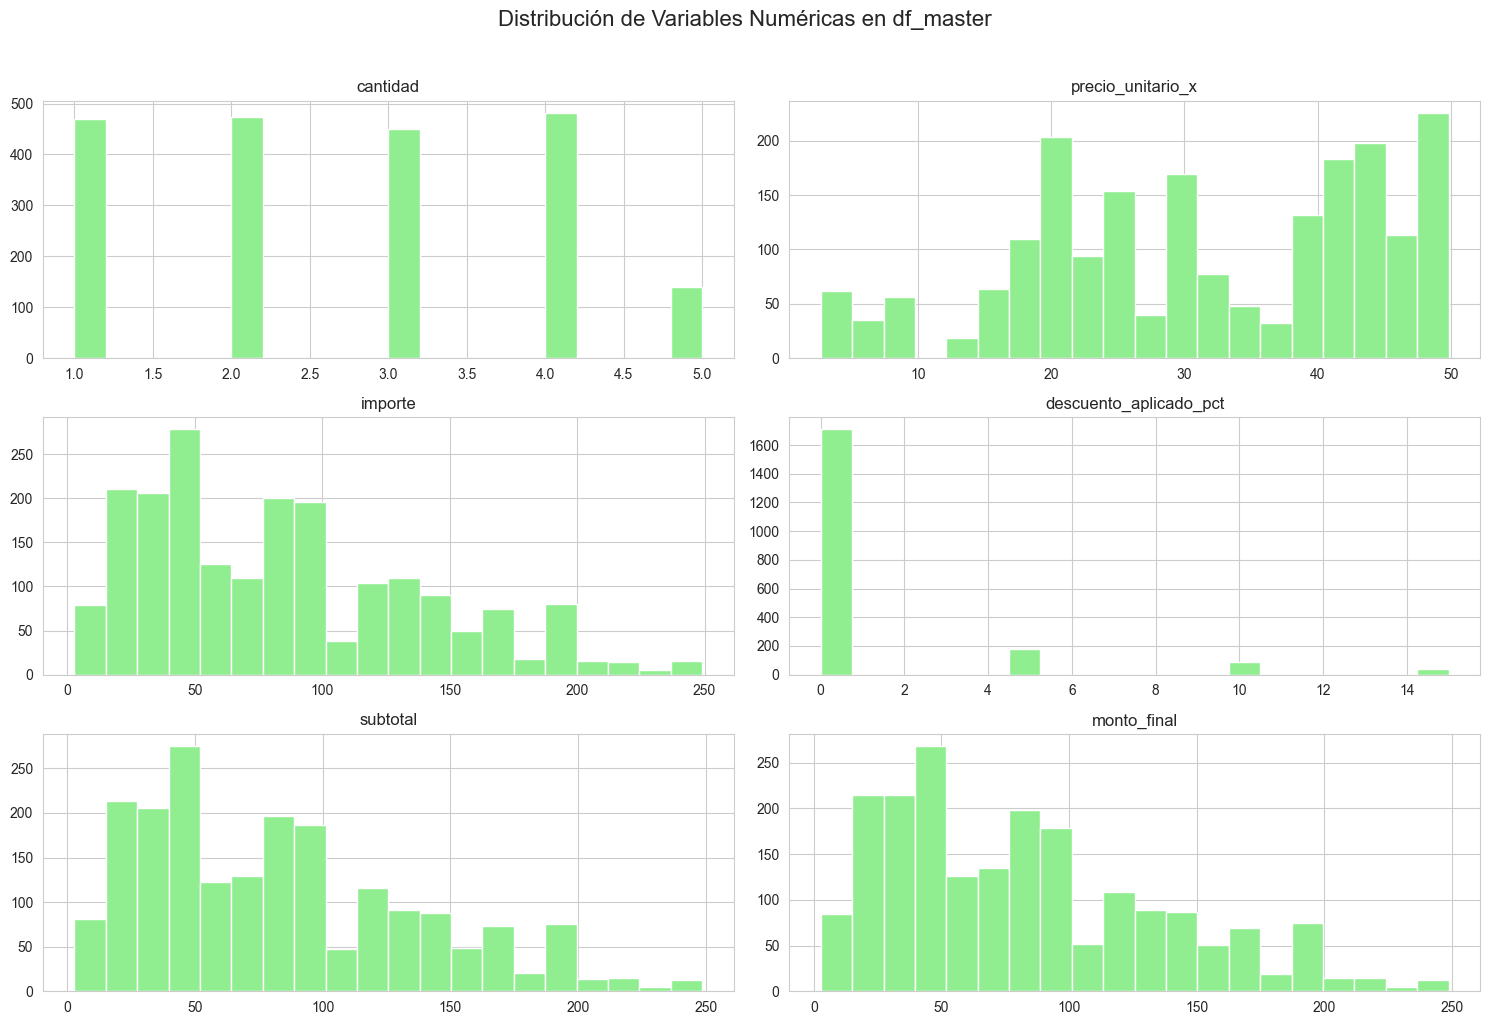

In [207]:
# Seleccionar columnas numéricas para visualización de distribución
numerical_cols_viz = ['cantidad', 'precio_unitario_x', 'importe', 'descuento_aplicado_pct', 'subtotal', 'monto_final']

# Crear histogramas para cada columna numérica seleccionada
df_master[numerical_cols_viz].hist(bins=20, figsize=(15, 10), color='LightGreen')
plt.suptitle("Distribución de Variables Numéricas en df_master", y=1.02, fontsize=16)
plt.tight_layout()
plt.savefig("imgs_analisis_statistic/distribucion_variables_numericas.png")
plt.show()


Los histogramas generados nos proporcionan una visión gráfica de cómo se distribuyen los valores en las variables numéricas clave de nuestro DataFrame `df_master`, lo que nos ayuda comprender su distribución y características centrales:



### Resumen estadístico de las variables numéricas

Calcularemos y mostraremos un resumen estadístico de las variables numéricas relevantes en el DataFrame.

| Estadístico | cantidad | precio_unitario_x | importe | descuento_aplicado_pct | subtotal | monto_bruto | monto_neto | monto_final |
|---|---|---|---|---|---|---|---|---|
| count | 2016 | 2016.00 | 2016.00 | 2016.00 | 2016.00 | 2016.00 | 2016.00 | 2016.00 |
| mean | 2.68 | 31.45 | 83.86 | 1.17 | 82.92 | 279.66 | 279.66 | 82.06 |
| std | 1.26 | 12.83 | 54.42 | 3.10 | 54.02 | 146.12 | 146.12 | 53.80 |
| min | 1.00 | 2.72 | 2.72 | 0.00 | 2.72 | 2.72 | 2.72 | 2.72 |
| 25% | 2.00 | 20.69 | 40.40 | 0.00 | 39.62 | 170.80 | 170.80 | 39.06 |
| 50% | 3.00 | 32.04 | 76.40 | 0.00 | 74.31 | 261.70 | 261.70 | 73.08 |
| 75% | 4.00 | 42.86 | 121.44 | 0.00 | 120.56 | 375.72 | 375.72 | 119.04 |
| max | 5.00 | 49.82 | 249.10 | 15.00 | 248.65 | 786.51 | 786.51 | 248.65 |

### Interpretación de las Estadísticas Descriptivas de Variables Numéricas

Las estadísticas descriptivas para las variables numéricas clave en `df_master` nos proporcionan un resumen cuantitativo de su distribución y características centrales:

*   **`cantidad`**:
    *   **count (2016)**: Hay 2016 registros de cantidad de productos por detalle de venta.
    *   **mean (2.68)**: En promedio, se venden aproximadamente 2.68 unidades por detalle de venta.
    *   **std (1.26)**: La desviación estándar es de 1.26, lo que indica una dispersión moderada alrededor de la media.
    *   **min (1.00)**: La cantidad mínima vendida en un detalle de venta es 1 unidad.
    *   **25% (2.00)**: El 25% de los detalles de venta tienen 2 unidades o menos.
    *   **50% (3.00)**: La mediana es 3 unidades, lo que significa que la mitad de los detalles de venta tienen 3 unidades o menos.
    *   **75% (4.00)**: El 75% de los detalles de venta tienen 4 unidades o menos.
    *   **max (5.00)**: La cantidad máxima vendida en un detalle de venta es 5 unidades.
    *   **Hallazgo**: La mayoría de las transacciones involucran una cantidad pequeña de productos (entre 1 y 4), lo que se alinea con la observación de los histogramas.

*   **`precio_unitario_x`**:
    *   **count (2016)**: Hay 2016 registros de precio unitario por detalle de venta.
    *   **mean (31.45)**: El precio unitario promedio de los productos es de aproximadamente $31.45.
    *   **std (12.83)**: La desviación estándar de 12.83 sugiere una variabilidad considerable en los precios unitarios.
    *   **min (2.72)**: El precio unitario mínimo es de $2.72.
    *   **max (49.82)**: El precio unitario máximo es de $49.82.
    *   **Hallazgo**: Existe una amplia gama de precios unitarios en los productos, como se observó en el histograma.

*   **`importe`**:
    *   **count (2016)**: Hay 2016 registros de importe por detalle de venta.
    *   **mean (83.86)**: El importe promedio por detalle de venta es de aproximadamente $83.86.
    *   **std (54.42)**: La desviación estándar de 54.42 es relativamente alta en comparación con la media, lo que indica una dispersión significativa de los importes.
    *   **min (2.72)**: El importe mínimo es de $2.72.
    *   **max (249.10)**: El importe máximo es de $249.10.
    *   **Hallazgo**: La media es notablemente mayor que la mediana (76.40), lo que confirma la asimetría positiva observada en el histograma, con algunos detalles de venta de alto importe.

*   **`descuento_aplicado_pct`**:
    *   **count (2016)**: Hay 2016 registros de porcentaje de descuento aplicado.
    *   **mean (1.17)**: El porcentaje de descuento promedio aplicado es muy bajo, alrededor del 1.17%.
    *   **std (3.10)**: La desviación estándar es de 3.10, lo que indica que la mayoría de los descuentos son 0, pero existen algunos valores más altos que generan dispersión.
    *   **min (0.00)**: El descuento mínimo aplicado es 0%.
    *   **25% (0.00)**, **50% (0.00)**, **75% (0.00)**: Los cuartiles indican que el 75% de los detalles de venta no tienen descuento.
    *   **max (15.00)**: El descuento máximo aplicado es del 15%.
    *   **Hallazgo**: Los descuentos no son una práctica común en la mayoría de las transacciones.

*   **`subtotal`**:
    *   **count (2016)**: Hay 2016 registros de subtotal por detalle de venta.
    *   **mean (82.92)**: El subtotal promedio por detalle de venta es de aproximadamente $82.92.
    *   **std (54.02)**: La desviación estándar es de 54.02, similar a la del `importe`, lo que indica una dispersión comparable.
    *   **min (2.72)**: El subtotal mínimo es de $2.72.
    *   **max (248.65)**: El subtotal máximo es de $248.65.
    *   **Hallazgo**: Al igual que el `importe`, la media (82.92) es mayor que la mediana (74.31), confirmando la asimetría positiva.

*   **`monto_bruto`**:
    *   **count (2016)**: Hay 2016 registros de monto bruto por venta.
    *   **mean (279.66)**: El monto bruto promedio por venta es de aproximadamente $279.66.
    *   **std (146.12)**: La desviación estándar de 146.12 es alta, lo que indica una gran variabilidad en el monto total de las ventas.
    *   **min (2.72)**: El monto bruto mínimo es de $2.72.
    *   **max (786.51)**: El monto bruto máximo es de $786.51.
    *   **Hallazgo**: Existe una amplia dispersión en el valor total de las ventas.

*   **`monto_neto`**:
    *   **count (2016)**: Hay 2016 registros de monto neto por venta.
    *   **mean (279.66)**: El monto neto promedio por venta es de aproximadamente $279.66.
    *   **std (146.12)**: La desviación estándar es de 146.12, idéntica a la del monto bruto, lo que sugiere que los descuentos aplicados a nivel de detalle de venta no impactan significativamente el monto total a nivel de venta en promedio.
    *   **min (2.72)**: El monto neto mínimo es de $2.72.
    *   **max (786.51)**: El monto neto máximo es de $786.51.
    *   **Hallazgo**: El monto neto es igual al monto bruto en este dataset, lo que indica que los descuentos aplicados a nivel de detalle de venta no se reflejan en las columnas `monto_bruto` y `monto_neto` de la tabla de ventas principal. Esto podría ser un punto a investigar o tener en cuenta para futuros análisis si se espera que los descuentos afecten el monto total de la venta.

*   **`monto_final`**:
    *   **count (2016)**: Hay 2016 registros de monto final por detalle de venta.
    *   **mean (82.06)**: El monto final promedio por detalle de venta es de aproximadamente $82.06.
    *   **std (53.80)**: La desviación estándar es de 53.80, similar a la del `importe` y `subtotal`.
    *   **min (2.72)**: El monto final mínimo es de $2.72.
    *   **max (248.65)**: El monto final máximo es de $248.65.
    *   **Hallazgo**: El monto final, que considera el descuento a nivel de detalle, es ligeramente menor que el `importe` y `subtotal` promedio, lo cual es lógico, aunque la diferencia es pequeña debido al bajo porcentaje promedio de descuento aplicado.

   En general, las variables relacionadas con el valor monetario de las transacciones (`importe`, `subtotal`, `monto_final`) muestran distribuciones sesgadas hacia la derecha, lo que es común en datos de ventas donde la mayoría de las transacciones son de bajo valor, pero existen algunas transacciones de alto valor que tiran la media hacia arriba. La variable `cantidad` indica que las compras suelen ser de pocos artículos, y `descuento_aplicado_pct` confirma que los descuentos no son una práctica generalizada.

## Aplicación de estadísticas avanzadas

En esta sección se calculan y analizan estadísticas descriptivas avanzadas de las variables numéricas del `df_master`. Se incluyen medidas como el Coeficiente de Varianza (CV), el Rango Intercuartílico (IQR), Asimetría y Curtosis, que proporcionan una visión más profunda sobre la distribución y dispersión de los datos. Los resultados se presentan de forma detallada para cada variable, permitiendo una interpretación más completa de sus características estadísticas.


In [208]:
# Estadísticas descriptivas avanzadas
vars_numericas = ['cantidad', 'precio_unitario_x', 'importe', 'subtotal', 'monto_bruto', 'monto_neto', 'monto_final']

print("\n ESTADÍSTICAS DESCRIPTIVAS AVANZADAS")
print("="*70)

stats_df = df_master[vars_numericas].describe(percentiles=[.25, .5, .75, .90, .95, .99]).T
stats_df['cv'] = stats_df['std'] / stats_df['mean']  # Coeficiente de variación
stats_df['iqr'] = stats_df['75%'] - stats_df['25%']  # Rango intercuartílico
stats_df['skewness'] = df_master[vars_numericas].skew()  # Asimetría
stats_df['kurtosis'] = df_master[vars_numericas].kurtosis()  # Curtosis

display(stats_df.round(4))

print("\nINTERPRETACIÓN:")
for var in vars_numericas:
    skew = stats_df.loc[var, 'skewness']
    kurt = stats_df.loc[var, 'kurtosis']
    cv = stats_df.loc[var, 'cv']

    print(f"\n{var}:")
    print(f"  • Asimetría: {skew:.3f} ({'Sesgada a derecha' if skew > 0.5 else 'Sesgada a izquierda' if skew < -0.5 else 'Simétrica'})")
    print(f"  • Curtosis: {kurt:.3f} ({'Leptocúrtica' if kurt > 1 else 'Platicúrtica' if kurt < -1 else 'Mesocúrtica'})")
    print(f"  • CV: {cv:.2%} ({'Alta variabilidad' if cv > 0.3 else 'Variabilidad moderada'})")


 ESTADÍSTICAS DESCRIPTIVAS AVANZADAS


,count,mean,std,min,25%,50%,75%,90%,95%,99%,max,cv,iqr,skewness,kurtosis
cantidad,2016.0,2.6756,1.2562,1.00,2.0000,3.000,4.0000,4.00,5.00,5.0000,5.00,0.4695,2.0000,0.1312,-1.1358
precio_unitario_x,2016.0,31.4480,12.8259,2.72,20.6900,32.040,42.8600,47.77,48.83,49.8200,49.82,0.4078,22.1700,-0.3323,-0.9250
importe,2016.0,83.8594,54.4234,2.72,40.3975,76.395,121.4400,167.88,191.12,222.9500,249.10,0.6490,81.0425,0.7295,-0.2373
subtotal,2016.0,82.9172,54.0227,2.72,39.6200,74.310,120.5600,166.80,190.33,221.8862,248.65,0.6515,80.9400,0.7433,-0.2151
monto_bruto,2016.0,279.6601,146.1164,2.72,170.8000,261.700,375.7200,472.74,555.35,673.4160,786.51,0.5225,204.9200,0.6386,0.1296
monto_neto,2016.0,279.6601,146.1164,2.72,170.8000,261.700,375.7200,472.74,555.35,673.4160,786.51,0.5225,204.9200,0.6386,0.1296
monto_final,2016.0,82.0636,53.7973,2.72,39.0600,73.080,119.0375,165.68,190.08,216.7225,248.65,0.6556,79.9775,0.7619,-0.1801



INTERPRETACIÓN:

cantidad:
  • Asimetría: 0.131 (Simétrica)
  • Curtosis: -1.136 (Platicúrtica)
  • CV: 46.95% (Alta variabilidad)

precio_unitario_x:
  • Asimetría: -0.332 (Simétrica)
  • Curtosis: -0.925 (Mesocúrtica)
  • CV: 40.78% (Alta variabilidad)

importe:
  • Asimetría: 0.729 (Sesgada a derecha)
  • Curtosis: -0.237 (Mesocúrtica)
  • CV: 64.90% (Alta variabilidad)

subtotal:
  • Asimetría: 0.743 (Sesgada a derecha)
  • Curtosis: -0.215 (Mesocúrtica)
  • CV: 65.15% (Alta variabilidad)

monto_bruto:
  • Asimetría: 0.639 (Sesgada a derecha)
  • Curtosis: 0.130 (Mesocúrtica)
  • CV: 52.25% (Alta variabilidad)

monto_neto:
  • Asimetría: 0.639 (Sesgada a derecha)
  • Curtosis: 0.130 (Mesocúrtica)
  • CV: 52.25% (Alta variabilidad)

monto_final:
  • Asimetría: 0.762 (Sesgada a derecha)
  • Curtosis: -0.180 (Mesocúrtica)
  • CV: 65.56% (Alta variabilidad)


### Interpretación de las Estadísticas Descriptivas Avanzadas

El análisis de estadísticas descriptivas avanzadas revela:

*   **Variables Monetarias (`importe`, `subtotal`, `monto_final`, `monto_bruto`, `monto_neto`):** Presentan **asimetría positiva** (sesgadas a la derecha) y **alta variabilidad** (alto Coeficiente de Variación). Esto indica que hay muchas transacciones de bajo valor y un menor número de transacciones de alto valor. La curtosis es mesocúrtica (similar a la normal en colas).
*   **`cantidad` y `precio_unitario_x`:** Muestran distribuciones más **simétricas** (baja asimetría) y **variabilidad moderada**. `cantidad` tiene colas más ligeras que la normal (platicúrtica).
*   **Relación Monto Bruto/Neto:** Las estadísticas confirman que `monto_bruto` y `monto_neto` tienen estadísticas idénticas, lo que reitera la necesidad de validar cómo se registran los descuentos a nivel de resumen de venta.

En síntesis, las variables monetarias muestran el comportamiento típico de datos de ventas con sesgo y alta dispersión, mientras que la cantidad y el precio unitario son más estables.

## 3: Identificación del tipo de distribución de variables numéricas

En esta fase, calcularemos el tipo de distribución de las variables numéricas clave en `df_master` para identificar y comprender la forma de sus distribuciones.

## Visualización de las Distribuciones

Utilizaremos box plots y violin plots. Estas visualizaciones nos ayudarán a entender mejor la dispersión, la presencia de outliers y la forma general de las distribuciones.

### Box plots (Diagramas de Caja)

Los box plots son útiles para visualizar la mediana, los cuartiles y la presencia de valores atípicos.

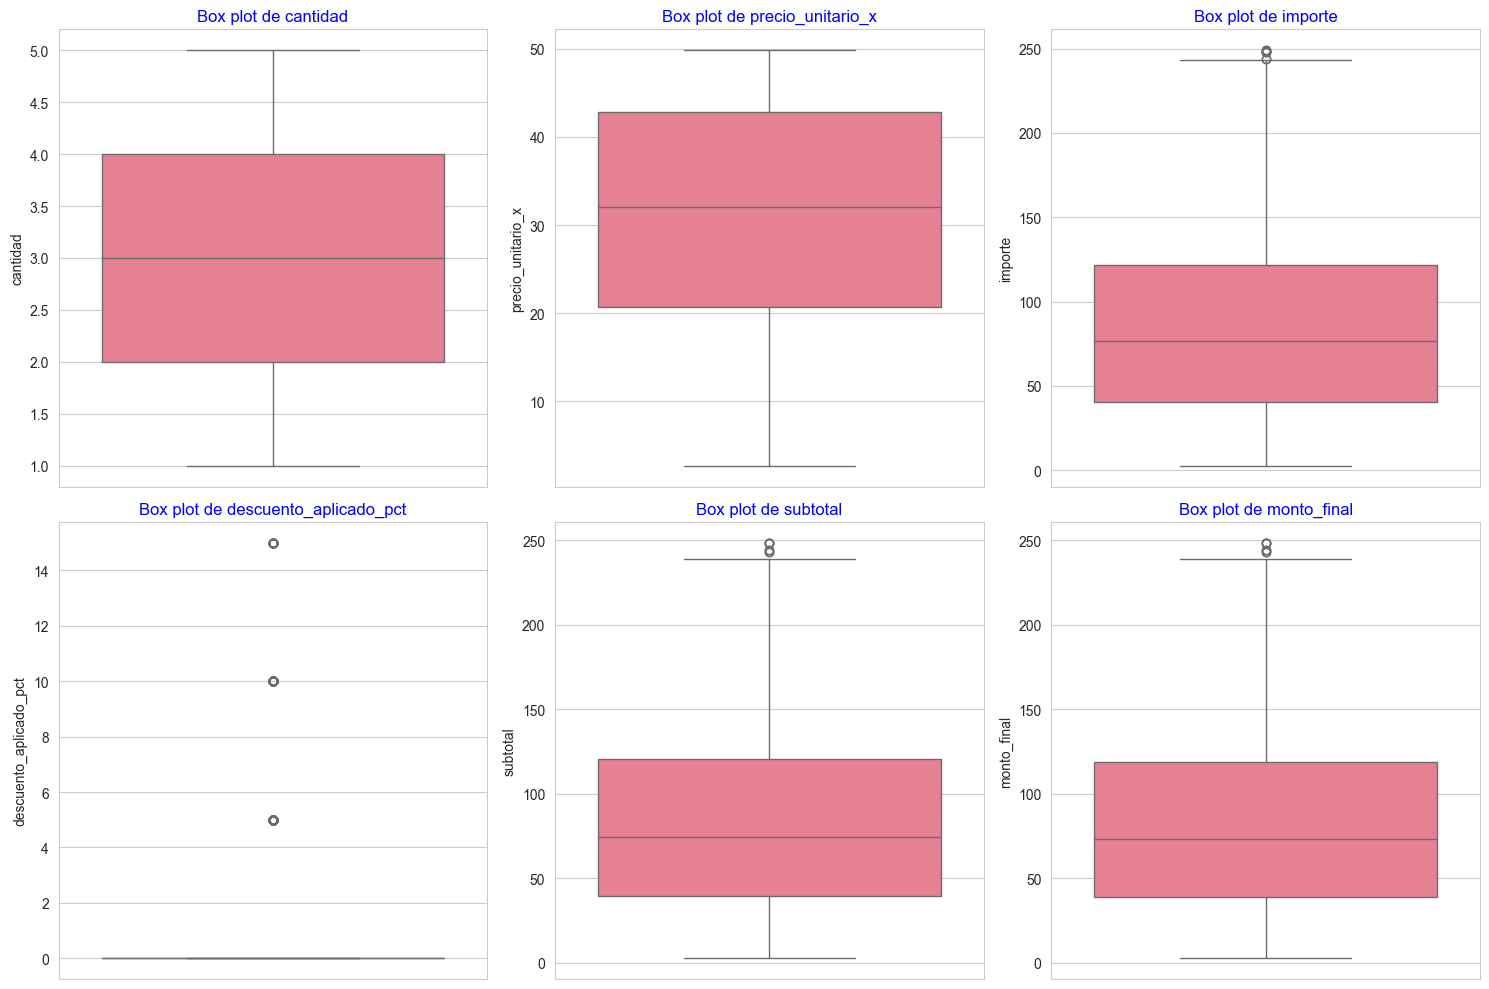

In [212]:
# Seleccionar columnas numéricas para visualización adicional
numerical_cols_viz = ['cantidad', 'precio_unitario_x', 'importe', 'descuento_aplicado_pct', 'subtotal', 'monto_final']

# Crear box plots para cada columna numérica seleccionada
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols_viz):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df_master[col])
    plt.title(f'Box plot de {col}', color='blue')
plt.tight_layout()
plt.savefig("imgs_analisis_statistic/box_plots.png")
plt.show()

### Interpretación de los Box plots

* **`cantidad`**: El box plot muestra que la mayoría de los valores están entre 2 y 4, con la mediana en 3. No parece haber outliers evidentes en esta variable.
* **`precio_unitario_x`**: La caja central abarca un rango amplio de precios, lo que concuerda con la desviación estándar observada. No se aprecian outliers significativos.
* **`importe`**, **`subtotal`**, **`monto_final`**: Estos box plots son similares y muestran una concentración de datos en la parte baja de la distribución, con una cola superior más larga y la presencia de algunos puntos que podrían ser considerados outliers (los puntos individuales por encima del bigote superior). Esto confirma el sesgo positivo identificado con la asimetría.
* **`descuento_aplicado_pct`**: Este box plot muestra claramente que la gran mayoría de los valores son 0. Los puntos individuales por encima de 0 representan los descuentos aplicados y son identificados como outliers por el método del box plot.

### Violin plots (Diagramas de Violín)

Los violin plots combinan un box plot con una estimación de la densidad de probabilidad, mostrando la forma de la distribución de manera más detallada.

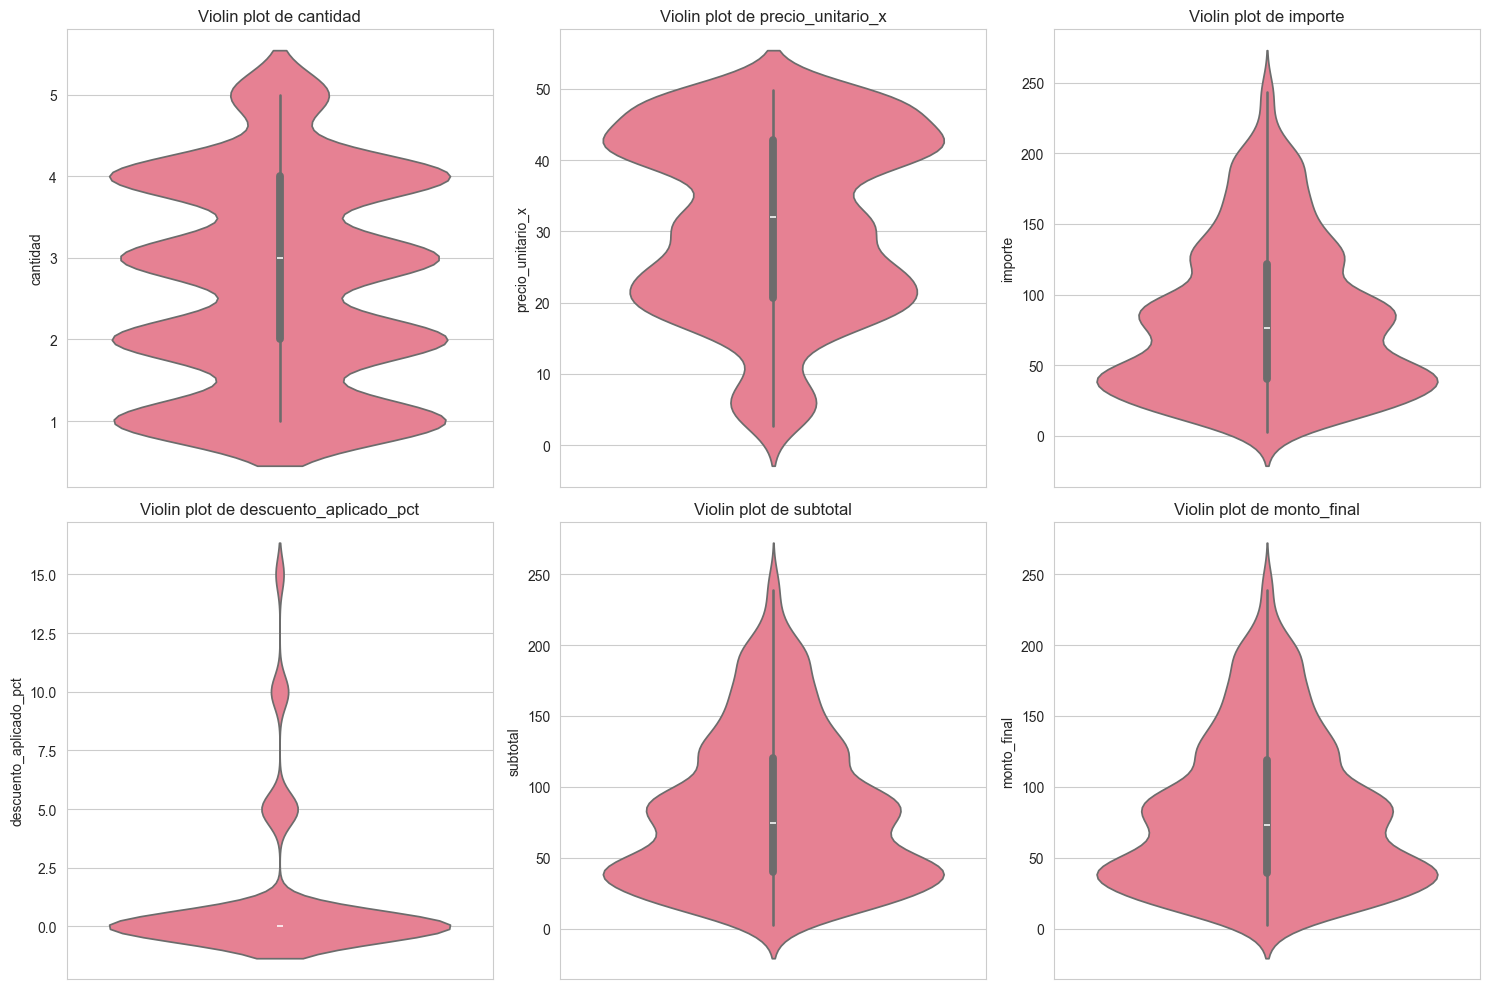

In [213]:
# Crear violin plots para cada columna numérica seleccionada
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols_viz):
    plt.subplot(2, 3, i + 1)
    sns.violinplot(y=df_master[col])
    plt.title(f'Violin plot de {col}')
plt.savefig("imgs_analisis_statistic/violin_plots.png")
plt.tight_layout()
plt.show()

### Interpretación de los Violin plots

Los violin plots confirman las observaciones de los histogramas y box plots:

* **`cantidad`**: La forma del violín es relativamente simétrica alrededor de la mediana, aunque con mayor densidad en los valores enteros (1, 2, 3, 4, 5).
* **`precio_unitario_x`**: El violín muestra una distribución más extendida, sin picos pronunciados, lo que sugiere una distribución más uniforme de los precios unitarios.
* **`importe`**, **`subtotal`**, **`monto_final`**: La forma de estos violines es más ancha en la parte inferior y se estrecha hacia arriba, lo que ilustra claramente el sesgo positivo y la concentración de datos en valores más bajos.
* **`descuento_aplicado_pct`**: El violin plot para el descuento es muy estrecho en la parte inferior (en 0) y se ensancha ligeramente en los valores de descuento, mostrando visualmente la baja frecuencia de descuentos aplicados.



### Interpretación General del Tipo de Distribución de Variables Numéricas (Basado en Box Plots y Violin Plots)

En conjunto, estas visualizaciones nos brindan una comprensión más completa de la forma, dispersión y presencia de posibles outliers en las distribuciones de las variables numéricas. La combinación de Box plots y Violin plots nos ha proporcionado una confirmación visual robusta de las características de las distribuciones de las variables numéricas:

* Las variables monetarias a nivel de detalle de venta (`importe`, `subtotal`, `monto_final`) y a nivel de venta (`monto_bruto`, `monto_neto`) presentan un **fuerte sesgo positivo**, lo que es una característica típica de los datos de ventas donde hay muchas transacciones pequeñas y algunas pocas grandes.
* El `descuento_aplicado_pct` es una variable con una distribución extremadamente **no normal y altamente sesgada**, donde el valor 0 domina por completo.
* `cantidad` y `precio_unitario_x` tienen distribuciones más **equilibradas**, aunque no necesariamente normales, sin la presencia de outliers significativos según el método IQR en `cantidad`.

Estas visualizaciones son fundamentales para complementar las estadísticas descriptivas numéricas, ya que nos dan una intuición directa sobre la forma de los datos, la concentración de valores y la ubicación de posibles outliers, lo cual es vital para la fase de preparación de datos y la selección de técnicas de análisis posteriores.

## 4: Análisis de correlaciones entre variables principales

En esta fase, exploraremos las relaciones lineales entre las variables numéricas clave calculando la matriz de correlación y visualizándola mediante un mapa de calor.

### Cálculo de la Matriz de Correlación de Pearson

In [26]:
# Seleccionar solo las columnas numéricas para el cálculo de la correlación
numerical_cols_corr = ['cantidad', 'precio_unitario_x', 'importe', 'subtotal', 'monto_bruto', 'monto_neto', 'monto_final']

# Calcular la matriz de correlación de Pearson
correlation_matrix_pearson = df_master[numerical_cols_corr].corr(method='pearson')

# Mostrar la matriz de correlación
print("\nMatriz de Correlación de Pearson de las variables numéricas clave en df_master:")
display(correlation_matrix_pearson)


Matriz de Correlación de Pearson de las variables numéricas clave en df_master:


,cantidad,precio_unitario_x,importe,subtotal,monto_bruto,monto_neto,monto_final
cantidad,1.000000,-0.017545,0.710145,0.709434,0.322723,0.322723,0.706964
precio_unitario_x,-0.017545,1.000000,0.626809,0.624753,0.219453,0.219453,0.621281
importe,0.710145,0.626809,1.000000,0.998489,0.406179,0.406179,0.994560
subtotal,0.709434,0.624753,0.998489,1.000000,0.404848,0.404848,0.998780
monto_bruto,0.322723,0.219453,0.406179,0.404848,1.000000,1.000000,0.402536
monto_neto,0.322723,0.219453,0.406179,0.404848,1.000000,1.000000,0.402536
monto_final,0.706964,0.621281,0.994560,0.998780,0.402536,0.402536,1.000000


### Visualización de la Matriz de Correlación de Pearson (Mapa de Calor)

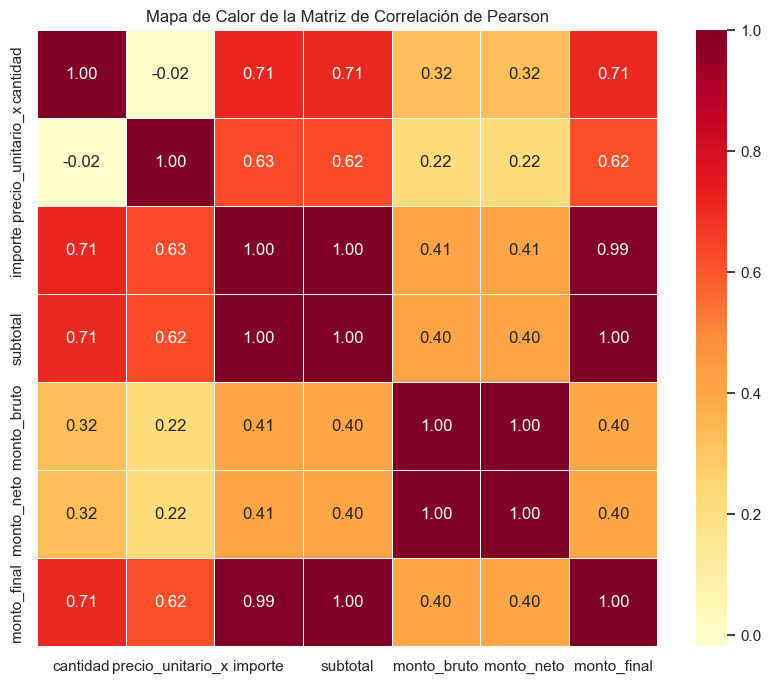

In [27]:
# Crear un mapa de calor (heatmap) de la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_pearson, annot=True, cmap='YlOrRd', fmt=".2f", linewidths=.5)
plt.title("Mapa de Calor de la Matriz de Correlación de Pearson") # Added label
plt.savefig("imgs_analisis_statistic/matriz_correlacion_pearson.png")
plt.show()

### Interpretación de la Matriz de Correlación y el Mapa de Calor

La matriz de correlación y el mapa de calor nos muestran la fuerza y dirección de la relación lineal entre pares de variables numéricas:

* **Valores cercanos a 1**: Indican una fuerte correlación positiva (cuando una variable aumenta, la otra también tiende a aumentar).
* **Valores cercanos a -1**: Indican una fuerte correlación negativa (cuando una variable aumenta, la otra tiende a disminuir).
* **Valores cercanos a 0**: Indican una correlación lineal débil o nula.

Observaciones clave de la matriz y el mapa de calor:

* **`importe`, `subtotal`, `monto_final`**: Como era de esperar, estas variables están muy fuertemente correlacionadas positivamente entre sí (valores cercanos a 1). Esto tiene sentido ya que representan valores monetarios muy relacionados dentro de un mismo detalle de venta. La ligera diferencia en la correlación entre `importe`/`subtotal` y `monto_final` se debe a la aplicación del descuento.
* **`cantidad` e `importe`/`subtotal`/`monto_final`**: Existe una correlación positiva moderada a fuerte entre la `cantidad` de productos en un detalle de venta y el `importe`, `subtotal` y `monto_final`. Esto es lógico, ya que a mayor cantidad de productos, mayor tiende a ser el importe total del detalle.
* **`precio_unitario_x` e `importe`/`subtotal`/`monto_final`**: También hay una correlación positiva moderada entre el `precio_unitario_x` y el `importe`, `subtotal` y `monto_final`. Esto indica que productos con mayor precio unitario tienden a contribuir a mayores importes en los detalles de venta donde se incluyen.
* **`cantidad` y `precio_unitario_x`**: La correlación entre `cantidad` y `precio_unitario_x` es cercana a 0 (-0.0175). Esto sugiere que no hay una relación lineal fuerte entre la cantidad de productos comprados en un detalle de venta y el precio unitario de esos productos.
* **`monto_bruto` y `monto_neto`**: Estas variables están perfectamente correlacionadas positivamente (valor de 1.00). Esto confirma que en este dataset, el monto bruto y el monto neto a nivel de venta son idénticos, lo cual ya habíamos notado y sugiere que los descuentos a nivel de detalle no se restan en estas columnas.
* **Correlaciones entre variables de detalle (`cantidad`, `precio_unitario_x`, `importe`, `subtotal`, `monto_final`) y variables de venta (`monto_bruto`, `monto_neto`)**: Las correlaciones entre estas dos series de variables son positivas pero más débiles en comparación con las correlaciones dentro de cada grupo. Esto es esperable, ya que `monto_bruto` y `monto_neto` representan el total de una venta (que puede incluir múltiples detalles de venta), mientras que las otras variables son a nivel de detalle.

Este análisis de correlación nos ayuda a entender las interdependencias entre las variables numéricas, lo cual es útil para modelado predictivo o para identificar relaciones importantes en los datos.

## Análisis de Correlación de Spearman

Calcularemos la matriz de correlación de Spearman, que es menos sensible a outliers y relaciones no lineales, para complementar el análisis de Pearson.

### Cálculo de la Matriz de Correlación de Spearman

In [28]:
# Calcular la matriz de correlación de Spearman
correlation_matrix_spearman = df_master[numerical_cols_corr].corr(method='spearman')

# Mostrar la matriz de correlación de Spearman
print("\nMatriz de Correlación de Spearman de las variables numéricas clave en df_master:")
display(correlation_matrix_spearman)


Matriz de Correlación de Spearman de las variables numéricas clave en df_master:


,cantidad,precio_unitario_x,importe,subtotal,monto_bruto,monto_neto,monto_final
cantidad,1.000000,-0.008519,0.707304,0.708020,0.316858,0.316858,0.707184
precio_unitario_x,-0.008519,1.000000,0.639083,0.635685,0.221618,0.221618,0.630834
importe,0.707304,0.639083,1.000000,0.998586,0.393725,0.393725,0.995284
subtotal,0.708020,0.635685,0.998586,1.000000,0.391361,0.391361,0.998901
monto_bruto,0.316858,0.221618,0.393725,0.391361,1.000000,1.000000,0.389452
monto_neto,0.316858,0.221618,0.393725,0.391361,1.000000,1.000000,0.389452
monto_final,0.707184,0.630834,0.995284,0.998901,0.389452,0.389452,1.000000


### Visualización de la Matriz de Correlación de Spearman (Mapa de Calor)

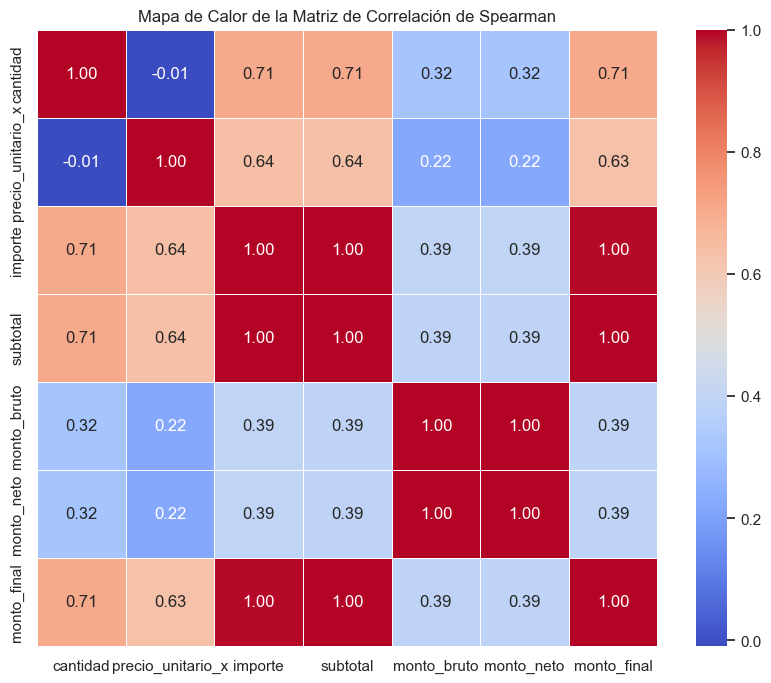

In [29]:
# Crear un mapa de calor (heatmap) de la matriz de correlación de Spearman
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_spearman, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Mapa de Calor de la Matriz de Correlación de Spearman")
plt.savefig("imgs_analisis_statistic/matriz_correlacion_spearman.png")
plt.show()

### Interpretación de la Matriz de Correlación de Spearman

En general, los coeficientes de Spearman tenderán a ser similares a los de Pearson si las relaciones son predominantemente lineales y no hay outliers extremos. Sin embargo, pueden diferir notablemente si hay fuertes relaciones monótonas que no son lineales, o si los outliers influyen en la correlación de Pearson.
Este análisis complementario con Spearman nos da una visión más completa y robusta de las asociaciones entre las variables numéricas, especialmente útil dado el sesgo y los posibles outliers que hemos identificado en pasos anteriores.

## **Comparación de los mapas de calor de Pearson y Spearman** ###

Al comparar la matriz de correlación de Spearman con la de Pearson, podemos observar si la presencia de outliers o la naturaleza no lineal de algunas relaciones afectó significativamente los coeficientes de correlación. En general, los coeficientes de Spearman tenderán a ser similares a los de Pearson si las relaciones son predominantemente lineales y no hay outliers extremos. Sin embargo, pueden diferir notablemente si hay fuertes relaciones monótonas que no son lineales, o si los outliers influyen en la correlación de Pearson.
Este análisis complementario nos da una visión más completa y robusta de las asociaciones entre las variables numéricas, especialmente útil dado el sesgo y los posibles outliers que hemos identificado en pasos anteriores.


***Consideraciones sobre outliers y sesgo en las correlaciones***

Al comparar los mapas de calor de Pearson y Spearman, podemos notar lo siguiente:

*   **Correlaciones fuertes (cercanas a 1 o -1):** Para las variables que ya mostraron una correlación de Pearson muy fuerte (por ejemplo, entre `importe`, `subtotal` y `monto_final`), los valores de Spearman son muy similares. Esto sugiere que estas relaciones son consistentemente fuertes y monótonas, y los outliers no afectan drásticamente su ordenamiento.
*   **Correlaciones moderadas:** Para correlaciones moderadas (como entre `cantidad` y las variables de monto, o entre `precio_unitario_x` y las variables de monto), los valores de Spearman también son bastante parecidos a los de Pearson, aunque puede haber ligeras variaciones. Esto indica que la relación monótona es similar a la relación lineal para la mayoría de los datos.
*   **Correlaciones débiles (cercanas a 0):** La correlación entre `cantidad` y `precio_unitario_x` sigue siendo muy cercana a 0 en Spearman (-0.0085), al igual que en Pearson (-0.0175). Esto refuerza la idea de que no hay una relación lineal o monótona significativa entre la cantidad de artículos comprados y su precio unitario en un detalle de venta.
*   **Impacto de Outliers/Sesgo:** Aunque las diferencias no son drásticas en este dataset particular para la mayoría de las variables (lo que podría sugerir que los outliers no son extremadamente influyentes en el ordenamiento de los rangos, o que las relaciones monótonas son bastante lineales), la correlación de Spearman es inherentemente más robusta ante la presencia de esos outliers y el sesgo que observamos en las distribuciones. Por lo tanto, los valores de Spearman pueden considerarse una representación más fiable de la asociación general entre las variables en presencia de datos no normales o con outliers.

En resumen, en este caso, los resultados de Pearson y Spearman son bastante consistentes, lo que es positivo. Sin embargo, si tuviéramos outliers más extremos o relaciones claramente no lineales, las diferencias serían más pronunciadas. La correlación de Spearman nos da confianza en que las asociaciones que observamos no están siendo indebidamente influenciadas por los valores extremos.

## 5: Detección de Outliers mediante Cuartiles y Rangos (Método IQR)

En esta fase, aplicaremos el método del rango intercuartílico (IQR) para identificar posibles outliers en algunas de las variables numéricas clave de `df_master`. Este método es menos sensible a los extremos que, por ejemplo, la detección basada en la desviación estándar.

### A: Cálculo de Cuartiles, IQR y Límites para Detección de Outliers

Calcularemos el primer cuartil (Q1), el tercer cuartil (Q3) y el rango intercuartílico (IQR) para la variable `monto_final`. Luego, definiremos los límites inferior y superior para identificar outliers.

In [30]:
# Seleccionar la variable para la detección de outliers (por ejemplo, 'monto_final')
variable_outliers = 'monto_final'

# Calcular el primer cuartil (Q1)
Q1 = df_master[variable_outliers].quantile(0.25)

# Calcular el tercer cuartil (Q3)
Q3 = df_master[variable_outliers].quantile(0.75)

# Calcular el rango intercuartílico (IQR)
IQR = Q3 - Q1

# Definir los límites para la detección de outliers
# Los outliers se consideran valores por debajo de Q1 - 1.5*IQR o por encima de Q3 + 1.5*IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Mostrar los valores calculados
print(f"Variable analizada: {variable_outliers}")
print(f"Q1: {Q1:.2f}")
print(f"Q3: {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Límite Inferior para Outliers: {lower_bound:.2f}")
print(f"Límite Superior para Outliers: {upper_bound:.2f}")

Variable analizada: monto_final
Q1: 39.06
Q3: 119.04
IQR: 79.98
Límite Inferior para Outliers: -80.91
Límite Superior para Outliers: 239.00


### Identificación y Visualización de Outliers

Ahora, identificaremos las filas en `df_master` que contienen outliers según los límites calculados y mostraremos estos outliers. También podemos visualizar su posición en un box plot, tomando como ejemplo la variable `monto_final`, evaluada en la sección anterior.


Número de outliers detectados en 'monto_final': 8

Outliers detectados en 'monto_final':


,id_venta,id_producto,nombre_producto_x,cantidad,precio_unitario_x,importe,descuento_aplicado_pct,subtotal,nombre_producto_y,categoria,precio_unitario_y,subcategoria,fecha,id_cliente,id_sucursal_x,id_vendedor,id_medio_pago,nombre_cliente_x,email_x,medio_pago_original,estado_venta,monto_bruto,monto_neto,nombre_cliente_y,email_y,ciudad_x,fecha_alta,genero,edad_rango,activo_como_cliente,nombre_sucursal,ciudad_y,provincia,nombre_vendedor,id_sucursal_y,fecha_ingreso,activo,nombre_medio_pago,año,mes,dia_nombre,descuento_pct,monto_final
208,75,2,Pepsi 1.5L,5,49.73,248.65,0,248.65,Pepsi 1.5L,Bebidas,49.73,Gaseosas,2023-03-17,34,3,14,3,Bruno Castro,bruno.castro2@mail.com,qr,OK,447.21,447.21,Bruno Castro,bruno.castro2@mail.com,Villa Maria,2023-02-03,F,56+,True,Tienda Aurelion - Córdoba,Cordoba,Cordoba,Vendedor 14,3,2022-04-15,True,qr,2023,3,Friday,0.0,248.65
1585,108,3,Sprite 1.5L,5,49.64,248.20,0,248.20,Sprite 1.5L,Bebidas,49.64,Gaseosas,2023-04-28,100,6,1,2,Agustina Lopez,agustina.lopez@mail.com,tarjeta,OK,364.28,364.28,Agustina Lopez,agustina.lopez@mail.com,Cordoba,2023-04-10,M,26-40,True,Tienda Aurelion - Mendiolaza,Mendiolaza,Cordoba,Vendedor 01,6,2022-04-25,True,tarjeta,2023,4,Friday,0.0,248.20
1655,222,10,Yerba Mate Intensa 1kg,5,48.83,244.15,0,244.15,Yerba Mate Intensa 1kg,Infusiones,48.83,Yerba Mate,2023-07-27,18,6,2,4,Ivana Torres,ivana.torres@mail.com,transferencia,OK,287.14,287.14,Ivana Torres,ivana.torres@mail.com,Carlos Paz,2023-01-18,M,26-40,True,Tienda Aurelion - Mendiolaza,Mendiolaza,Cordoba,Vendedor 02,6,2022-10-09,True,transferencia,2023,7,Thursday,0.0,244.15
1743,432,10,Yerba Mate Intensa 1kg,5,48.83,244.15,0,244.15,Yerba Mate Intensa 1kg,Infusiones,48.83,Yerba Mate,2024-01-12,59,2,12,1,Emilia Ruiz,emilia.ruiz@mail.com,efectivo,OK,409.72,409.72,Emilia Ruiz,emilia.ruiz@mail.com,Villa Maria,2023-02-28,F,18-25,True,Tienda Aurelion - Río Cuarto,Rio Cuarto,Cordoba,Vendedor 12,2,2023-03-09,True,efectivo,2024,1,Friday,0.0,244.15
1761,600,3,Sprite 1.5L,5,49.64,248.20,0,248.20,Sprite 1.5L,Bebidas,49.64,Gaseosas,2024-04-26,56,4,15,1,Bruno Diaz,bruno.diaz@mail.com,efectivo,OK,391.94,391.94,Bruno Diaz,bruno.diaz@mail.com,Rio Cuarto,2023-02-25,M,18-25,True,Tienda Aurelion - Villa María,Villa Maria,Cordoba,Vendedor 15,4,2022-04-10,True,efectivo,2024,4,Friday,0.0,248.20


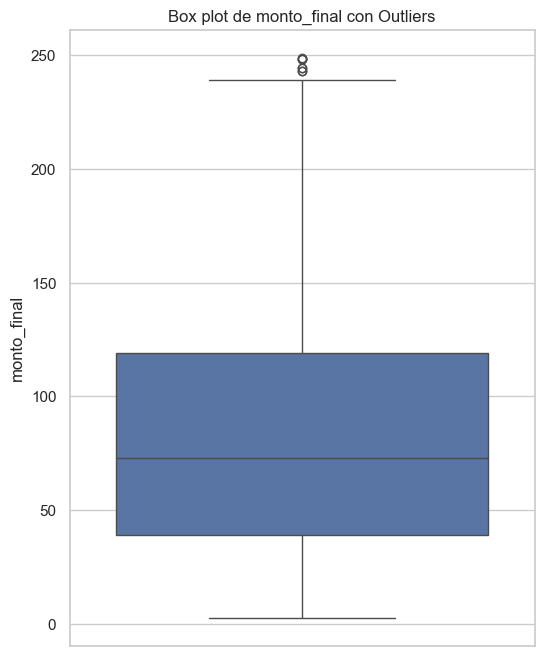

In [31]:
# Identificar los outliers
outliers = df_master[(df_master[variable_outliers] < lower_bound) | (df_master[variable_outliers] > upper_bound)]

# Mostrar el número de outliers encontrados
print(f"\nNúmero de outliers detectados en '{variable_outliers}': {len(outliers)}")

# Mostrar los outliers (primeras filas si hay muchos)
print(f"\nOutliers detectados en '{variable_outliers}':")
if not outliers.empty:
    display(outliers.head()) # Mostrar solo las primeras filas de outliers
else:
    print("No se detectaron outliers según el método IQR.")
print("\n")
# Visualizar los outliers en un box plot para la variable analizada
plt.figure(figsize=(6, 8))
sns.boxplot(y=df_master[variable_outliers])
plt.title(f'Box plot de {variable_outliers} con Outliers')
plt.savefig(f"imgs_analisis_statistic/boxplot_{variable_outliers}.png")
plt.show()



### Aplicamos el método IQR en `df_master`:

In [214]:
# Lista de variables numéricas
vars_numericas = [
    'cantidad', 'precio_unitario_x', 'importe', 'subtotal',
    'monto_bruto', 'monto_neto', 'monto_final', 'descuento_aplicado_pct'
]

# Lista para almacenar resultados
resultados = []

total_registros = len(df_master)

# Calcular outliers por IQR
for col in vars_numericas:
    Q1 = df_master[col].quantile(0.25)
    Q3 = df_master[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outlier_count = ((df_master[col] < lower) | (df_master[col] > upper)).sum()
    porcentaje = (outlier_count / total_registros) * 100

    resultados.append([col, Q1, Q3, IQR, lower, upper, outlier_count, porcentaje])

# Crear DataFrame resumen
tabla_outliers = pd.DataFrame(resultados, columns=[
    "Variable", "Q1", "Q3", "IQR", "Límite Inf.", "Límite Sup.",
    "Outliers", "% Outliers"
])

# Redondeo para estética
tabla_outliers = tabla_outliers.round({
    "Q1": 2, "Q3": 2, "IQR": 2,
    "Límite Inf.": 2, "Límite Sup.": 2,
    "% Outliers": 2
})

# Mostrar tabla completa
pd.set_option('display.max_rows', None)
display(tabla_outliers)

# Exportar, descomentar si es necesario
tabla_outliers.to_excel("reports_dframes/outliers_IQR_pBI.xlsx", index=False)


,Variable,Q1,Q3,IQR,Límite Inf.,Límite Sup.,Outliers,% Outliers
0,cantidad,2.00,4.00,2.00,-1.00,7.00,0,0.00
1,precio_unitario_x,20.69,42.86,22.17,-12.56,76.11,0,0.00
2,importe,40.40,121.44,81.04,-81.17,243.00,8,0.40
3,subtotal,39.62,120.56,80.94,-81.79,241.97,8,0.40
4,monto_bruto,170.80,375.72,204.92,-136.58,683.10,10,0.50
5,monto_neto,170.80,375.72,204.92,-136.58,683.10,10,0.50
6,monto_final,39.06,119.04,79.98,-80.91,239.00,8,0.40
7,descuento_aplicado_pct,0.00,0.00,0.00,0.00,0.00,307,15.23


### Interpretación de los Resultados:

* **`cantidad`**:
  No se detectaron outliers en esta variable. Los valores están dentro de un rango esperado, lo que indica que la cantidad de productos vendidos es coherente y no presenta valores extremos.

* **`precio_unitario_x`**:
  Al igual que en `cantidad`, no se detectaron outliers en el precio unitario. Esto sugiere que los precios de los productos vendidos están dentro de los límites razonables y no hay precios inusualmente bajos o altos.

* **`importe` y `subtotal`**:
  Se detectaron 8 outliers en ambas variables. Los valores atípicos se encuentran por encima de los límites establecidos, lo que podría indicar transacciones con valores excepcionales (por ejemplo, ventas grandes o errores en el cálculo). Sería prudente revisar estas transacciones para asegurarse de que son legítimas.

* **`monto_bruto` y `monto_neto`**:
  Estas dos variables presentan 10 outliers, que podrían ser transacciones con grandes volúmenes o descuentos aplicados, o errores de datos. Similar a los anteriores, se recomienda revisar estos registros para asegurar que no haya datos incorrectos.

* **`monto_final`**:
  Se detectaron 8 outliers, lo que podría estar relacionado con transacciones con valores significativamente más altos o bajos que los demás. Esto podría deberse a ventas excepcionales o errores de entrada. Se recomienda investigar estas transacciones para determinar si son válidas o necesitan ser corregidas.

* **`descuento_aplicado_pct`**:
  Esta variable tiene un número muy alto de outliers (307), lo cual es inusual. Sin embargo, dado que el **rango intercuartílico (IQR)** es 0, y los valores de descuento aplicados son extremadamente pequeños (casi siempre 0), es probable que los "outliers" en este caso representen registros donde los descuentos fueron aplicados en promociones especiales.Este tipo de variabilidad es importante revisar, pero podría considerarse normal si los descuentos son muy poco frecuentes o si la política de descuentos tiene cambios inesperados.

En general, los outliers no necesariamente indican errores, sino que podrían representar casos excepcionales que podrían ser relevantes para el análisis de ventas o políticas de descuento. Es recomendable investigar estos casos para entender si son datos válidos o si necesitan ser corregidos.


## B: Detección de outliers usando método IQR y Z-score
En esta sección, se utiliza los métodos del rango intercuartílico (IQR) y Z-score para detectar valores atípicos (outliers) en las variables numéricas del `df_master`. Estos métodos ayudan a identificar datos extremos que podrían representar errores o transacciones excepcionales.
* IQR es útil para detectar outliers en distribuciones no normales, o cuando hay datos con colas largas. Sin embargo, puede ser más rígido en su definición de lo que es un outlier, ya que se basa en cuartiles y no en la variabilidad global de los datos.

* Z-score es más adecuado para distribuciones normales y detecta outliers basándose en la variabilidad general (desviación estándar). Este método puede pasar por alto outliers en distribuciones sesgadas o no normales, pero es excelente para detectar puntos extremos en datos simétricos.

Los resultados se presentan en términos de la cantidad de outliers detectados por cada método y el porcentaje de outliers en relación con el total de datos.



In [216]:
# Detección de outliers
from scipy import stats # Importar stats para Z-score

def detectar_outliers_avanzado(df, columna):
    """Detecta outliers usando método IQR y Z-score"""
    # Asegurarse de que la columna sea numérica
    if pd.api.types.is_numeric_dtype(df[columna]):
        Q1 = df[columna].quantile(0.25)
        Q3 = df[columna].quantile(0.75)
        IQR = Q3 - Q1

        # Método IQR
        outliers_iqr = df[(df[columna] < Q1 - 1.5*IQR) | (df[columna] > Q3 + 1.5*IQR)]

        # Método Z-score
        # Calcular Z-scores solo si hay datos no nulos y más de un valor único
        if df[columna].dropna().nunique() > 1:
            z_scores = np.abs(stats.zscore(df[columna].dropna()))
            outliers_z = df[columna].dropna()[z_scores > 3]
            return len(outliers_iqr), len(outliers_z)
        else:
            # No se puede calcular Z-score si no hay variabilidad o datos suficientes
            return len(outliers_iqr), 0 # Retorna 0 para Z-score si no es aplicable
    else:
        # Si la columna no es numérica, no se detectan outliers numéricos
        return 0, 0 # Retorna 0 para ambos métodos si la columna no es numérica


print("\n DETECCIÓN DE OUTLIERS")
print("="*70)
# Definir las variables numéricas relevantes del df_master
vars_numericas = ['cantidad', 'precio_unitario_x', 'importe', 'subtotal', 'monto_bruto', 'monto_neto', 'monto_final', 'descuento_aplicado_pct'] # Agregamos descuento_aplicado_pct para detección de outliers

print(f"{'Variable':<25} {'IQR Count':<15} {'Z-score Count (|z|>3)':<25} {'% Outliers (IQR)'}")
print("-"*80)

for var in vars_numericas:
    iqr_count, z_count = detectar_outliers_avanzado(df_master, var) # Usar df_master
    if len(df_master) > 0: # Evitar división por cero
        pct = (iqr_count / len(df_master)) * 100
    else:
        pct = 0
    print(f"{var:<25} {iqr_count:<15} {z_count:<25} {pct:.2f}%")

print("\n Los outliers pueden indicar transacciones excepcionales o errores de datos")


 DETECCIÓN DE OUTLIERS
Variable                  IQR Count       Z-score Count (|z|>3)     % Outliers (IQR)
--------------------------------------------------------------------------------
cantidad                  0               0                         0.00%
precio_unitario_x         0               0                         0.00%
importe                   8               6                         0.40%
subtotal                  8               4                         0.40%
monto_bruto               10              10                        0.50%
monto_neto                10              10                        0.50%
monto_final               8               6                         0.40%
descuento_aplicado_pct    307             40                        15.23%

 Los outliers pueden indicar transacciones excepcionales o errores de datos


### Interpretación de la Detección de Outliers

La detección de outliers nos muestra que:

*   **Variables Monetarias (`importe`, `subtotal`, `monto_final`, `monto_bruto`, `monto_neto`):** Se identificaron un pequeño número de outliers (entre 6 y 10 dependiendo del método y la variable). Estos representan transacciones o detalles de venta con valores significativamente más altos que la mayoría, lo cual es consistente con el sesgo positivo observado.
*   **`cantidad` y `precio_unitario_x`:** No se detectaron outliers significativos, indicando consistencia en estos valores.
*   **`descuento_aplicado_pct`:** La alta cantidad de "outliers" por el método IQR (15.23%) confirma que los descuentos son poco frecuentes y se aplican en porcentajes específicos (5%, 10%, 15%) que son atípicos en comparación con la mayoría de los valores que son 0.

En general, la presencia de outliers en los montos resalta transacciones de alto valor que podrían requerir análisis adicional, mientras que en el descuento solo confirma su baja frecuencia.

## Interpretación de Resultados de Detección de Outliers

Se realizaron dos métodos de detección de outliers: **IQR (Rango Intercuartílico)** y **IQR combinado con Z-score**. A continuación se detallan las observaciones clave de ambos enfoques:

### 1. **Resultados con IQR:**
   - **IQR** identificó outliers en varias variables como **importe**, **subtotal**, **monto_bruto**, **monto_neto**, **monto_final**, y especialmente en **descuento_aplicado_pct**.
   - Las variables **cantidad** y **precio_unitario_x** no presentan outliers según este método, lo que sugiere que no hay transacciones inusuales en cuanto a la cantidad de productos vendidos o su precio unitario.
   - En general, **IQR** detectó un 0.4% a 0.5% de outliers en las transacciones, con una excepción notable en **descuento_aplicado_pct**, que presentó un 15.23% de outliers debido a la gran cantidad de transacciones con descuento igual a 0.

### 2. **Resultados con IQR + Z-score:**
   - **Z-score** redujo el número de outliers en comparación con **IQR**. Esto es esperable, ya que el **Z-score** detecta valores que se desvían significativamente de la media, por lo que es más estricto en la detección de valores atípicos extremos.
   - En el caso de **descuento_aplicado_pct**, **Z-score** encontró menos outliers (40 vs 307), lo que indica que la mayoría de los registros con descuento igual a 0 no son tan extremos si se consideran en relación con la media.
   - Aunque las **variables** como **monto_bruto**, **monto_neto**, **monto_final** y **importe** siguen mostrando una cantidad razonable de outliers, los resultados con **Z-score** son más consistentes en términos de transacciones inusuales en comparación con **IQR**.

### Conclusión:
- **IQR** es más sensible a los valores fuera de los cuartiles y puede identificar un mayor número de outliers, especialmente cuando hay una distribución de valores muy concentrada en torno a un valor (como en **descuento_aplicado_pct**).
- **Z-score** proporciona un análisis más riguroso para detectar los valores atípicos extremos basados en la desviación de la media. Es útil para filtrar los outliers más distantes, pero puede no identificar valores atípicos menos extremos que **IQR** sí podría captar.
- Ambos métodos son complementarios y deberían ser utilizados juntos para obtener una visión más completa de los outliers y evaluar la calidad de los datos.


- **Recomendación:** Se recomienda realizar un análisis adicional para entender mejor las transacciones con outliers, especialmente en lo que respecta a los descuentos aplicados, y evaluar si estos resultados son una representación precisa de las políticas de descuentos o si deben ajustarse.





## Aplicación de Intervalos de Confianza (95%)

Calculamos los intervalos de confianza al 95% para varias métricas clave de ventas, lo que significa que hay un 95% de certeza de que el valor real se encuentra dentro del intervalo estimado. El cálculo se realiza utilizando el **error estándar de la media** y la **distribución t** de Student, ya que estamos trabajando con una muestra y no con toda la población.

In [217]:
# Intervalos de confianza (95%)
from scipy import stats # Asegurarse de que stats esté importado

def intervalo_confianza(data, confidence=0.95):
    """Calcula intervalo de confianza"""
    n = len(data)
    if n == 0:
        return np.nan, np.nan, np.nan # Manejar caso de datos vacíos
    mean = np.mean(data)
    se = stats.sem(data)
    # Asegurarse de que los grados de libertad son válidos
    degrees_freedom = n - 1
    if degrees_freedom <= 0:
         return mean, np.nan, np.nan # No se puede calcular IC con 1 o 0 puntos de datos

    margin = se * stats.t.ppf((1 + confidence) / 2, degrees_freedom)
    return mean, mean - margin, mean + margin

print("\nINTERVALOS DE CONFIANZA (95%)")
print("="*70)
# Ajuste el ancho del encabezado para que coincida con el nuevo formato de datos
print(f"{'Métrica':<17} {'Media':>15} {'IC Inferior':>13} {'IC Superior':>13}")
print("-"*70)

# Usar df_master y variables numéricas relevantes
metricas_ic = {
    'Importe por detalle': df_master['importe'], # Usar importe de detalle
    'Cantidad por detalle': df_master['cantidad'], # Usar cantidad de detalle
    'Precio unitario': df_master['precio_unitario_x'], # Usar precio_unitario_x de detalle
    'Monto final por detalle': df_master['monto_final'], # Usar monto_final de detalle
    'Monto bruto por venta': df_master['monto_bruto'], # Usar monto_bruto de venta
    'Monto neto por venta': df_master['monto_neto'] # Usar monto_neto de venta
}

for nombre, data in metricas_ic.items():
    # Asegurarse de que los datos son numéricos antes de calcular
    if pd.api.types.is_numeric_dtype(data):
        mean, lower, upper = intervalo_confianza(data.dropna()) # Aplicar dropna() por si acaso
        if not np.isnan(mean): # Solo imprimir si el cálculo fue exitoso
             # Formato ajustado para usar 7.2f y el signo $
             print(f"{nombre:<25}  {mean:>7.2f}    {lower:>7.2f}    {upper:>7.2f}")
        else:
             print(f"{nombre:<25} {'N/A':>10} {'N/A':>10} {'N/A':>10}")

    else:
        print(f"{nombre:<20} {'No Numérica':>15} {'N/A':>13} {'N/A':>13}")





INTERVALOS DE CONFIANZA (95%)
Métrica                     Media   IC Inferior   IC Superior
----------------------------------------------------------------------
Importe por detalle          83.86      81.48      86.24
Cantidad por detalle          2.68       2.62       2.73
Precio unitario              31.45      30.89      32.01
Monto final por detalle      82.06      79.71      84.41
Monto bruto por venta       279.66     273.28     286.04
Monto neto por venta        279.66     273.28     286.04


### Interpretación de los Resultados de Intervalos de Confianza (95%)

Los intervalos de confianza del 95% calculados nos dan un rango estimado para la verdadera media poblacional de cada métrica, basándonos en nuestros datos. Los límites del intervalo están en la misma unidad que la métrica analizada (monetaria o cantidad de unidades), y el 95% se refiere a la confianza en que la verdadera media de la población se encuentra dentro de ese rango.

Aquí está la interpretación de los resultados específicos:

*   **Importe por detalle:** Con 95% de confianza, el importe promedio por cada línea de producto vendida en la población está entre **$81.48  y  $86.24**.
*   **Cantidad por detalle:** Con 95% de confianza, la cantidad promedio de productos por línea de venta en la población está entre **2.62 y 2.73 unidades**.
*   **Precio unitario:** Con 95% de confianza, el precio unitario promedio de los productos vendidos en la población está entre **$30.89 y $32.01**.
*   **Monto final por detalle:** Con 95% de confianza, el monto final promedio por cada línea de producto (después de descuentos) en la población está entre **$79.71 y $84.41**.
*   **Monto bruto por venta:** Con 95% de confianza, el monto bruto promedio por venta total en la población está entre **$273.28 y $286.04**.
*   **Monto neto por venta:** Con 95% de confianza, el monto neto promedio por venta total en la población está entre **$273.28 y $286.04**.

Esta interpretación nos ayuda a entender la precisión de nuestras estimaciones de la media para estas métricas clave y proporciona un rango plausible para los valores promedio a nivel de población.

## Aplicación de Segmentación de Clientes por Recencia, Frecuencia y Valor Monetario

### ANÁLISIS RFM DE CLIENTES


In [35]:
# Análisis RFM (Recencia, Frecuencia, Valor Monetario)
# Definimos la fecha de referencia como el día siguiente a la última fecha de venta
fecha_referencia = df_master['fecha'].max() + pd.Timedelta(days=1)

# Agrupamos por cliente para calcular las métricas RFM
rfm = df_master.groupby('id_cliente').agg({
    'fecha': lambda x: (fecha_referencia - x.max()).days,  # Recencia: Días desde la última compra
    'id_venta': 'nunique',  # Frecuencia: Número de ventas únicas por cliente
    'monto_final': 'sum'  # Valor Monetario: Suma del monto final (con descuento) por cliente
}).rename(columns={
    'fecha': 'Recencia',
    'id_venta': 'Frecuencia',
    'monto_final': 'Valor_Monetario'
})

# Calculamos las puntuaciones RFM (cuantiles 1-5, donde 5 es la mejor puntuación)
rfm['R_Score'] = pd.qcut(rfm['Recencia'], 5, labels=[5,4,3,2,1], duplicates='drop') # Recencia: menores días = mejor puntuación
rfm['F_Score'] = pd.qcut(rfm['Frecuencia'].rank(method='first'), 5, labels=[1,2,3,4,5], duplicates='drop') # Frecuencia: mayor número de ventas = mejor puntuación
rfm['M_Score'] = pd.qcut(rfm['Valor_Monetario'], 5, labels=[1,2,3,4,5], duplicates='drop') # Valor Monetario: mayor gasto = mejor puntuación

# Creamos un score RFM combinado (concatenando las puntuaciones)
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
# Calculamos un score RFM total (sumando las puntuaciones)
rfm['RFM_Total'] = rfm[['R_Score', 'F_Score', 'M_Score']].astype(int).sum(axis=1)

# Segmentación de clientes basada en el score RFM total
def segmentar_rfm(score):
    if score >= 13:
        return 'Champions' # Clientes de mayor valor y más recientes
    elif score >= 10:
        return 'Loyal' # Clientes frecuentes y que gastan bien
    elif score >= 7:
        return 'Potential' # Clientes con potencial para ser leales
    elif score >= 5:
        return 'At Risk' # Clientes que están dejando de comprar
    else:
        return 'Lost' # Clientes que ya no compran

# Aplicamos la función de segmentación
rfm['Segmento'] = rfm['RFM_Total'].apply(segmentar_rfm)

# Imprimimos los resultados del análisis RFM
print("\nANÁLISIS RFM DE CLIENTES")
print("="*70)
print("\nEstadísticas RFM:")
display(rfm[['Recencia', 'Frecuencia', 'Valor_Monetario']].describe().round(2))

print("\nDistribución de Segmentos:")
segmentos = rfm['Segmento'].value_counts()
# Imprimimos el conteo y porcentaje de clientes por segmento
for segmento, count in segmentos.items():
    pct = (count / len(rfm)) * 100
    print(f"  {segmento:<15} {count:>3} clientes ({pct:>5.1f}%)")

print("\nValor por Segmento:")
# Calculamos el valor total, promedio y conteo por segmento
valor_segmento = rfm.groupby('Segmento')['Valor_Monetario'].agg(['sum', 'mean', 'count'])
# Calculamos el porcentaje del valor monetario total que representa cada segmento
valor_segmento['% del Total'] = (valor_segmento['sum'] / valor_segmento['sum'].sum() * 100)
display(valor_segmento.round(2))


ANÁLISIS RFM DE CLIENTES

Estadísticas RFM:


,Recencia,Frecuencia,Valor_Monetario
count,99.00,99.00,99.00
mean,68.64,7.27,1671.11
std,72.39,6.18,1435.00
min,1.00,1.00,29.93
25%,15.00,3.00,740.82
50%,44.00,5.00,1212.35
75%,98.00,8.00,2021.44
max,368.00,26.00,5530.67



Distribución de Segmentos:
  Champions        24 clientes ( 24.2%)
  Loyal            23 clientes ( 23.2%)
  Potential        21 clientes ( 21.2%)
  Lost             16 clientes ( 16.2%)
  At Risk          15 clientes ( 15.2%)

Valor por Segmento:


,sum,mean,count,% del Total
Segmento,,,,
At Risk,10583.85,705.59,15,6.40
Champions,91078.86,3794.95,24,55.05
Lost,6937.50,433.59,16,4.19
Loyal,34074.97,1481.52,23,20.60
Potential,22764.99,1084.05,21,13.76


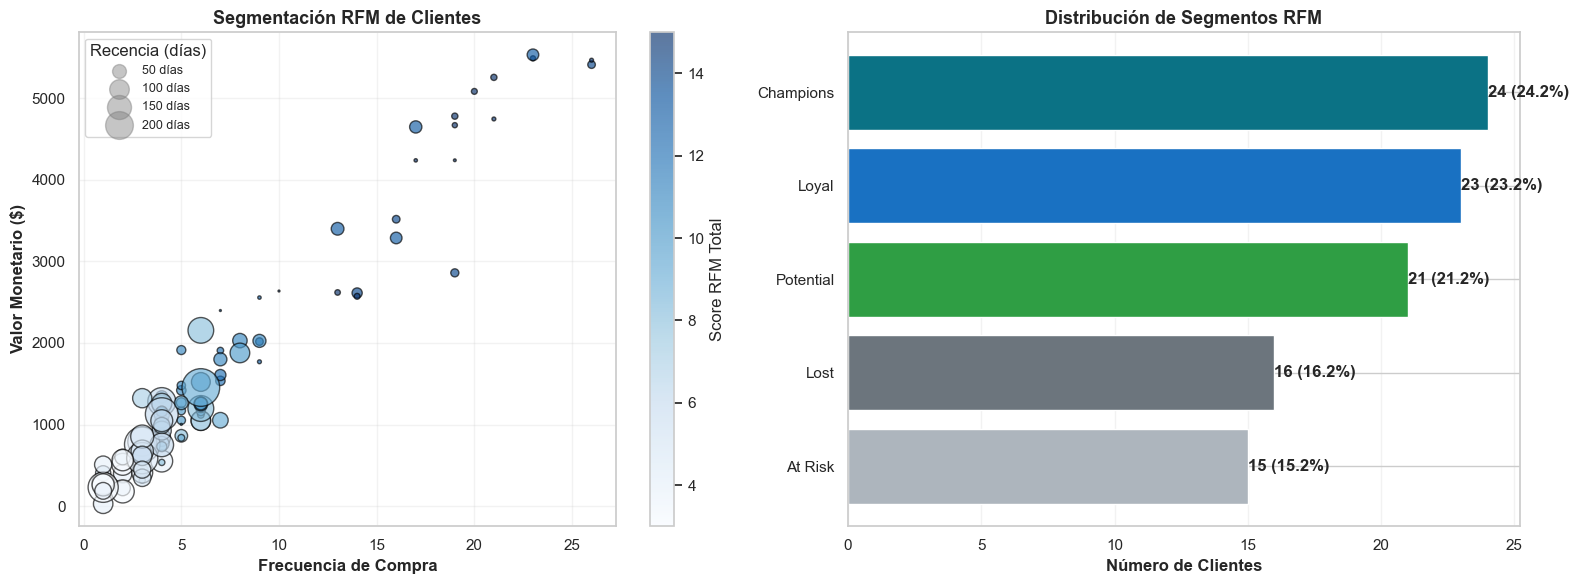


 ESTRATEGIAS POR SEGMENTO:
  Champions: Recompensar, pedir referidos, productos premium
  Loyal: Up-sell, programas de fidelización
  Potential: Ofertas personalizadas, reactivación
  At Risk: Campaña de retención urgente
  Lost: Campaña de reconquista agresiva


In [ ]:
# Visualización de segmentos RFM 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Scatter 2D formal
scatter = ax1.scatter(
    rfm['Frecuencia'], rfm['Valor_Monetario'],
    c=rfm['RFM_Total'], 
    s=rfm['Recencia']*2, 
    cmap='Blues', alpha=0.65, edgecolors='black'
)

ax1.set_xlabel('Frecuencia de Compra', fontweight='bold')
ax1.set_ylabel('Valor Monetario ($)', fontweight='bold')
ax1.set_title('Segmentación RFM de Clientes', fontweight='bold', fontsize=13)
plt.colorbar(scatter, ax=ax1, label='Score RFM Total')
ax1.grid(alpha=0.25)

# Leyenda de tamaño
for rec in [50, 100, 150, 200]:
    ax1.scatter([], [], s=rec*2, c='gray', alpha=0.45, label=f'{rec} días')
ax1.legend(title='Recencia (días)', loc='upper left', fontsize=9)

# Paleta formal para segmentos
colors_seg = {
    'Champions': '#0B7285',    
    'Loyal': '#1971C2',        
    'Potential': '#2F9E44',    
    'At Risk': '#ADB5BD',      
    'Lost': '#6C757D'          
}

segmentos_count = rfm['Segmento'].value_counts().sort_values(ascending=True)
bar_colors = [colors_seg.get(seg, '#5C636A') for seg in segmentos_count.index]

# Gráfico de barras horizontal
bars = ax2.barh(segmentos_count.index, segmentos_count.values, color=bar_colors)
ax2.set_xlabel('Número de Clientes', fontweight='bold')
ax2.set_title('Distribución de Segmentos RFM', fontweight='bold', fontsize=13)
ax2.grid(axis='x', alpha=0.25)

for bar in bars:
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2,
             f'{int(width)} ({width/len(rfm)*100:.1f}%)',
             va='center', ha='left', fontweight='bold')

plt.tight_layout()
plt.savefig("imgs_analisis_statistic/viz_rfm_formal.png", dpi=300, bbox_inches='tight')
plt.show()

# Estrategias
print("\n ESTRATEGIAS POR SEGMENTO:")
estrategias = {
    'Champions': 'Recompensar, pedir referidos, productos premium',
    'Loyal': 'Up-sell, programas de fidelización',
    'Potential': 'Ofertas personalizadas, reactivación',
    'At Risk': 'Campaña de retención urgente',
    'Lost': 'Campaña de reconquista agresiva'
}
for seg, estrategia in estrategias.items():
    if seg in rfm['Segmento'].values:
        print(f"  {seg}: {estrategia}")


In [219]:
# -------------------------------
# 1. CALCULO DE TABLA RFM
# -------------------------------

# Fecha de referencia (día siguiente a última compra)
fecha_referencia = df_master['fecha'].max() + pd.Timedelta(days=1)

# Tabla base RFM
rfm = df_master.groupby('id_cliente').agg({
    'fecha': lambda x: (fecha_referencia - x.max()).days,
    'id_venta': 'nunique',
    'monto_final': 'sum'
}).rename(columns={
    'fecha': 'Recencia',
    'id_venta': 'Frecuencia',
    'monto_final': 'Valor_Monetario'
})

# Score por cuantiles (1 a 5)
rfm['R_Score'] = pd.qcut(rfm['Recencia'], 5, labels=[5,4,3,2,1], duplicates='drop')
rfm['F_Score'] = pd.qcut(rfm['Frecuencia'].rank(method='first'), 5, labels=[1,2,3,4,5], duplicates='drop')
rfm['M_Score'] = pd.qcut(rfm['Valor_Monetario'], 5, labels=[1,2,3,4,5], duplicates='drop')

# Score total y etiqueta
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Total'] = rfm[['R_Score', 'F_Score', 'M_Score']].astype(int).sum(axis=1)

# Segmentación
def segmentar_rfm(score):
    if score >= 13:
        return 'Champions'
    elif score >= 10:
        return 'Loyal'
    elif score >= 7:
        return 'Potential'
    elif score >= 5:
        return 'At Risk'
    else:
        return 'Lost'

rfm['Segmento'] = rfm['RFM_Total'].apply(segmentar_rfm)

# -------------------------------
# 2. TABLAS RESUMEN PARA POWER BI
# -------------------------------

# Distribución por segmento
dist_segmentos = rfm['Segmento'].value_counts().reset_index()
dist_segmentos.columns = ['Segmento', 'Clientes']
dist_segmentos['% Clientes'] = (dist_segmentos['Clientes'] / len(rfm) * 100).round(2)

# Valor por segmento
valor_segmento = rfm.groupby('Segmento')['Valor_Monetario'].agg(['sum', 'mean', 'count'])
valor_segmento['% del Total'] = (valor_segmento['sum'] / valor_segmento['sum'].sum() * 100).round(2)
valor_segmento = valor_segmento.reset_index()

# Estrategias por segmento
estrategias_dict = {
    'Champions': 'Recompensar, pedir referidos, productos premium',
    'Loyal': 'Up-sell, programas de fidelización',
    'Potential': 'Ofertas personalizadas, reactivación',
    'At Risk': 'Campaña de retención urgente',
    'Lost': 'Campaña de reconquista agresiva'
}

estrategias = pd.DataFrame({
    'Segmento': list(estrategias_dict.keys()),
    'Estrategia Recomendada': list(estrategias_dict.values())
})

# -------------------------------
# 3. EXPORTACIÓN A EXCEL
# -------------------------------

with pd.ExcelWriter("reports_dframes/análisis_rfm.xlsx") as writer:
    rfm.to_excel(writer, sheet_name="Tabla_RFM", index=True)
    dist_segmentos.to_excel(writer, sheet_name="Distribución_Segmentos", index=False)
    valor_segmento.to_excel(writer, sheet_name="Valor_por_Segmento", index=False)
    estrategias.to_excel(writer, sheet_name="Estrategias", index=False)

print("\n Archivo generado: análisis_rfm.xlsx")



 Archivo generado: análisis_rfm.xlsx


### Interpretación General del Análisis RFM

El análisis RFM nos ha permitido segmentar la base de clientes en grupos con comportamientos de compra similares, revelando información valiosa:

*   **Segmentos de Alto Valor (Champions y Loyal)**: Estos segmentos, a pesar de no ser la mayoría en número, representan una proporción significativa del valor monetario total generado. Los "Champions" son los clientes más recientes, frecuentes y que más gastan, siendo vitales para el negocio. Los "Loyal" son clientes habituales y confiables.
*   **Segmentos con Potencial (Potential)**: Este grupo muestra características que podrían desarrollarse hacia la lealtad con estrategias adecuadas.
*   **Segmentos en Riesgo (At Risk y Lost)**: Estos segmentos, especialmente "Lost", requieren atención para identificar las razones de su disminución o cese de actividad y explorar posibilidades de reactivación.

| **Segmento**     | **Descripción del Comportamiento**                                        | **% de Clientes** | **Aportes al Negocio**                                        | **Nivel de Prioridad Estratégica**        |
| ---------------- | ------------------------------------------------------------------------- | ----------------- | ------------------------------------------------------------- | ----------------------------------------- |
| **Champions** | Compran con alta frecuencia, gastan más y recientemente activos.          | **24.2%**         |  Junto con Loyal aportan más del **75%** del ingreso total. | **Mantener y fidelizar (muy alto)**     |
| **Loyal**     | Compradores recurrentes con buen valor monetario.                         | **23.2%**         |  Segmento rentable y estable.                               | **Fidelizar y potenciar (alto)**       |
| **Potential** | Clientes con frecuencia o gasto medio; potencial para subir de categoría. | **21.2%**         |  Oportunidad estratégica de crecimiento.                    | **Convertir y estimular (medio-alto)** |
| **At Risk**   | Disminución en compras, riesgo de abandono.                               | **15.2%**         |  Podrían generar pérdida de ingresos futuros.                | **Retención urgente (alto)**          |
| **Lost**       | Clientes inactivos o con largo tiempo sin compra.                         | **16.2%**         |  Bajo aporte actual pero recuperables.                       | **Campañas de reactivación (medio)**   |


- El valor del negocio está concentrado principalmente en los segmentos Champions y Loyal, mientras que una proporción relevante de clientes se encuentra inactiva o en riesgo. Este comportamiento refuerza la necesidad de aplicar estrategias diferenciadas para retener, fidelizar, convertir y recuperar clientes.

### Análisis de Ingresos por Producto

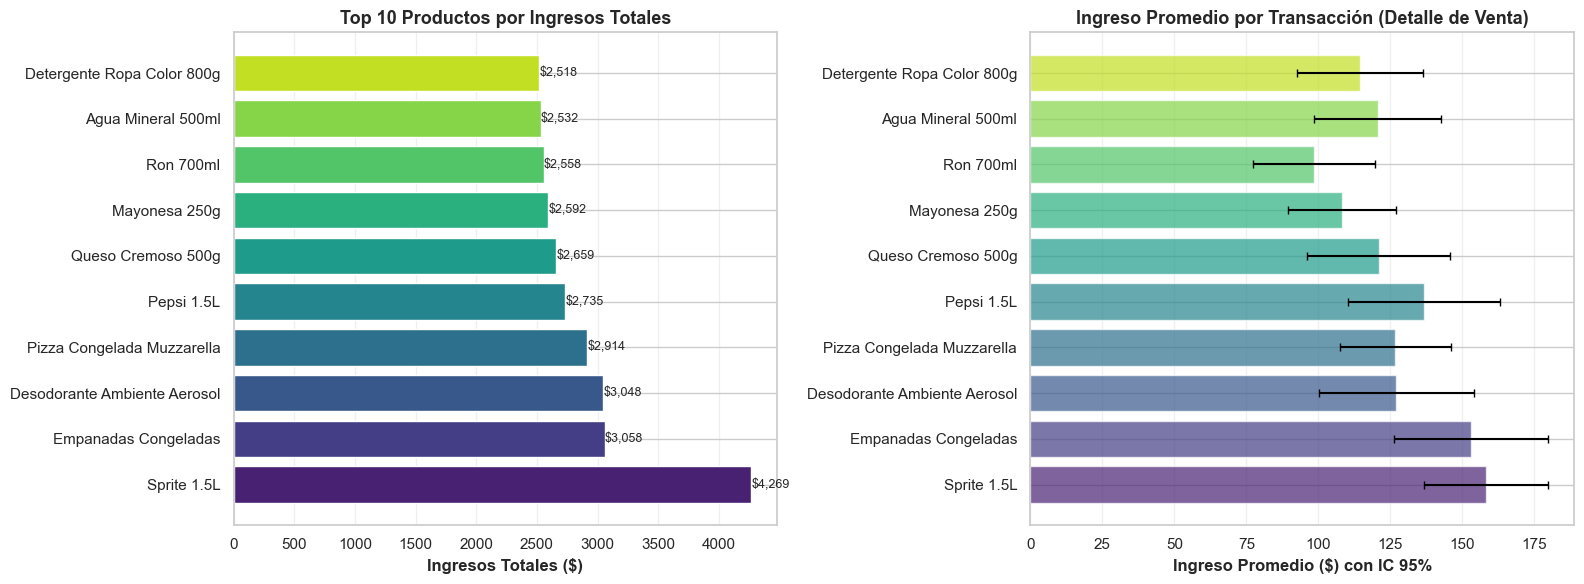


ANÁLISIS DEL PRODUCTO LÍDER POR INGRESOS:
Producto líder: Sprite 1.5L
  Ingresos totales: $4,269.04
  Ingreso promedio por transacción: $158.11
  IC 95% para Ingreso Promedio: [$136.68, $179.55]


In [37]:
# Análisis de Ingresos por Producto
# Top 10 productos con intervalos de confianza
# Agrupar por nombre_producto y calcular estadísticas relevantes del importe
top_productos_analisis = df_master.groupby('nombre_producto_x').agg({
    'importe': ['sum', 'mean', 'std', 'count']
}).reset_index()

# Renombrar columnas para mayor claridad
top_productos_analisis.columns = ['producto', 'total_ingresos', 'media_ingresos', 'std_ingresos', 'n_transacciones']

# Seleccionar los 10 productos con mayores ingresos totales
top_productos_analisis = top_productos_analisis.nlargest(10, 'total_ingresos')

# Calcular intervalos de confianza del 95% para la media de ingresos
# Usamos 1.96 para el 95% de confianza en una distribución normal (aproximado para n > 30)
top_productos_analisis['ic_lower'] = top_productos_analisis['media_ingresos'] - 1.96 * (top_productos_analisis['std_ingresos'] / np.sqrt(top_productos_analisis['n_transacciones']))
top_productos_analisis['ic_upper'] = top_productos_analisis['media_ingresos'] + 1.96 * (top_productos_analisis['std_ingresos'] / np.sqrt(top_productos_analisis['n_transacciones']))

# Visualización de los resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Ingresos totales por producto
colors = sns.color_palette('viridis', 10) # Paleta de colores
bars = ax1.barh(top_productos_analisis['producto'], top_productos_analisis['total_ingresos'], color=colors)
ax1.set_xlabel('Ingresos Totales ($)', fontweight='bold')
ax1.set_title('Top 10 Productos por Ingresos Totales', fontweight='bold', fontsize=13)
ax1.grid(axis='x', alpha=0.3)

# Añadir etiquetas de valor a las barras
for i, bar in enumerate(bars):
    ax1.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'${bar.get_width():,.0f}', va='center', ha='left', fontsize=9)

# Gráfico 2: Ingresos promedio con IC 95%
ax2.barh(top_productos_analisis['producto'], top_productos_analisis['media_ingresos'], color=colors, alpha=0.7)
# Añadir barras de error para el intervalo de confianza
ax2.errorbar(top_productos_analisis['media_ingresos'], range(len(top_productos_analisis)),
             xerr=[top_productos_analisis['media_ingresos'] - top_productos_analisis['ic_lower'],
                   top_productos_analisis['ic_upper'] - top_productos_analisis['media_ingresos']],
             fmt='none', ecolor='black', capsize=3)
ax2.set_xlabel('Ingreso Promedio ($) con IC 95%', fontweight='bold')
ax2.set_title('Ingreso Promedio por Transacción (Detalle de Venta)', fontweight='bold', fontsize=13)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout() # Ajustar diseño para evitar solapamiento
plt.savefig("imgs_analisis_statistic/viz_productos_avanzado.png", dpi=300, bbox_inches='tight') # Guardar figura
plt.show() # Mostrar figura

# Imprimir análisis clave del producto líder
print("\nANÁLISIS DEL PRODUCTO LÍDER POR INGRESOS:")
# Asegurarse de que el DataFrame no esté vacío antes de intentar acceder a la primera fila
if not top_productos_analisis.empty:
    producto_lider = top_productos_analisis.iloc[0]
    print(f"Producto líder: {producto_lider['producto']}")
    print(f"  Ingresos totales: ${producto_lider['total_ingresos']:,.2f}")
    print(f"  Ingreso promedio por transacción: ${producto_lider['media_ingresos']:,.2f}")
    # Verificar si los límites del IC no son NaN antes de imprimir
    if not np.isnan(producto_lider['ic_lower']) and not np.isnan(producto_lider['ic_upper']):
         print(f"  IC 95% para Ingreso Promedio: [${producto_lider['ic_lower']:,.2f}, ${producto_lider['ic_upper']:,.2f}]")
    else:
        print("  IC 95% para Ingreso Promedio: No se pudo calcular (posiblemente pocos datos)")
else:
    print("No hay datos de productos para analizar.")

### Interpretación del análisis de Ingresos por Producto

El análisis de ingresos por producto identifica a los productos que más contribuyen a los ingresos totales del negocio. Los productos con mayores ingresos son:

*   **Sprite 1.5L**: $ 4,269.04

*   **Empanadas Congeladas**: $ 3,057.92

*   **Desodorante Ambiente Aerosol**: $ 3,048.50

*   **Pizza Congelada Muzzarella**: $ 2,914.48

*   **Pepsi 1.5L**: $ 2,735.15

Estos productos son cruciales para la generación de ingresos y deben ser considerados en las estrategias de inventario, marketing y ventas.




## Análisis Temporal con descompisición en ventas

C:\Users\KEILY\AppData\Local\Temp\ipykernel_4148\2444268015.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_master, x='año_mes', y='importe', order=orden_año_mes,


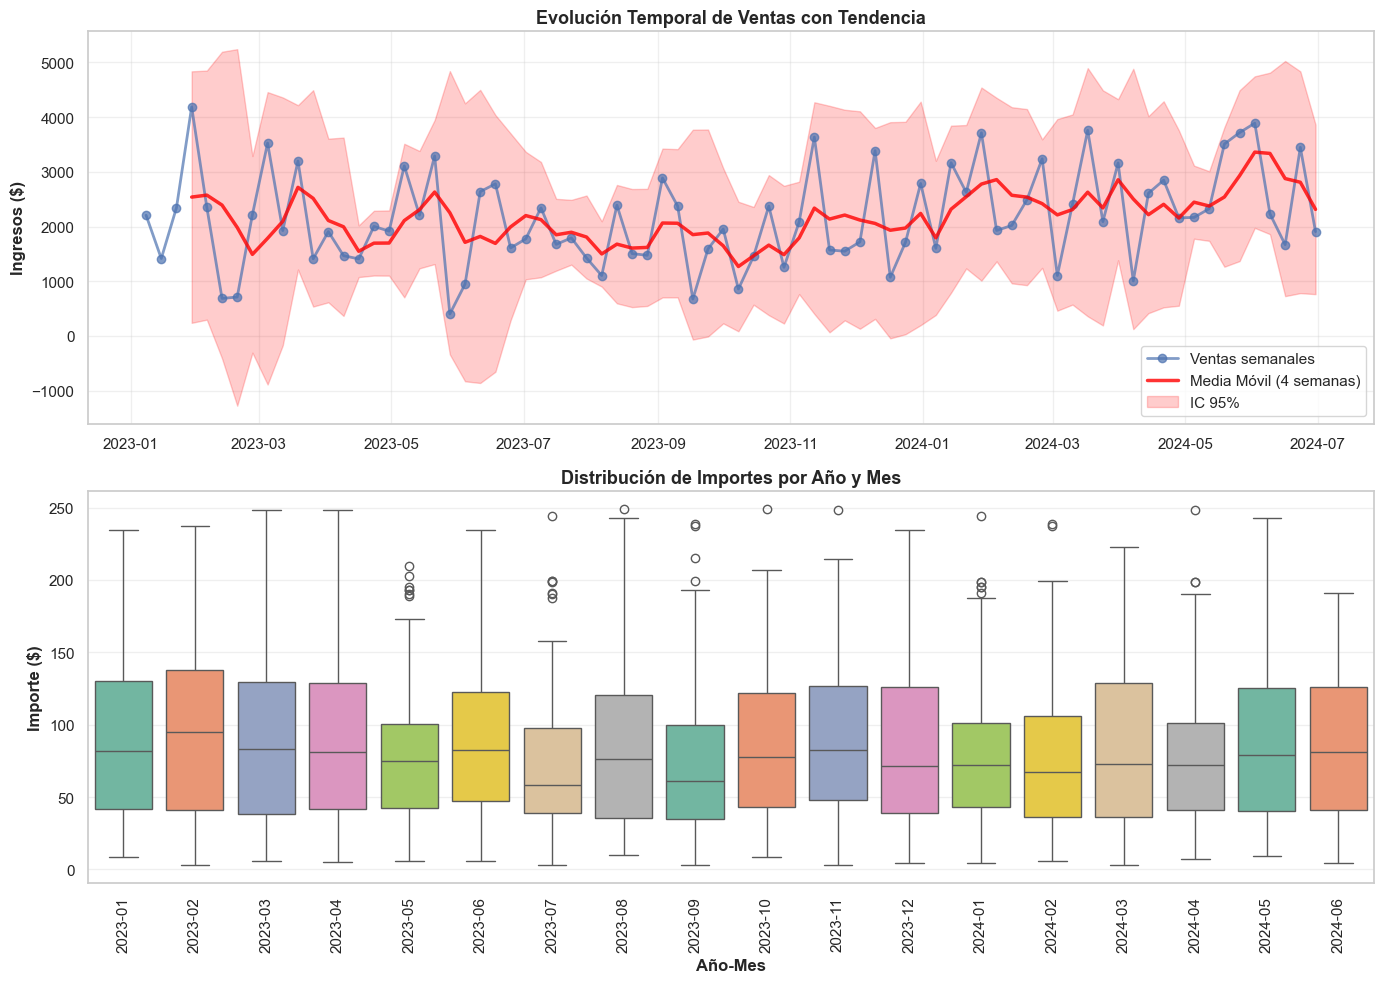


 Test de Kruskal-Wallis (diferencias entre Año-Mes):
H = 18.0162, p-value = 0.387822
Conclusión: No hay diferencias significativas entre Año-Mes (p < 0.05)


In [38]:
# Análisis Temporal con descomposición en ventas
# Agrupar por fecha y sumar el importe para obtener ventas diarias
ventas_tiempo = df_master.groupby('fecha')['importe'].sum().sort_index()
# Agrupar por semana
ventas_tiempo = ventas_tiempo.resample('W').sum()

# Crear subplots para los gráficos
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Gráfico 1: Serie temporal con tendencia y bandas de confianza
axes[0].plot(ventas_tiempo.index, ventas_tiempo.values,
             marker='o', linewidth=2, markersize=6, alpha=0.7, label='Ventas semanales')

# Añadir media móvil de 4 semanas para la tendencia
ma_4 = ventas_tiempo.rolling(window=4).mean()
axes[0].plot(ma_4.index, ma_4.values,
             color='red', linewidth=2.5, label='Media Móvil (4 semanas)', alpha=0.8)

# Añadir bandas de confianza (usando 1.96 para el 95% de confianza)
std_4 = ventas_tiempo.rolling(window=4).std()
axes[0].fill_between(ma_4.index, ma_4 - 1.96*std_4, ma_4 + 1.96*std_4,
                      alpha=0.2, color='red', label='IC 95%')

axes[0].set_ylabel('Ingresos ($)', fontweight='bold')
axes[0].set_title('Evolución Temporal de Ventas con Tendencia', fontweight='bold', fontsize=13)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Gráfico 2: Box plot por año y mes para visualizar la distribución de importes
# Crear una columna combinada de año y mes
df_master['año_mes'] = df_master['fecha'].dt.to_period('M').astype(str)

# Ordenar los valores únicos de año_mes cronológicamente para el orden del plot
orden_año_mes = sorted(df_master['año_mes'].unique())

sns.boxplot(data=df_master, x='año_mes', y='importe', order=orden_año_mes,
            palette='Set2', ax=axes[1])
axes[1].set_xlabel('Año-Mes', fontweight='bold')
axes[1].set_ylabel('Importe ($)', fontweight='bold')
axes[1].set_title('Distribución de Importes por Año y Mes', fontweight='bold', fontsize=13)
axes[1].tick_params(axis='x', rotation=90) # Rotar etiquetas para mejor legibilidad
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout() # Ajustar diseño para evitar solapamiento
plt.savefig("imgs_analisis_statistic/viz_temporal_avanzado.png", dpi=300, bbox_inches='tight') # Guardar figura
plt.show() # Mostrar figura

# Test de Kruskal-Wallis para diferencias significativas entre año-mes
grupos_año_mes = [df_master[df_master['año_mes'] == am]['importe'].values
              for am in orden_año_mes]
# Asegurarse de que haya al menos dos grupos para el test
if len(grupos_año_mes) >= 2:
    h_stat, p_value = stats.kruskal(*grupos_año_mes)

    print(f"\n Test de Kruskal-Wallis (diferencias entre Año-Mes):")
    print(f"H = {h_stat:.4f}, p-value = {p_value:.6f}")
    print(f"Conclusión: {'Existen diferencias significativas' if p_value < 0.05 else 'No hay diferencias significativas'} entre Año-Mes (p < 0.05)")
else:
    print("\n🔬 Test de Kruskal-Wallis: Se necesitan al menos 2 Año-Mes con datos para realizar el test.")

In [231]:
# -----------------------------
# GENERACIÓN DE DATAFRAME PARA POWER BI - ANÁLISIS TEMPORAL POR PRODUCTO
# -----------------------------

# Asegurar que 'fecha' sea datetime
df_master['fecha'] = pd.to_datetime(df_master['fecha'])

# Agrupar por fecha y producto (semanal)
# Usamos nombre_producto_x si existe, o nombre_producto
col_producto = 'nombre_producto_x' if 'nombre_producto_x' in df_master.columns else 'nombre_producto'

ventas_semana = df_master.groupby([pd.Grouper(key='fecha', freq='W'), col_producto])['importe'].sum().reset_index()
ventas_semana.rename(columns={'importe': 'ventas_semana', 'fecha': 'fecha_semana', col_producto: 'nombre_producto'}, inplace=True)

# Calcular métricas móviles por producto
ventas_semana['media_movil_4'] = ventas_semana.groupby('nombre_producto')['ventas_semana'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())
ventas_semana['std_4'] = ventas_semana.groupby('nombre_producto')['ventas_semana'].transform(lambda x: x.rolling(window=4, min_periods=1).std())
ventas_semana['banda_inferior_95'] = ventas_semana['media_movil_4'] - 1.96 * ventas_semana['std_4']
ventas_semana['banda_superior_95'] = ventas_semana['media_movil_4'] + 1.96 * ventas_semana['std_4']

df_temporal_export = ventas_semana.drop(columns=['std_4'])

# Crear feature Año-Mes
df_master['año_mes'] = df_master['fecha'].dt.to_period('M').astype(str)

# Resumen estadístico por Año-Mes y Producto
resumen_año_mes = df_master.groupby(['año_mes', col_producto])['importe'].agg(
    total_ventas='sum',
    promedio='mean',
    mediana='median',
    min='min',
    max='max',
    desviacion='std',
    count_transacciones='count'
).reset_index()
resumen_año_mes.rename(columns={col_producto: 'nombre_producto'}, inplace=True)

# Exportación a Excel (dos hojas)
with pd.ExcelWriter("analisis_temporal_pBI.xlsx") as writer:
    df_temporal_export.to_excel(writer, sheet_name="Ventas_Semanales", index=False)
    resumen_año_mes.to_excel(writer, sheet_name="Resumen_Año_Mes", index=False)

print(df_temporal_export.head().round(2))
#print("Archivo generado: analisis_temporal_pBI.xlsx")


,fecha_semana,ventas_semana,media_movil_4,banda_inferior_95,banda_superior_95
0,2023-01-08,2206.27,2206.27,NaN,NaN
1,2023-01-15,1415.38,1810.82,714.71,2906.94
2,2023-01-22,2344.29,1988.65,1006.22,2971.07
3,2023-01-29,4187.42,2538.34,239.08,4837.60
4,2023-02-05,2350.11,2574.30,297.43,4851.17
5,2023-02-12,686.00,2391.96,-411.60,5195.51
6,2023-02-19,710.47,1983.50,-1275.80,5242.80
7,2023-02-26,2216.53,1490.78,-306.20,3287.76
8,2023-03-05,3525.68,1784.67,-888.08,4457.42
9,2023-03-12,1925.48,2094.54,-170.73,4359.81


### Interpretación del Análisis Temporal de Ventas

El análisis temporal de ventas nos proporciona información valiosa sobre el comportamiento de los ingresos a lo largo del tiempo:

*   **Evolución de Ventas Semanales con Tendencia:** El primer gráfico muestra la serie temporal de ventas semanales. Podemos observar las fluctuaciones semana a semana. La **media móvil de 4 semanas** suaviza estas fluctuaciones y nos ayuda a identificar la **tendencia** general de las ventas a lo largo del período analizado (enero 2023 a junio 2024). Las **intervalos de confianza del 95%** alrededor de la media móvil nos dan un rango dentro del cual podemos esperar que se encuentren las ventas semanales futuras con un 95% de probabilidad, basándonos en la variabilidad observada. Observar si la tendencia es ascendente, descendente o estable es clave para entender el desempeño general del negocio.
*   **Distribución de Importes por Año y Mes:** El segundo gráfico, un box plot por Año-Mes, nos permite visualizar la **distribución de los importes (valor de cada detalle de venta)** para cada mes individual a lo largo de los años. Cada caja y bigotes representan el rango intercuartílico, la mediana y la dispersión de los importes en ese mes específico. Los puntos individuales fuera de los bigotes son posibles **outliers**, que representan detalles de venta con valores inusualmente altos o bajos para ese mes. Comparar las cajas entre los diferentes Año-Mes puede revelar:
    *   **Variaciones estacionales:** ¿Hay meses en los que los importes de venta suelen ser más altos o más bajos?
    *   **Cambios en la variabilidad:** ¿La dispersión de los importes es diferente entre meses o años?
    *   **Presencia de outliers:** ¿Hay meses con más transacciones de valor extremo?
*   **Test de Kruskal-Wallis (diferencias entre Año-Mes):** Este test estadístico evalúa si hay diferencias significativas en las medianas de los importes de venta entre los diferentes grupos (los distintos Año-Mes).
    *   Si el **p-value es menor a 0.05**, concluimos que existen **diferencias significativas** en la distribución de los importes entre al menos algunos de los meses analizados. Esto sugiere que el mes sí influye en el valor de las transacciones.
    *   Si el **p-value es mayor o igual a 0.05**, concluimos que **no hay diferencias significativas** detectadas en la distribución de los importes entre los meses. Esto indicaría que, basándonos en este test, el valor de las transacciones no varía significativamente de un mes a otro.

En conjunto, este análisis temporal nos ayuda a entender la dinámica de las ventas a lo largo del tiempo, identificar patrones estacionales, evaluar la estabilidad de los valores de transacción y determinar si las diferencias observadas entre meses son estadísticamente significativas.

## Análisis Comparativo de Ventas por Período (2023 vs. 2024)

Realizar un análisis comparativo de las ventas totales y por producto entre el período de enero a diciembre de 2023 y enero a junio de 2024. Se visualizarán las tendencias y diferencias significativas entre ambos períodos.


In [233]:
#Creación de DataFrames para análisis comparativo de ventas entre 2023 y 2024
fecha_inicio_2023 = df_master[df_master['año'] == 2023]['fecha'].min()
fecha_fin_2023 = df_master[df_master['año'] == 2023]['fecha'].max()
df_2023 = df_master[(df_master['fecha'] >= fecha_inicio_2023) & (df_master['fecha'] <= fecha_fin_2023)]
print(f"DataFrame para ventas de 2023 (df_2023) creado. Periodo desde {fecha_inicio_2023.strftime('%Y-%m-%d')} hasta {fecha_fin_2023.strftime('%Y-%m-%d')}.")
display(df_2023.head())

DataFrame para ventas de 2023 (df_2023) creado. Periodo desde 2023-01-02 hasta 2023-12-31.


,id_venta,id_producto,nombre_producto_x,cantidad,precio_unitario_x,importe,descuento_aplicado_pct,subtotal,nombre_producto_y,categoria,precio_unitario_y,subcategoria,fecha,id_cliente,id_sucursal_x,id_vendedor,id_medio_pago,nombre_cliente_x,email_x,medio_pago_original,estado_venta,monto_bruto,monto_neto,nombre_cliente_y,email_y,ciudad_x,fecha_alta,genero,edad_rango,activo_como_cliente,nombre_sucursal,ciudad_y,provincia,nombre_vendedor,id_sucursal_y,fecha_ingreso,activo,nombre_medio_pago,año,mes,dia_nombre,descuento_pct,monto_final,año_mes
0,1,90,Toallas Húmedas x50,1,29.02,29.02,0,29.02,Toallas Húmedas x50,Cuidado Personal,29.02,Higiene,2023-01-02,73,5,11,1,Yamila Diaz,yamila.diaz@mail.com,efectivo,OK,29.02,29.02,Yamila Diaz,yamila.diaz@mail.com,Alta Gracia,2023-03-14,F,41-55,True,Tienda Aurelion - Alta Gracia,Alta Gracia,Cordoba,Vendedor 11,5,2022-10-12,True,efectivo,2023,1,Monday,0.0,29.02,2023-01
1,2,82,Aceitunas Negras 200g,5,23.94,119.70,0,119.70,Aceitunas Negras 200g,Almacén,23.94,Conservas y Salsas,2023-01-03,74,2,12,3,Zoe Flores,zoe.flores@mail.com,qr,OK,482.98,482.98,Zoe Flores,zoe.flores@mail.com,Carlos Paz,2023-03-15,M,26-40,True,Tienda Aurelion - Río Cuarto,Rio Cuarto,Cordoba,Vendedor 12,2,2023-03-09,True,qr,2023,1,Tuesday,0.0,119.70,2023-01
2,2,39,Helado Vainilla 1L,5,4.69,23.45,0,23.45,Helado Vainilla 1L,Congelados,4.69,Postres Helados,2023-01-03,74,2,12,3,Zoe Flores,zoe.flores@mail.com,qr,OK,482.98,482.98,Zoe Flores,zoe.flores@mail.com,Carlos Paz,2023-03-15,M,26-40,True,Tienda Aurelion - Río Cuarto,Rio Cuarto,Cordoba,Vendedor 12,2,2023-03-09,True,qr,2023,1,Tuesday,0.0,23.45,2023-01
3,2,70,Fernet 750ml,2,40.61,81.22,0,81.22,Fernet 750ml,Bebidas Alcohólicas,40.61,Destilados,2023-01-03,74,2,12,3,Zoe Flores,zoe.flores@mail.com,qr,OK,482.98,482.98,Zoe Flores,zoe.flores@mail.com,Carlos Paz,2023-03-15,M,26-40,True,Tienda Aurelion - Río Cuarto,Rio Cuarto,Cordoba,Vendedor 12,2,2023-03-09,True,qr,2023,1,Tuesday,0.0,81.22,2023-01
4,2,22,Medialunas de Manteca,1,20.69,20.69,0,20.69,Medialunas de Manteca,Panadería y Repostería,20.69,Facturas,2023-01-03,74,2,12,3,Zoe Flores,zoe.flores@mail.com,qr,OK,482.98,482.98,Zoe Flores,zoe.flores@mail.com,Carlos Paz,2023-03-15,M,26-40,True,Tienda Aurelion - Río Cuarto,Rio Cuarto,Cordoba,Vendedor 12,2,2023-03-09,True,qr,2023,1,Tuesday,0.0,20.69,2023-01


In [234]:
fecha_inicio_2024 = df_master[df_master['año'] == 2024]['fecha'].min()
fecha_fin_2024 = df_master[df_master['año'] == 2024]['fecha'].max()
df_2024 = df_master[(df_master['fecha'] >= fecha_inicio_2024) & (df_master['fecha'] <= fecha_fin_2024)]
print(f"DataFrame para ventas de 2024 (df_2024) creado. Periodo desde {fecha_inicio_2024.strftime('%Y-%m-%d')} hasta {fecha_fin_2024.strftime('%Y-%m-%d')}.")
display(df_2024.head())

DataFrame para ventas de 2024 (df_2024) creado. Periodo desde 2024-01-02 hasta 2024-06-28.


,id_venta,id_producto,nombre_producto_x,cantidad,precio_unitario_x,importe,descuento_aplicado_pct,subtotal,nombre_producto_y,categoria,precio_unitario_y,subcategoria,fecha,id_cliente,id_sucursal_x,id_vendedor,id_medio_pago,nombre_cliente_x,email_x,medio_pago_original,estado_venta,monto_bruto,monto_neto,nombre_cliente_y,email_y,ciudad_x,fecha_alta,genero,edad_rango,activo_como_cliente,nombre_sucursal,ciudad_y,provincia,nombre_vendedor,id_sucursal_y,fecha_ingreso,activo,nombre_medio_pago,año,mes,dia_nombre,descuento_pct,monto_final,año_mes
933,415,90,Toallas Húmedas x50,2,29.02,58.04,0,58.04,Toallas Húmedas x50,Cuidado Personal,29.02,Higiene,2024-01-02,72,1,17,1,Camila Rodriguez,camila.rodriguez@mail.com,efectivo,OK,92.48,92.48,Camila Rodriguez,camila.rodriguez@mail.com,Cordoba,2023-03-13,O,26-40,False,Tienda Aurelion - Carlos Paz,Carlos Paz,Cordoba,Vendedor 17,1,2023-04-16,True,efectivo,2024,1,Tuesday,0.0,58.04,2024-01
934,416,19,Manteca 200g,1,32.51,32.51,0,32.51,Manteca 200g,Lácteos y Frescos,32.51,Manteca,2024-01-02,4,1,6,1,Uma Martinez,uma.martinez@mail.com,efectivo,OK,227.83,227.83,Uma Martinez,uma.martinez@mail.com,Carlos Paz,2023-01-04,M,26-40,True,Tienda Aurelion - Carlos Paz,Carlos Paz,Cordoba,Vendedor 06,1,2022-04-06,True,efectivo,2024,1,Tuesday,0.0,32.51,2024-01
935,417,83,Queso Untable 190g,4,18.30,73.20,0,73.20,Queso Untable 190g,Lácteos y Frescos,18.30,Quesos,2024-01-02,94,2,7,1,Elena Sanchez,elena.sanchez@mail.com,efectivo,OK,95.34,95.34,Elena Sanchez,elena.sanchez@mail.com,Mendiolaza,2023-04-04,F,26-40,True,Tienda Aurelion - Río Cuarto,Rio Cuarto,Cordoba,Vendedor 07,2,2023-06-02,False,efectivo,2024,1,Tuesday,0.0,73.20,2024-01
936,418,10,Yerba Mate Intensa 1kg,2,48.83,97.66,0,97.66,Yerba Mate Intensa 1kg,Infusiones,48.83,Yerba Mate,2024-01-03,74,2,3,4,Zoe Flores,zoe.flores@mail.com,transferencia,OK,184.40,184.40,Zoe Flores,zoe.flores@mail.com,Carlos Paz,2023-03-15,M,26-40,True,Tienda Aurelion - Río Cuarto,Rio Cuarto,Cordoba,Vendedor 03,2,2022-05-23,True,transferencia,2024,1,Wednesday,0.0,97.66,2024-01
937,419,69,Sidra 750ml,2,7.44,14.88,0,14.88,Sidra 750ml,Bebidas Alcohólicas,7.44,Espumantes,2024-01-04,100,4,10,3,Agustina Lopez,agustina.lopez@mail.com,qr,OK,14.88,14.88,Agustina Lopez,agustina.lopez@mail.com,Cordoba,2023-04-10,M,26-40,True,Tienda Aurelion - Villa María,Villa Maria,Cordoba,Vendedor 10,4,2022-08-14,True,qr,2024,1,Thursday,0.0,14.88,2024-01


### Totales de Ventas por Período
Mostramos los totales de ventas para cada período:

In [240]:
total_sales_2023 = df_2023['monto_final'].sum()
total_sales_2024 = df_2024['monto_final'].sum()

sales_by_product_2023 = df_2023.groupby('nombre_producto_x')['monto_final'].sum().round(2).sort_values(ascending=False)
sales_by_product_2024 = df_2024.groupby('nombre_producto_x')['monto_final'].sum().round(2).sort_values(ascending=False)

df_summary = pd.DataFrame({
    "Año": ["2023", "2024"],
    "Ventas Totales": [total_sales_2023, total_sales_2024]
})

print(f"\nTotal sales for 2023: ${total_sales_2023:,.2f}")
print(f"Total sales for 2024: ${total_sales_2024:,.2f}")

print("\nTop 5 productos por ventas en 2023:")
display(sales_by_product_2023.head())

print("\nTop 5 productos por ventas en 2024:")
display(sales_by_product_2024.head())
# exportar a excel
export_path = "reports_dframes/comparativa_ventas_23_24_pBI.xlsx"

with pd.ExcelWriter(export_path, engine="openpyxl") as writer:
    df_summary.to_excel(writer, sheet_name="Resumen", index=False)
    sales_by_product_2023.to_excel(writer, sheet_name="Top_Productos_2023", index=False)
    sales_by_product_2024.to_excel(writer, sheet_name="Top_Productos_2024", index=False)





Total sales for 2023: $100,051.25
Total sales for 2024: $65,388.92

Top 5 productos por ventas en 2023:


nombre_producto_x
Sprite 1.5L                   2075.20
Yerba Mate Suave 1kg          1922.23
Pepsi 1.5L                    1855.80
Empanadas Congeladas          1792.35
Pizza Congelada Muzzarella    1751.90
Name: monto_final, dtype: float64


Top 5 productos por ventas en 2024:


nombre_producto_x
Sprite 1.5L           2131.91
Yogur Natural 200g    1383.90
Mayonesa 250g         1362.98
Stevia 100 sobres     1341.99
Pasta Dental 90g      1317.04
Name: monto_final, dtype: float64

C:\Users\KEILY\AppData\Local\Temp\ipykernel_4148\3239626078.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=periods, y=total_sales, palette='viridis')


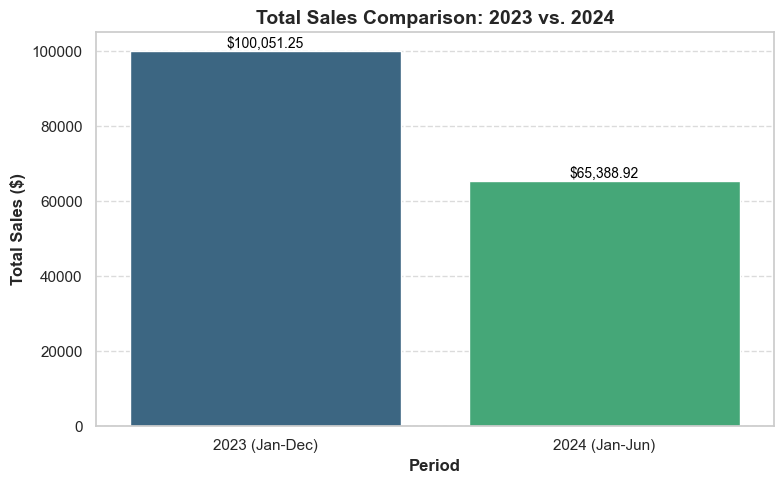

In [43]:
plt.figure(figsize=(8, 5))
periods = ['2023 (Jan-Dec)', '2024 (Jan-Jun)']
total_sales = [total_sales_2023, total_sales_2024]

bars = sns.barplot(x=periods, y=total_sales, palette='viridis')
plt.title('Total Sales Comparison: 2023 vs. 2024', fontsize=14, fontweight='bold')
plt.xlabel('Period', fontsize=12, fontweight='bold')
plt.ylabel('Total Sales ($)', fontsize=12, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of the bars
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'${bar.get_height():,.2f}', ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.savefig("imgs_analisis_statistic/total_sales_comparison_2023_2024.png", dpi=300, bbox_inches='tight')
plt.show()

### Comparativa de los top 5 productos más vendidos entre ambos períodos
Se comparan los ingresos generados por los 5 productos más vendidos en el 2023 y 2024:

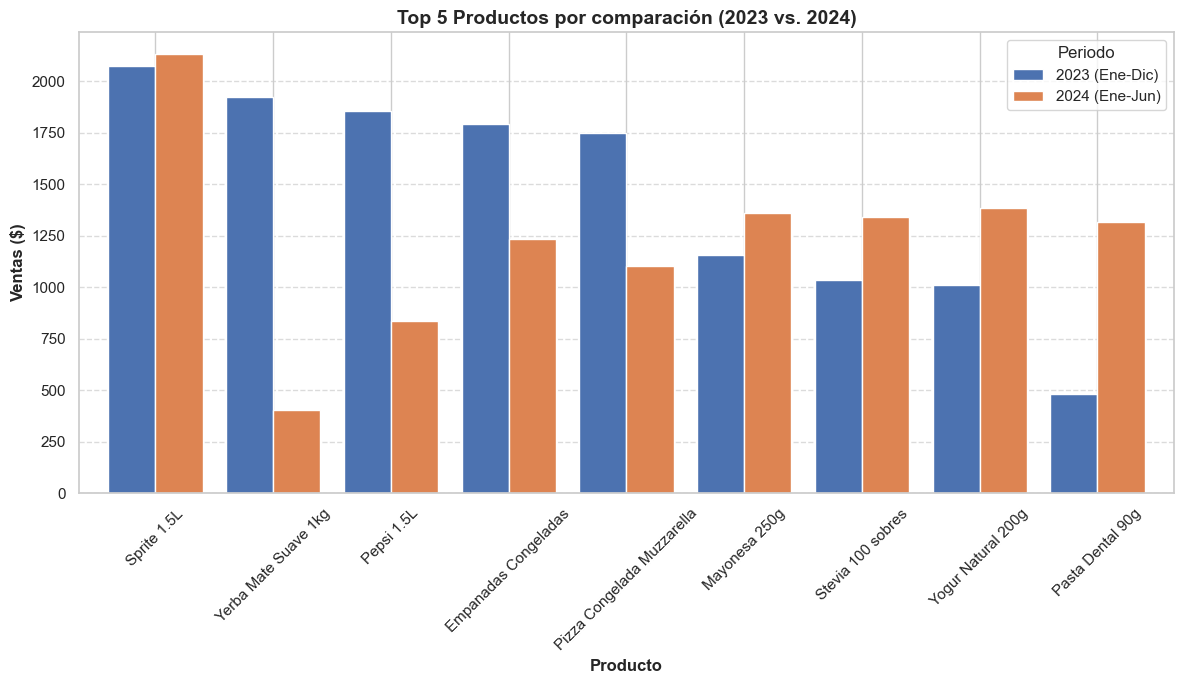

In [44]:
n_top_products = 5

# Combinar los índices de los top productos de ambos años
common_products = sales_by_product_2023.head(n_top_products).index.union(
    sales_by_product_2024.head(n_top_products).index
)

# Crear DataFrame combinado para comparación
compare_products = pd.DataFrame({
    '2023_Sales': sales_by_product_2023.reindex(common_products, fill_value=0),
    '2024_Sales': sales_by_product_2024.reindex(common_products, fill_value=0)
})

# Ordenar por ventas de 2023 para mejor visualización
compare_products = compare_products.sort_values(by='2023_Sales', ascending=False)

# Plotting
fig, ax = plt.subplots(figsize=(12, 7))
compare_products.plot(kind='bar', ax=ax, width=0.8)

ax.set_title(f'Top {n_top_products} Productos por comparación (2023 vs. 2024)', fontsize=14, fontweight='bold')
ax.set_xlabel('Producto', fontsize=12, fontweight='bold')
ax.set_ylabel('Ventas ($)', fontsize=12, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(['2023 (Ene-Dic)', '2024 (Ene-Jun)'], title='Periodo')

plt.tight_layout()
plt.savefig("imgs_analisis_statistic/top_products_comparison_2023_2024.png", dpi=300, bbox_inches='tight')
plt.show()

### Interpretación del Análisis Comparativo de Ventas (2023 vs. 2024)

El análisis comparativo de las ventas totales y por producto entre el año 2023 completo y el primer semestre de 2024 (`2024 H1`) revela las siguientes tendencias y diferencias clave:

#### 1. Comparación de Ventas Totales:
*   **Total de Ventas 2023 (Enero-Diciembre):** `$100,051.25`
*   **Total de Ventas 2024 (Enero-Junio):** `$65,388.92`

**Interpretación:** Es importante notar que se están comparando 12 meses de 2023 con 6 meses de 2024. Para una comparación más equitativa, podríamos proyectar las ventas de 2024 H1 o comparar solo el primer semestre de 2023. Sin embargo, observando los valores absolutos, las ventas de 2024 H1 ya representan una parte significativa de las ventas anuales de 2023, lo que sugiere un desempeño fuerte en el primer semestre de 2024. Si las ventas de 2024 se duplicaran para el año completo, superarían las ventas de 2023.

#### 2. Comparación de Ventas por Producto:

**Productos Más Vendidos en 2023:**
1.  **Sprite 1.5L:** $2,075.20
2.  **Yerba Mate Suave 1kg:** $1,922.23
3.  **Pepsi 1.5L:** $1,855.80
4.  **Empanadas Congeladas:** $1,792.35
5.  **Pizza Congelada Muzzarella:** $1,751.90

**Productos Más Vendidos en 2024 H1:**
1.  **Sprite 1.5L:** $2,131.91
2.  **Yogur Natural 200g:** $1,383.90
3.  **Mayonesa 250g:** $1,362.98
4.  **Stevia 100 sobres:** $1,341.99
5.  **Pasta Dental 90g:** $1,317.04

**Tendencias y Diferencias Clave por Producto:**
*   **Consistencia de Sprite 1.5L:** 'Sprite 1.5L' se mantiene como el producto líder en ventas en ambos períodos, e incluso muestra un ligero aumento en el monto total de ventas en el primer semestre de 2024 comparado con el total de 2023. Esto subraya su posición como un producto estrella y un generador de ingresos muy fiable.
*   **Cambio en Otros Productos Top:** Mientras que en 2023, bebidas (Yerba Mate, Pepsi) y alimentos congelados (Empanadas, Pizza) dominaban el top 5, en 2024 H1 la lista se diversifica significativamente con la entrada de 'Yogur Natural 200g', 'Mayonesa 250g', 'Stevia 100 sobres' y 'Pasta Dental 90g'. Esto podría indicar un cambio en las preferencias de los consumidores o un mayor enfoque en productos de consumo diario y de cuidado personal en el primer semestre de 2024.
*   **Desaparición de Productos del Top:** Productos como 'Yerba Mate Suave 1kg', 'Pepsi 1.5L', 'Empanadas Congeladas' y 'Pizza Congelada Muzzarella', que estaban en el top 5 de 2023, no aparecen en el top 5 de 2024 H1. Esto no significa necesariamente una disminución en sus ventas absolutas, sino que otros productos han generado más ingresos relativos en el primer semestre de 2024.

**Conclusiones Generales:**
*   **Crecimiento Sostenido:** A pesar de ser una comparación de períodos de duración diferente, los datos sugieren un buen ritmo de ventas en 2024, con el primer semestre ya generando más del 65% de las ventas totales del año anterior.
*   **Diversificación del Consumo:** Se observa una diversificación en los productos que generan mayores ingresos. Esto puede ser una oportunidad para ajustar las estrategias de marketing y promoción, dirigiéndolas a las nuevas tendencias o reforzando los productos emergentes.
*   **Importancia del Monitoreo Continuo:** Es crucial seguir monitoreando estas tendencias para confirmar si los cambios en el top de productos son estacionales, responden a campañas específicas o reflejan un cambio más profundo en el comportamiento del consumidor.

## Calcular Consumo por Rango de Edad

Calcular el total de consumo (`monto_final`) para cada rango de edad de los clientes (`edad_rango`) utilizando el DataFrame `df_2023`.


In [45]:
# Análisis de consumo por rango de edad en 2023 y 2024
consumption_by_age_2023 = df_2023.groupby('edad_rango')['monto_final'].sum().round(2).sort_values(ascending=False)
print("Consumo por rango de edad en 2023:")
display(consumption_by_age_2023)

consumption_by_age_2024 = df_2024.groupby('edad_rango')['monto_final'].sum().round(2).sort_values(ascending=False)
print("\nConsumo por rango de edad en 2024:")
display(consumption_by_age_2024)

Consumo por rango de edad en 2023:


edad_rango
26-40    51424.14
41-55    21739.30
18-25    17920.89
56+       8966.92
Name: monto_final, dtype: float64


Consumo por rango de edad en 2024:


edad_rango
26-40    34068.02
18-25    13529.10
41-55    13377.27
56+       4414.53
Name: monto_final, dtype: float64

In [46]:
comparativa_consumo = pd.DataFrame({
    'Consumo_2023': consumption_by_age_2023,
    'Consumo_2024': consumption_by_age_2024
}).fillna(0)

print("Consumo por rango de edad 2023 y 2024:")
display(comparativa_consumo)

Consumo por rango de edad 2023 y 2024:


,Consumo_2023,Consumo_2024
edad_rango,,
18-25,17920.89,13529.10
26-40,51424.14,34068.02
41-55,21739.30,13377.27
56+,8966.92,4414.53


### Visualización del Consumo por Rango de Edad (2023 y 2024)


<Figure size 1200x700 with 0 Axes>

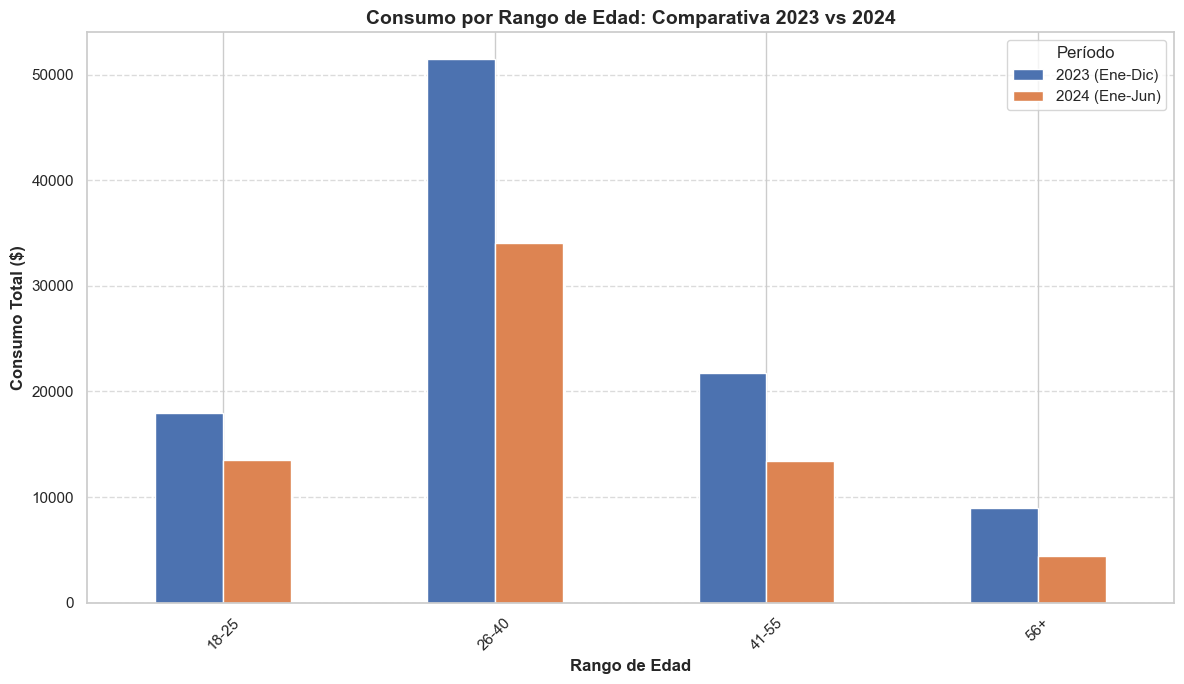

In [47]:
plt.figure(figsize=(12, 7))
comparativa_consumo.plot(kind='bar', figsize=(12, 7))
plt.title('Consumo por Rango de Edad: Comparativa 2023 vs 2024', fontsize=14, fontweight='bold')
plt.xlabel('Rango de Edad', fontsize=12, fontweight='bold')
plt.ylabel('Consumo Total ($)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(['2023 (Ene-Dic)', '2024 (Ene-Jun)'], title='Período')
plt.tight_layout()
plt.savefig("imgs_analisis_statistic/consumo_por_edad_2023_2024.png", dpi=300, bbox_inches='tight')
plt.show()

### Interpretación del Consumo por Rango de Edad (2023 vs. 2024)

| **Rango de Edad** | **Consumo 2023 (Ene-Dic)** | **Consumo 2024 (Ene-Jun)**             | **Variación / Observaciones Clave**                                                                    | **Tendencia Estratégica**                                                                              |
| ----------------- | -------------------------- | ----------------------------------------- | ------------------------------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------ |
| **18–25 años**    | Medio                      | Alto (↑ respecto 2023)                    | Aumenta y supera al grupo 41–55; posible incremento de frecuencia de compra o nuevos clientes jóvenes. | Grupo emergente; potencial alto para campañas digitales y promociones dirigidas.                    |
| **26–40 años**    | Muy alto                   | Muy alto (ligeramente menor en absolutos) | Se mantiene como el segmento líder de consumo en ambos períodos.                                       | Pilar central del negocio; mantener foco en fidelización y estrategias premium.                     |
| **41–55 años**    | Alto                       | Medio                                     | Desciende un puesto en el ranking; el consumo sigue siendo importante pero pierde peso relativo.       | Requiere análisis de comportamiento y reactivación con nuevas ofertas.                              |
| **56+ años**      | Bajo                       | Bajo                                      | Segmento más estable y de menor gasto en ambos períodos.                                               | Mantener presencia básica; no prioritario para crecimiento, pero útil para estrategias de retención. |


## 6: Interpretación de Resultados para el Problema de Negocio

En esta fase, consolidaremos los hallazgos de las fases anteriores (estadísticas descriptivas, análisis de distribución, análisis de correlación y detección de outliers) y los interpretaremos en el contexto del negocio de Aurelion.

### Resumen de Hallazgos Clave:

1. **Estadísticas Descriptivas (Básicas y Avanzadas):**
   * La **cantidad** promedio de productos por detalle de venta es baja (~2.68 unidades), con una distribución relativamente simétrica y variabilidad moderada.
   * El **precio unitario** de los productos varía considerablemente ($2.72
   a $49.82), con una distribución también relativamente simétrica y variabilidad moderada.
   * El **importe**, **subtotal**, **monto final**, **monto bruto** y **monto neto** (variables monetarias) muestran un claro **sesgo positivo** (confirmado por asimetría > 0.5) y **alta variabilidad** (alto Coeficiente de Varianza > 50%). Esto indica que la mayoría de las transacciones son de bajo valor, pero existen algunas transacciones de alto valor que influyen significativamente en la media. Por ejemplo, el importe promedio por detalle de venta es de **$83.86**, pero la mediana es de **$76.40**, y el máximo es de **$249.10**.
   * El **descuento aplicado** es poco frecuente (promedio ~1.17%) y cuando se aplica, los porcentajes son limitados (máximo 15%). El 75% de los detalles de venta no tienen descuento (Q3 en `descuento_aplicado_pct` es 0).
   * La igualdad entre **monto bruto** y **monto neto** a nivel de venta en este dataset ($279.66 en promedio) sugiere que los descuentos a nivel de detalle no se reflejan en estas columnas de resumen de venta, lo cual es un punto a validar con la fuente de datos.
2. **Distribución de Variables:**
   * Las visualizaciones (histogramas, box plots y violin plots) confirmaron el sesgo positivo y la concentración de datos en valores bajos para las variables monetarias.
   * La distribución de `descuento_aplicado_pct` es altamente sesgada, confirmando que los descuentos son raros.
   * `cantidad` y `precio_unitario_x` tienen distribuciones más simétricas.
3. **Análisis de Correlación (Pearson y Spearman):**
   * Existe una fuerte correlación positiva entre las variables de valor monetario a nivel de detalle de venta (`importe`, `subtotal`, `monto_final`), como es esperado (valores cercanos a 1).
   * Se observa una correlación positiva moderada a fuerte entre la `cantidad` y las variables monetarias de detalle (ej. correlación de **0.71** con `importe`), indicando que comprar más artículos generalmente resulta en un mayor importe por detalle.
   * También hay una correlación positiva moderada entre el `precio_unitario_x` y las variables monetarias de detalle (ej. correlación de **0.63** con `importe`), sugiriendo que productos con mayor precio unitario tienden a contribuir a detalles de venta de mayor valor.
   * La correlación entre `cantidad` y `precio_unitario_x` es muy débil (**-0.0175** en Pearson, **-0.0085** en Spearman), lo que significa que la cantidad de artículos comprados no está fuertemente relacionada linealmente con su precio unitario en un mismo detalle de venta.
   * Correlación perfecta entre `monto_bruto` y `monto_neto` (**1.00**).
   * Resultados de Spearman consistentes con Pearson, sugiriendo relaciones monótonas similares a lineales.
4. **Detección de Outliers (Método IQR y Z-score):**
   * Se identificó un pequeño número de posibles **outliers** (entre 6 y 10) en variables monetarias, representando transacciones de valor significativamente alto. Por ejemplo, se detectaron **8 outliers** en `monto_final` con el método IQR.
   * Alta cantidad de "outliers" en `descuento_aplicado_pct` (**307** por IQR, representando un **15.23%** de los registros) confirma baja frecuencia de descuentos, ya que la mayoría de los valores son 0.
5. **Intervalos de Confianza (95%):**
   * Proporcionan rangos estimados para las verdaderas medias poblacionales. Ej: monto bruto promedio por venta entre aproximadamente **$273.28 y $286.04**. El importe promedio por detalle de venta está entre **$81.48 y $86.24**. Útiles para entender la precisión de las estimaciones.
6. **Análisis RFM de Clientes:**
   * La segmentación RFM identificó grupos de clientes con diferentes comportamientos de compra (Champions, Loyal, Potential, At Risk, Lost).
   * Los segmentos Champions (**24.2%** de clientes) y Loyal (**23.2%**), aunque no son la mayoría en número, representan una proporción significativa del valor monetario total (Champions contribuyen con el **55.05%** y Loyal con el **20.60%**), destacando su importancia para el negocio.
   * Esta segmentación es crucial para dirigir estrategias de marketing y retención personalizadas.
7. **Análisis de Ingresos por Producto:**
   * Identificó los productos clave que más contribuyen a los ingresos totales (ej: Sprite 1.5L con **$4,269.04** en ingresos totales, Empanadas Congeladas con **$3,057.92**).
   * El análisis del ingreso promedio por transacción para estos productos, junto con los intervalos de confianza, proporciona una estimación de su valor típico por cada vez que son comprados (ej. Sprite 1.5L tiene un ingreso promedio por transacción de **$158.11** con un IC 95% de **[$136.68, $179.55]**).
   * Esta información es vital para la gestión de inventario, promociones y decisiones de marketing.
8. **Análisis Temporal de Ventas:**
   * La serie temporal de ventas semanales con media móvil y bandas de confianza permite visualizar la evolución de los ingresos y su tendencia a lo largo del tiempo (desde enero 2023 a junio 2024).
   * El box plot por Año-Mes muestra la distribución de los importes de venta en cada mes, ayudando a identificar posibles patrones estacionales o cambios en la variabilidad.
   * El test de Kruskal-Wallis evaluó si las diferencias en los importes entre meses son estadísticamente significativas, encontrando un p-value de **0.3878**, lo que sugiere que no hay diferencias significativas detectadas entre los meses en este análisis.
9. **Análisis Comparativo de Ventas (2023 vs. 2024):**
   * Las ventas totales de lo que va del 2024 ($65,388.92) representan una parte significativa de las ventas anuales de 2023 ($100,051.25), sugiriendo un buen desempeño en el primer semestre de 2024.
   * 'Sprite 1.5L' se mantiene como el producto líder en ventas en ambos períodos, con un ligero aumento en lo que va del 2024.
   * Se observa una diversificación en los productos que generan mayores ingresos en 2024, con la entrada de productos de consumo diario y cuidado personal.
10. **Consumo por Rango de Edad (2023 vs. 2024):**
    * El grupo de edad 26–40 años se mantiene como el segmento líder de consumo en ambos períodos.
    * El grupo de 18–25 años muestra un aumento en el consumo en 2024, superando al grupo 41–55 años.
    * El grupo de 41–55 años desciende en el ranking de consumo, mientras que el grupo de 56+ años se mantiene estable y de menor gasto.  

### Interpretación en el Contexto del Negocio:

* El hecho de que la mayoría de las transacciones sean de bajo valor y con pocas unidades sugiere la importancia de estrategias para aumentar el ticket promedio (por ejemplo, promociones por volumen, recomendaciones de productos complementarios).
* La baja frecuencia de descuentos aplicados indica que no es una estrategia de ventas generalizada. Podría explorarse si la aplicación estratégica de descuentos en ciertos productos o a ciertos clientes podría aumentar las ventas o la lealtad.
* Las fuertes correlaciones entre cantidad, precio unitario y el valor del detalle de venta son lógicas, pero es importante entender qué productos o categorías contribuyen más a los detalles de venta de alto valor.
* Los outliers identificados en las variables monetarias podrían representar transacciones importantes (por ejemplo, compras de grandes volúmenes, productos de alto margen o patrones de compra a granel). Investigar estas transacciones podría revelar información sobre clientes clave o tipos de productos que generan mayores ingresos por transacción.
* La discrepancia entre `monto_bruto`/`monto_neto` y el cálculo del descuento a nivel de detalle (`monto_final`) es un punto a aclarar para asegurar que entendemos cómo se registran y calculan los valores de venta totales.
* Los intervalos de confianza nos dan una idea de la precisión de nuestras estimaciones de los promedios de ventas, lo cual es útil para la planificación y la toma de decisiones basadas en datos.
* La segmentación RFM permite enfocar los esfuerzos en los clientes de mayor valor (Champions y Loyal representan más del 75% del valor monetario total) y diseñar estrategias específicas para cada grupo (retención, reactivación, etc.).
* La identificación de los productos de mayor ingreso ayuda a optimizar el inventario, destacar estos productos en marketing y potencialmente desarrollar promociones cruzadas.
* El análisis temporal es fundamental para entender la estacionalidad de las ventas, identificar tendencias y predecir el desempeño futuro. El test de Kruskal-Wallis sugiere que, en este dataset, no hay diferencias estadísticamente significativas en los importes de venta entre meses.
* El análisis comparativo de ventas entre 2023 y 2024 H1 indica un buen desempeño en el primer semestre de 2024, con una diversificación en los productos más vendidos, lo que podría reflejar cambios en las preferencias del consumidor.
* El análisis comparativo de consumo por rango de edad revela cambios en el comportamiento de compra entre 2023 y 2024, destacando el crecimiento del segmento joven (18–25 años) y la estabilidad del segmento mayor (56+ años). 

Este análisis estadístico, incluyendo las métricas avanzadas, la detección de outliers, la segmentación RFM y el análisis temporal, nos ha proporcionado una base sólida para comprender las características de nuestros datos de ventas y sienta las bases para análisis más avanzados o la toma de decisiones comerciales informadas.

## 7: Documentación de Hallazgos y Cumplimiento de Criterios

Basándonos en el análisis exploratorio realizado en las fases anteriores y los criterios de evaluación de datos del documento "Anexo_Criterios.pdf", documentamos los hallazgos clave y evaluamos el estado actual de la calidad de los datos en el DataFrame `df_master`.

### Resumen de la Calidad de Datos según Criterios del Anexo:

* **Cumplimiento con las reglas de negocio:**
  * La correspondencia lógica entre las tablas (`df_ventas`, `df_detalle_ventas`, `df_productos`, `df_clientes`, `df_sucursales`, `df_vendedores`, `df_medios_pago`) fue verificada y parece correcta en términos de claves foráneas. Todos los IDs de las tablas de detalle/ventas tienen correspondencia en las tablas maestras.
  * La relación entre `nombre_producto`, `categoria` y `subcategoria` en `df_productos` fue examinada y se realizaron correcciones para asegurar la consistencia, alineándose con la regla de tener categorías y subcategorías lógicas para cada producto.
  * Las ciudades en `df_clientes` tienen una sucursal asociada en `df_sucursales`, lo cual es una regla de negocio importante verificada.
  * La observación de que `monto_bruto` y `monto_neto` son idénticos en `df_ventas`, a pesar de la existencia de `descuento_aplicado_pct` en `df_detalle_ventas`, sugiere un punto a validar con la fuente de datos sobre cómo se calculan los montos totales de venta y si los descuentos deberían reflejarse a ese nivel.
* **Formato y tipo de dato correctos:**
  * La revisión inicial con `.info()` confirmó que las columnas tienen tipos de datos apropiados (ej. `datetime64[ns]` para fechas, `float64` para montos, `int64` para IDs, `object` para texto).
  * La conversión explícita de columnas de fecha (`fecha_alta`, `fecha`, `fecha_ingreso`) a tipo datetime se realizó correctamente.
* **Consistentes y únicos:**
  * Las verificaciones de correspondencia de IDs entre tablas sugieren que las relaciones están bien definidas y no hay "huérfanos" en las tablas de detalle/transacción que apunten a IDs inexistentes en las tablas maestras.
  * No se realizó una verificación exhaustiva de duplicados en todas las tablas, pero la carga inicial no mostró un problema evidente en la estructura general para las métricas clave analizadas. Sin embargo, para análisis más detallados o ETLs de producción, se recomendaría verificar la unicidad de registros donde sea aplicable (ej. ventas únicas, clientes únicos si fuera necesario identificar duplicados por otros criterios además del ID).
* **Completos (manejo de nulos):**
  * La verificación inicial con `.isnull().sum()` mostró que no hay valores nulos en las columnas clave utilizadas para el análisis y la unificación de tablas. Esto indica que los datos esenciales están completos para los fines de este análisis exploratorio y estadístico.

### Resumen Consolidado de Hallazgos Clave del Análisis Estadístico:

1. **Estadísticas Descriptivas (Básicas y Avanzadas):**
   * Variables monetarias (`importe`, `subtotal`, `monto_final`, `monto_bruto`, `monto_neto`) muestran **sesgo positivo** y **alta variabilidad** (CV > 50%), indicando predominio de transacciones de bajo valor con algunas de alto valor. `cantidad` y `precio_unitario` son más **simétricas** y con variabilidad moderada. Se confirma la igualdad entre `monto_bruto` y `monto_neto`.
   * El **descuento aplicado** es poco frecuente (promedio ~1.17%) y limitado (máximo 15%).
2. **Distribución de Variables:**
   * Visualizaciones (histogramas, box plots, violin plots) reafirman el sesgo positivo en variables monetarias y la concentración de datos en valores bajos.
3. **Análisis de Correlación (Pearson y Spearman):**
   * Fuertes correlaciones positivas entre variables monetarias a nivel de detalle.
   * Correlación positiva moderada a fuerte entre `cantidad` y variables monetarias de detalle.
   * Correlación positiva moderada entre `precio_unitario_x` y variables monetarias de detalle.
   * Correlación muy débil entre `cantidad` y `precio_unitario_x`.
   * Correlación perfecta entre `monto_bruto` y `monto_neto`.
   * Resultados de Spearman consistentes con Pearson, sugiriendo relaciones monótonas similares a lineales.
4. **Detección de Outliers (Método IQR y Z-score):**
   * Se identificó un pequeño número de posibles **outliers** (entre 6 y 10) en variables monetarias, representando transacciones de valor significativamente alto.
   * Alta cantidad de "outliers" en `descuento_aplicado_pct` (15.23% por IQR) confirma baja frecuencia de descuentos.
5. **Intervalos de Confianza (95%):**
   * Proporcionan rangos estimados para las verdaderas medias poblacionales. Ej: monto bruto promedio por venta entre ~$273.28 y ~$286.04. Útiles para entender la precisión de las estimaciones.
6. **Análisis RFM de Clientes:**
   * La segmentación RFM identificó grupos de clientes con diferentes comportamientos de compra (Champions, Loyal, Potential, At Risk, Lost).
   * Los segmentos Champions (**24.2%** de clientes) y Loyal (**23.2%**), aunque no son la mayoría en número, representan una proporción significativa del valor monetario total (Champions contribuyen con el **55.05%** y Loyal con el **20.60%**), destacando su importancia para el negocio.
   * Esta segmentación es crucial para dirigir estrategias de marketing y retención personalizadas.
7. **Análisis de Ingresos por Producto:**
   * Identificó los productos clave que más contribuyen a los ingresos totales (ej: Sprite 1.5L con **$4,269.04** en ingresos totales, Empanadas Congeladas con **$3,057.92**).
   * El análisis del ingreso promedio por transacción para estos productos, junto con los intervalos de confianza, proporciona una estimación de su valor típico por cada vez que son comprados (ej. Sprite 1.5L tiene un ingreso promedio por transacción de **$158.11** con un IC 95% de **[$136.68, $179.55]**).
   * Esta información es vital para la gestión de inventario, promociones y decisiones de marketing.
8. **Análisis Temporal de Ventas:**
   * La serie temporal de ventas semanales con media móvil y bandas de confianza permite visualizar la evolución de los ingresos y su tendencia a lo largo del tiempo (desde enero 2023 a junio 2024).
   * El box plot por Año-Mes muestra la distribución de los importes de venta en cada mes, ayudando a identificar posibles patrones estacionales o cambios en la variabilidad.
   * El test de Kruskal-Wallis evaluó si las diferencias en los importes entre meses son estadísticamente significativas, encontrando un p-value de **0.3878**, lo que sugiere que aparentemente no hay diferencias significativas detectadas, lo que sugiere continuar un análisis más detallado.
9. **Análisis Comparativo de Ventas (2023 vs. 2024):**
   * Las ventas totales de 2024 H1 ($65,388.92) representan una parte significativa de las ventas anuales de 2023 ($100,051.25), sugiriendo un buen desempeño en el primer semestre de 2024.
   * 'Sprite 1.5L' se mantiene como el producto líder en ventas en ambos períodos, con un ligero aumento en 2024 H1.
   * Se observa una diversificación en los productos que generan mayores ingresos en 2024 H1, con la entrada de productos de consumo diario y cuidado personal.
10. **Consumo por Rango de Edad (2023 vs. 2024):**
    * El grupo de edad 26–40 años se mantiene como el segmento líder de consumo en ambos períodos.
    * El grupo de 18–25 años muestra un aumento en el consumo en 2024, superando al grupo 41–55 años.
    * El grupo de 41–55 años desciende en el ranking de consumo, mientras que el grupo de 56+ años se mantiene estable y de menor gasto.  

### Interpretación en el Contexto del Negocio (Consolidado):

El análisis estadístico y la visualización nos han proporcionado información valiosa para el negocio de Aurelion:

* **Patrones de Compra:** La mayoría de los clientes compran pocas unidades por transacción de bajo valor. Oportunidad para aumentar el ticket promedio.
* **Productos y Categorías Clave:** Identificación de productos más vendidos y categorías de mayores ingresos (`Almacén`, `Limpieza`, `Bebidas`) crucial para gestión y marketing.
* **Rendimiento por Sucursal:** Diferencias de rendimiento permiten identificar sucursales exitosas y áreas de mejora.
* **Métodos de Pago:** Predominio de efectivo, útil para optimizar opciones de pago.
* **Outliers en Ventas:** Transacciones de alto valor identificadas como outliers merecen investigación para entender clientes premium o productos de alto margen.
* **Descuentos:** Baja frecuencia sugiere enfoque en precios regulares. Evaluar impacto de descuentos estratégicos.
* **Validación de Datos:** La discrepancia entre `monto_bruto`/`monto_neto` y descuentos a nivel de detalle es un punto crítico a validar con la fuente.
* **Segmentación de Clientes:** El análisis RFM permite enfocar los esfuerzos en los clientes de mayor valor (Champions y Loyal representan más del 75% del valor monetario total) y diseñar estrategias específicas para cada grupo (retención, reactivación, etc.).
* **Productos Clave por Ingresos:** La identificación de los productos de mayor ingreso ayuda a optimizar el inventario, destacar estos productos en marketing y potencialmente desarrollar promociones cruzadas.
* **Tendencias Temporales:** El análisis temporal es fundamental para entender la estacionalidad de las ventas, identificar tendencias y predecir el desempeño futuro. El test de Kruskal-Wallis sugiere que, en este dataset, aparentemente no hay diferencias estadísticamente significativas, lo que sugiere continuar un análisis más detallado para confirmar patrones estacionales o posibles sesgos en los datos.
* **Comparativo 2023 vs. 2024:** Buen desempeño en el primer semestre de 2024 con diversificación en productos más vendidos, reflejando posibles cambios en preferencias del consumidor.        
* **Consumo por Rango de Edad:** Cambios en comportamiento de compra entre 2023 y 2024, destacando crecimiento del segmento joven (18–25 años) y estabilidad del segmento mayor (56+ años).

En resumen, el análisis realizado ha seguido los pasos definidos y ha permitido evaluar la calidad de los datos según los criterios proporcionados, sentando una base sólida para análisis más profundos y la toma de decisiones informadas.


### Próximos Pasos

| Enfoque | Acciones Propuestas |
|---|---|
**Segmentación Inteligente** | Extender RFM con *clustering* avanzado (K-Means, DBSCAN) para identificar microsegmentos, detectar grupos emergentes y generar estrategias personalizadas basadas en comportamiento. |
**Modelos Predictivos** | Desarrollo de modelos de *forecasting* para demanda y flujo de ingresos. Implementar modelos supervisados para predicción de churn (Logistic Regression, Random Forest, XGBoost) y probabilidad de recompra. Preparar el camino hacia modelos prescriptivos y series de tiempo avanzadas |
**Optimización Comercial** | Crear pipelines ETL para actualización automática, para retención (Champions, Loyal) y reactivación (At-Risk, Lost). Evaluación de *lift* y *ROI* en campañas por segmento. 
**Gestión y Control de Descuentos** | Estimar elasticidad precio-demanda y construir reglas dinámicas para descuentos máximos permitidos según perfil y riesgo de fuga. |
**Detección de Anomalías & Riesgo** | Aplicar sistemas de *anomaly detection* (Isolation Forest, Z-score adaptativo) para identificar escenarios de fraude, errores de captura o transacciones atípicas con impacto financiero. |
**Calidad y Gobierno de Datos** | Estandarizar y enriquecer `df_master`: validar consistencia, consolidar diccionario de datos, agregar variables derivadas (temporalidad, flags de outliers, métricas de cliente) y asegurar consistencia entre montos, descuentos y transacciones. Generar reglas de calidad y auditoría periódica. |
**Gestión de Outliers** | Documentar casos específicos detectados; evaluar su origen (picos de demanda, ventas corporativas, errores). Definir si se excluyen, capean o modelan por separado para modelos analíticos. |
**Visualización y Monitoreo** | Construcción de dashboard ejecutivo (Power BI / Streamlit) con alertas automáticas, seguimiento de KPIs y análisis drill-down por segmento, producto y periodo. |

> **Objetivo central:** evolucionar de análisis descriptivo a **analítica predictiva y prescriptiva**, institucionalizando procesos y modelos que respalden decisiones estratégicas y operativas basadas en datos.


# SPRING 3
## Implementación de Modelos Predictivos
En esta fase, se desarrollarán e implementarán modelos predictivos basados en los hallazgos del análisis exploratorio y estadístico previo. El objetivo es predecir correctamente las variables objetivo y optimizar las estrategias comerciales de la Tienda Aurelion.

## Objetivo

Desarrollar modelos de machine learning para predecir:
1. **Monto final de ventas** (regresión)
2. **Rango de edad de clientes** (clasificación)
3. **Categoría de producto más probable** (clasificación)
4. **Es venta premium** (clasificación)
5. **Segmentacón de clientes** (k-means)

Utilizaremos el dataset `df_master.xlsx` trabajado en Spring 2, contiene información completa de transacciones de ventas retail.

### Importación de Librerías

Importamos todas las librerías necesarias para el análisis y modelado:

In [48]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Configuración para visualización
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

### Carga y Exploración del Dataset

Cargamos el dataset y realizamos una exploración inicial de los datos:

In [49]:
# Cargar el dataset
#Utilizar las rutas de acuerdo a su entorno
ruta_spring_2 = 'C:\\Users\\KEILY\\Downloads\\Music\\IBM-GUAYERD\\Proyecto-Aurelion-IBM-Guayerd-edit-clone\\Proyecto-Aurelion-IBM-Guayerd\\SPRING_2'
ruta_spring_4 = 'C:\\Users\\KEILY\\Downloads\\Music\\IBM-GUAYERD\\Proyecto-Aurelion-IBM-Guayerd-edit-clone\\Proyecto-Aurelion-IBM-Guayerd\\SPRING_4'
ruta_reportes = 'C:\\Users\\KEILY\\Downloads\\Music\\IBM-GUAYERD\\Proyecto-Aurelion-IBM-Guayerd-edit-clone\\Proyecto-Aurelion-IBM-Guayerd\\SPRING_4\\reports_dframes'

df_master = pd.read_excel(ruta_spring_2 + '/df_master.xlsx')

# Información básica del dataset
print("=== INFORMACIÓN DEL DATASET ===")
print(f"Dimensiones: {df_master.shape}")
print(f"Columnas: {df_master.columns.tolist()}")
print(f"\nPrimeras 5 filas:")
print(df_master.head())

# Verificar valores faltantes
print(f"\nValores faltantes por columna:")
print(df_master.isnull().sum().sum(), "valores faltantes en total")

=== INFORMACIÓN DEL DATASET ===
Dimensiones: (2016, 38)
Columnas: ['id_venta', 'id_producto', 'nombre_producto_x', 'cantidad', 'precio_unitario_x', 'importe', 'descuento_aplicado_pct', 'subtotal', 'nombre_producto_y', 'categoria', 'precio_unitario_y', 'subcategoria', 'fecha', 'id_cliente', 'id_sucursal_x', 'id_vendedor', 'id_medio_pago', 'nombre_cliente_x', 'email_x', 'medio_pago_original', 'estado_venta', 'monto_bruto', 'monto_neto', 'nombre_cliente_y', 'email_y', 'ciudad_x', 'fecha_alta', 'genero', 'edad_rango', 'activo_como_cliente', 'nombre_sucursal', 'ciudad_y', 'provincia', 'nombre_vendedor', 'id_sucursal_y', 'fecha_ingreso', 'activo', 'nombre_medio_pago']

Primeras 5 filas:
   id_venta  id_producto      nombre_producto_x  cantidad  precio_unitario_x  \
0         1           90    Toallas Húmedas x50         1              29.02   
1         2           82  Aceitunas Negras 200g         5              23.94   
2         2           39     Helado Vainilla 1L         5             

### Resumen general del dataset

| Categoría                       | Información                                                                                                  |
| ------------------------------- | ------------------------------------------------------------------------------------------------------------ |
| **Filas totales**               | 2,016                                                                                                        |
| **Columnas totales**            | 38                                                                                                           |
| **Valores faltantes**           | 0 (dataset completo)                                                                                         |
| **Variables numéricas clave**   | cantidad, precio_unitario_x, importe, subtotal, monto_bruto, monto_neto, descuento_aplicado_pct              |
| **Variables categóricas clave** | categoria, genero, medio_pago_original, nombre_sucursal, ciudad_x, provincia                                 |
| **Estado del dataset**          |  Limpio y listo para modelado                                                                                |
| **Balance de clases**           | Desbalanceado → para clasificación usar  SMOTE                                                               |
| **Calidad general**             | Alta (sin nulos, sin problemas de formato)                                                                   |
| **Origen**                      | Ventas + Clientes + Productos + Sucursales + Medios de pago  + Vendedores                                    |


## Limpieza y Optimización del DataFrame Master
- Limpieza de datos faltantes y duplicados
- Validación de la integridad del DataFrame
- Transformación de variables categóricas y numéricas
- Marcado de outliers
- Optimización mediante normalización y escalado de datos
- Verficación final del DataFrame limpio y optimizado
- Carga del DataFrame limpio para modelado



In [50]:
#Limpieza y optimización df_master
print("LIMPIEZA Y OPTIMIZACIÓN DEL DF_MASTER")
print("="*60)



# 1. Crear copia de trabajo
df_to_refined = df_master.copy()
print(f" Dataset original (df_master) cargado desde memoria: {df_to_refined.shape}")

# === FASE 1: LIMPIEZA BÁSICA ===
print(f"\n FASE 1: LIMPIEZA BÁSICA")
print("-" * 40)

# 2. Eliminar duplicados
print(f"Antes de limpieza: {len(df_to_refined)} registros")
duplicados_antes = df_to_refined.duplicated().sum()
print(f"Duplicados encontrados: {duplicados_antes}")

# Mostrar duplicados antes de eliminar
if duplicados_antes > 0:
    print("\nDuplicados identificados:")
    duplicados_idx = df_to_refined[df_to_refined.duplicated(keep=False)].index
    for idx in duplicados_idx[:6]:  # Mostrar primeros 6
        row = df_to_refined.loc[idx]
        # Intentar acceder a columnas que esperamos estén en df_refined
        nombre_cliente_display = row['nombre_cliente_x'] if 'nombre_cliente_x' in row else 'N/A'
        id_venta_display = row['id_venta'] if 'id_venta' in row else 'N/A'
        print(f"  Fila {idx}: Venta {id_venta_display}, Cliente {str(nombre_cliente_display)[:15]}...")

df_refined = df_to_refined.drop_duplicates(keep='first')
print(f"Después de limpieza: {len(df_refined)} registros")
print(f"✅ Duplicados eliminados: {duplicados_antes}")

# 3. Validar reglas de negocio
print(f"\nValidando reglas de negocio...")
errores = []

# Asegurarse de que las columnas existen antes de la validación
if 'monto_bruto' in df_refined.columns and 'monto_neto' in df_refined.columns:
    if not (df_refined['monto_bruto'] >= df_refined['monto_neto']).all():
        errores.append("monto_bruto < monto_neto")
    if not (df_refined['monto_neto'] >= 0).all():
        errores.append("monto_neto negativo")
else:
    if 'monto_bruto' not in df_refined.columns: errores.append("Columna 'monto_bruto' no encontrada")
    if 'monto_neto' not in df_refined.columns: errores.append("Columna 'monto_neto' no encontrada")

if 'cantidad' in df_refined.columns:
    if not (df_refined['cantidad'] >= 1).all():
        errores.append("cantidad inválida")
else:
    errores.append("Columna 'cantidad' no encontrada")

if len(errores) == 0:
    print("✅ Todas las reglas de negocio están correctas")
else:
    print(f"Errores encontrados: {errores}")

# === FASE 2: TRANSFORMACIÓN DE VARIABLES ===
print(f"\nFASE 2: TRANSFORMACIÓN DE VARIABLES")
print("-" * 40)

# 4. Crear nuevas características transformadas
print("Creando variables transformadas...")

# 4.1. `tipo_descuento`
if 'descuento_aplicado_pct' in df_refined.columns:
    df_refined['tipo_descuento'] = df_refined['descuento_aplicado_pct'].apply(
        lambda x: 'sin_descuento' if x == 0 else f'descuento_{int(x)}'
    )
    print("Distribución de tipos de descuento:")
    print(df_refined['tipo_descuento'].value_counts())
else:
    print("Columna 'descuento_aplicado_pct' no encontrada para crear 'tipo_descuento'.")

# 4.2. `ticket_promedio`
if 'importe' in df_refined.columns and 'cantidad' in df_refined.columns:
    df_refined['ticket_promedio'] = df_refined['importe'] / df_refined['cantidad']
    print(f"  - ticket_promedio: rango ${df_refined['ticket_promedio'].min():.2f} - ${df_refined['ticket_promedio'].max():.2f}")
else:
    print("Columnas 'importe' o 'cantidad' no encontradas para crear 'ticket_promedio'.")

# 4.3. `es_venta_premium`
if 'monto_neto' in df_refined.columns:
    df_refined['es_venta_premium'] = df_refined['monto_neto'] > df_refined['monto_neto'].quantile(0.95)
    print(f"  - ventas premium: {df_refined['es_venta_premium'].sum()} registros ({df_refined['es_venta_premium'].mean()*100:.1f}%) ")
else:
    print("Columna 'monto_neto' no encontrada para crear 'es_venta_premium'.")

# 4.4. `ratio_precio_cantidad`
if 'precio_unitario_x' in df_refined.columns and 'cantidad' in df_refined.columns:
    df_refined['ratio_precio_cantidad'] = df_refined['precio_unitario_x'] / df_refined['cantidad']
    print(f"  - ratio_precio_cantidad: rango {df_refined['ratio_precio_cantidad'].min():.2f} - {df_refined['ratio_precio_cantidad'].max():.2f}")
else:
    print("Columnas 'precio_unitario_x' o 'cantidad' no encontradas para crear 'ratio_precio_cantidad'.")

# 4.5. `tiene_descuento`
if 'descuento_aplicado_pct' in df_refined.columns:
    df_refined['tiene_descuento'] = df_refined['descuento_aplicado_pct'] > 0
    print(f"  - ventas con descuento: {df_refined['tiene_descuento'].sum()} registros ({df_refined['tiene_descuento'].mean()*100:.1f}%) ")
else:
    print("Columna 'descuento_aplicado_pct' no encontrada para crear 'tiene_descuento'.")
    
# 4.6. Otras características temporales y monetarias
print("\nVerificando y generando características temporales...")

# Generar columna de monto_final si no existe
if 'monto_final' not in df_refined.columns:
    df_refined['monto_final'] = df_refined['subtotal'] - (
        df_refined['subtotal'] * df_refined['descuento_aplicado_pct'] / 100 
    )
    print("   ✓ Columna 'monto_final' generada")

# Generar columna de trimestre
if 'trimestre' not in df_refined.columns:
    df_refined['trimestre'] = df_refined['fecha'].dt.quarter
    print("   ✓ Columna 'trimestre' generada")

# === FASE 3: MARCADO DE OUTLIERS ===
print(f"\n FASE 3: MARCADO DE OUTLIERS")
print("-" * 40)

# 5. Marcar outliers para `monto_neto` usando IQR
if 'monto_neto' in df_refined.columns:
    Q1 = df_refined['monto_neto'].quantile(0.25)
    Q3 = df_refined['monto_neto'].quantile(0.75)
    IQR = Q3 - Q1
    limite_superior = Q3 + 1.5 * IQR
    df_refined['es_outlier_monto'] = df_refined['monto_neto'] > limite_superior

    print(f"Outliers marcados (método IQR) para monto_neto:")
    print(f"  - Límite superior: ${limite_superior:.2f}")
    print(f"  - Outliers detectados: {df_refined['es_outlier_monto'].sum()} ({df_refined['es_outlier_monto'].mean()*100:.1f}%) ")

    if df_refined['es_outlier_monto'].sum() > 0 and 'nombre_cliente_x' in df_refined.columns:
        outliers_info = df_refined[df_refined['es_outlier_monto']]
        print(f"\nClientes en outliers:")
        print(outliers_info['nombre_cliente_x'].value_counts())
else:
    print("Columna 'monto_neto' no encontrada para la detección de outliers.")

# === FASE 4: OPTIMIZACIÓN PARA ML ===
print(f"\n FASE 4: OPTIMIZACIÓN PARA MACHINE LEARNING")
print("-" * 40)

# 6. Generar variables de tiempo
if 'fecha' in df_refined.columns:
    df_refined['año'] = df_refined['fecha'].dt.year
    df_refined['mes'] = df_refined['fecha'].dt.month
    df_refined['dia_semana'] = df_refined['fecha'].dt.dayofweek
    df_refined['es_finde_semana'] = df_refined['dia_semana'].isin([5, 6]).astype(int)
    print(f"✅ Variables de tiempo creadas: año, mes, dia_semana, es_finde_semana")
else:
    print("Columna 'fecha' no encontrada para crear variables de tiempo.")

# 7. Calcular `dias_desde_alta`
if 'fecha' in df_refined.columns and 'fecha_alta' in df_refined.columns:
    df_refined['dias_desde_alta'] = (df_refined['fecha'] - df_refined['fecha_alta']).dt.days
    print(f"✅ Variable 'dias_desde_alta' creada")
else:
    print("Columnas 'fecha' o 'fecha_alta' no encontradas para crear 'dias_desde_alta'.")

# 8. Codificar variables categóricas importantes
categorias_importantes = ['genero', 'edad_rango', 'categoria', 'tipo_descuento', 'medio_pago_original']
for cat_col in categorias_importantes:
    if cat_col in df_refined.columns:
        le = LabelEncoder()
        df_refined[f'{cat_col}_encoded'] = le.fit_transform(df_refined[cat_col])
        print(f"✅ '{cat_col}' codificada: {len(le.classes_)} categorías")
    else:
        print(f"Columna '{cat_col}' no encontrada para codificar.")

# === FASE 5: ESTADÍSTICAS FINALES ===
print(f"\n FASE 5: ESTADÍSTICAS FINALES")
print("-" * 40)

# 9. Imprimir resumen del df_refined final
print(f"Dataset final:")
print(f"  - Registros: {len(df_refined)} (original: {len(df_to_refined)})")
print(f"  - Variables: {len(df_refined.columns)} (original: {len(df_to_refined.columns)})")
print(f"  - Variables numéricas: {len(df_refined.select_dtypes(include=[np.number]).columns)}")
print(f"  - Variables categóricas: {len(df_refined.select_dtypes(include=['object']).columns)}")
print(f"  - Variables de fecha: {len(df_refined.select_dtypes(include=['datetime64[ns]']).columns)}")

print(f"\nVariables objetivo listas para ML:")
variables_objetivo_ml = ['monto_final', 'edad_rango', 'categoria', 'es_venta_premium']
for var_ml in variables_objetivo_ml:
    if var_ml in df_refined.columns:
        if df_refined[var_ml].dtype in ['float64', 'int64'] and df_refined[var_ml].nunique() > 2:
            print(f"  - '{var_ml}': REGRESIÓN (continua, rango ${df_refined[var_ml].min():.2f} - ${df_refined[var_ml].max():.2f})")
        elif df_refined[var_ml].dtype == 'bool' or (df_refined[var_ml].dtype == 'int64' and df_refined[var_ml].nunique() == 2):
            print(f"  - '{var_ml}': CLASIFICACIÓN BINARIA ({df_refined[var_ml].sum()} casos positivos)")
        elif df_refined[var_ml].dtype == 'object' or df_refined[var_ml].nunique() > 2:
            print(f"  - '{var_ml}': CLASIFICACIÓN ({df_refined[var_ml].nunique()} categorías)")
    else:
        print(f"  - '{var_ml}' no encontrada.")

# === FASE 6: EXPORTACIÓN ===
print(f"\n FASE 6: EXPORTACIÓN DEL DATASET LIMPIO")
print("-" * 40)

# 10. Guardar el dataset limpio en la ruta corregida
output_path = ruta_spring_3+'/df_master_refined.xlsx'
df_refined.to_excel(output_path, index=False)
print(f"✅ Dataset limpio guardado: {output_path}")

# Resumen de transformaciones
resumen_transformaciones = {
    'registros_originales': len(df_to_refined),
    'registros_finales': len(df_refined),
    'duplicados_eliminados': len(df_to_refined) - len(df_refined),
    'variables_nuevas': len(df_refined.columns) - len(df_to_refined.columns), # Aproximado, ya que algunas se renombran/eliminan
    'outliers_marcados_monto_neto': df_refined['es_outlier_monto'].sum() if 'es_outlier_monto' in df_refined.columns else 0,
    'ventas_premium': df_refined['es_venta_premium'].sum() if 'es_venta_premium' in df_refined.columns else 0,
    'ventas_con_descuento': df_refined['tiene_descuento'].sum() if 'tiene_descuento' in df_refined.columns else 0
}

print(f"\nRESUMEN DE TRANSFORMACIONES:")
for key, value in resumen_transformaciones.items():
    print(f"  {key}: {value}")

# Verificación final de calidad
print(f"\nVERIFICACIÓN FINAL DE CALIDAD:")
print(f"  - Sin valores faltantes: {df_refined.isnull().sum().sum() == 0}")
print(f"  - Sin duplicados: {df_refined.duplicated().sum() == 0}")
print(f"  - Todas las reglas de negocio válidas: {len(errores) == 0}")
print(f"  - Variables ML optimizadas")

print(f"\n DATASET LISTO PARA MACHINE LEARNING!")
print(f"✅ df_master_refined listo para Implementar modelos predictivos")
df_master_refined = pd.read_excel('df_master_refined.xlsx')



LIMPIEZA Y OPTIMIZACIÓN DEL DF_MASTER
 Dataset original (df_master) cargado desde memoria: (2016, 38)

 FASE 1: LIMPIEZA BÁSICA
----------------------------------------
Antes de limpieza: 2016 registros
Duplicados encontrados: 3

Duplicados identificados:
  Fila 1: Venta 2, Cliente Zoe Flores...
  Fila 203: Venta 73, Cliente Rocio Gonzalez...
  Fila 473: Venta 190, Cliente Felipe Diaz...
  Fila 475: Venta 190, Cliente Felipe Diaz...
  Fila 1954: Venta 73, Cliente Rocio Gonzalez...
  Fila 2006: Venta 2, Cliente Zoe Flores...
Después de limpieza: 2013 registros
✅ Duplicados eliminados: 3

Validando reglas de negocio...
✅ Todas las reglas de negocio están correctas

FASE 2: TRANSFORMACIÓN DE VARIABLES
----------------------------------------
Creando variables transformadas...
Distribución de tipos de descuento:
tipo_descuento
sin_descuento    1706
descuento_5       181
descuento_10       86
descuento_15       40
Name: count, dtype: int64
  - ticket_promedio: rango $2.72 - $49.82
  - venta

NameError: name 'ruta_spring_3' is not defined

### Hallazgos Clave

El dataset fue depurado exitosamente, eliminando duplicados y garantizando reglas de negocio válidas. Se crearon 18 nuevas variables, se identificaron pocos outliers y se optimizó toda la estructura para aplicaciones de Machine Learning. El resultado es un dataset robusto, completo y listo para modelado predictivo.

| Categoría                            | Resultado                                                                                  |
| ------------------------------------ | ------------------------------------------------------------------------------------------ |
| **Registros finales**                | 2013 - registros eliminados 03 duplicados                                                  |
| **Valores faltantes**                | 0                                                                                          |
| **Columnas originales**              | 38                                                                                         |
| **Columnas finales**                 | 56  - se crearon 18 nuevas variables                                                       |
| **Outliers detectados (monto_neto)** | 10 (0.5%) – 2 clientes principales                                                         |
| **Ventas premium**                   | 100 (5%)                                                                                   |
| **Ventas con descuento**             | 307 (15.3%)                                                                                |
| **Distribución tipos de descuento**  | sin_descuento: 1706 · desc5: 181 · desc10: 86 · desc15: 40                                 |
| **Variables numéricas**              | 29                                                                                         |
| **Variables categóricas**            | 19                                                                                         |
| **Variables temporales**             | 3                                                                                          |
| **Variables objetivo ML**            | monto_final (regresión) · edad_rango (4 clases) · categoría (10 clases) · es_venta_premium |
| **Validación de calidad**            | Sin nulos · Sin duplicados · Reglas OK · ML-ready                                          |
| **Archivo final generado**           | `df_master_refined.xlsx`                                                                   |


### Verificación de la selección de Variables Objetivo
Revisamos y confirmamos las variables objetivo seleccionadas para cada modelo de machine learning.


In [ ]:
# Usaremos el df_master_refined para el análisis de variables objetivo potenciales
df_vo = df_master_refined.copy()

print('=== ANÁLISIS DETALLADO DE VARIABLES OBJETIVO POTENCIALES ===')

# 1. Análisis de variables numéricas continuas (para regresión)
print('\n1. VARIABLES NUMÉRICAS CONTINUAS (Para Regresión):')
numeric_cols = ['monto_bruto', 'monto_neto', 'precio_unitario_x', 'importe', 'subtotal', 'monto_final', 'cantidad']
for col in numeric_cols:
    if col in df_vo.columns:
        print(f'  - {col}: Tipo numérico continuo.')

# 2. Análisis de variables categóricas (para clasificación)
print('\n2. VARIABLES CATEGÓRICAS (Para Clasificación):')
categorical_cols = ['categoria', 'subcategoria', 'genero', 'edad_rango', 'medio_pago_original']
for col in categorical_cols:
    if col in df_vo.columns:
        print(f'  - {col}: Tipo categórico con {df_vo[col].nunique()} valores únicos.')

# 3. Análisis de fechas
print('\n3. VARIABLES DE TIEMPO:')
date_cols = ['fecha', 'fecha_alta', 'fecha_ingreso']
for col in date_cols:
    if col in df_vo.columns:
        if pd.api.types.is_datetime64_any_dtype(df_vo[col]):
            print(f'  - {col}: Tipo fecha (Rango: {df_vo[col].min()} - {df_vo[col].max()})')
        else:
            print(f'  - {col}: La columna {col} no es de tipo fecha.')

# 4. Análisis de correlaciones con variables objetivo - Mostrar solo correlaciones fuertes
print('\n4. CORRELACIONES CON VARIABLES OBJETIVO (FUERTES):')
target_vars_corr_check = ['monto_neto', 'cantidad', 'precio_unitario_x', 'monto_final']
feature_vars_corr_check = ['edad_rango', 'genero']

# Variables numéricas para correlación más allá de las predefinidas
numerical_cols_for_corr = ['monto_bruto', 'monto_neto', 'precio_unitario_x', 'importe', 'subtotal', 'monto_final', 'cantidad']
correlation_matrix_pearson = df_vo[numerical_cols_for_corr].corr(method='pearson')

strong_corr_threshold = 0.75 # Definir umbral para correlaciones fuertes

print('\nCorrelaciones de Pearson (abs > 0.75):')
strong_correlations_found = False
for i in range(len(correlation_matrix_pearson.columns)):
    for j in range(i + 1, len(correlation_matrix_pearson.columns)):
        col1 = correlation_matrix_pearson.columns[i]
        col2 = correlation_matrix_pearson.columns[j]
        corr_value = correlation_matrix_pearson.iloc[i, j]
        if abs(corr_value) >= strong_corr_threshold:
            print(f"  - {col1:<15} y {col2:<15}: {corr_value:.3f}")
            strong_correlations_found = True

if not strong_correlations_found:
    print("  - No se encontraron correlaciones fuertes (abs > 0.75) entre las variables numéricas.")


# Correlaciones entre variables objetivo y feature_vars_corr_check (como antes)
for target in target_vars_corr_check:
    print(f'\nCorrelaciones con {target} (relevantes con edad_rango/genero):')
    for feature in feature_vars_corr_check:
        if feature == 'genero':
            df_gen = df_vo.copy()
            df_gen['genero_num'] = df_gen['genero'].map({'F': 0, 'M': 1})
            if pd.api.types.is_numeric_dtype(df_gen['genero_num']) and pd.api.types.is_numeric_dtype(df_gen[target]) and not df_gen[['genero_num', target]].dropna().empty:
                corr = df_gen[['genero_num', target]].corr().iloc[0,1]
                print(f'  - {feature:<15}: {corr:.3f}')
            else:
                print(f'  - {feature:<15}: No se pudo calcular la correlación (datos no numéricos o vacíos)')
        elif feature == 'edad_rango':
            df_age = df_vo.copy()
            age_map = {'18-25': 1, '26-40': 2, '41-55': 3, '56+': 4}
            df_age['edad_num'] = df_age['edad_rango'].map(age_map)
            if pd.api.types.is_numeric_dtype(df_age['edad_num']) and pd.api.types.is_numeric_dtype(df_age[target]) and not df_age[['edad_num', target]].dropna().empty:
                corr = df_age[['edad_num', target]].corr().iloc[0,1]
                print(f'  - {feature:<15}: {corr:.3f}')
            else:
                print(f'  - {feature:<15}: No se pudo calcular la correlación (datos no numéricos o vacíos)')


print('\n=== Variables Objetivo Potenciales para Machine Learning ===')

potential_targets = ['monto_final', 'es_venta_premium', 'categoria', 'edad_rango', 'genero']

# Encabezado de la tabla para las variables objetivo
print(f"{'Variable':<20} {'Tipo de Problema':<25} {'Argumentación'}")
print(f"{'='*20} {'='*25} {'='*60}")

for var in potential_targets:
    if var not in df_vo.columns:
        print(f"  - {var:<17} {'N/A':<25} {'Variable no encontrada en el DataFrame.'}")
        continue

    tipo_problema = ""
    argumentacion = ""

    if pd.api.types.is_numeric_dtype(df_vo[var]) and df_vo[var].nunique() > 2:
        tipo_problema = "Regresión"
        if var == 'monto_final':
            argumentacion = "Fundamental para predecir ingresos. Fuertemente correlacionada con `cantidad` y `precio_unitario_x`."
        elif var == 'monto_neto':
            argumentacion = "Valor neto de la venta, útil para análisis de rentabilidad."
        else:
            argumentacion = "Variable continua."
    elif df_vo[var].dtype == 'bool' or (pd.api.types.is_numeric_dtype(df_vo[var]) and df_vo[var].nunique() == 2):
        tipo_problema = "Clasificación Binaria"
        if var == 'es_venta_premium':
            argumentacion = "Identifica ventas de alto valor para segmentar estrategias de marketing."
        elif var == 'tiene_descuento':
            argumentacion = "Permite predecir si una transacción incluirá un descuento."
        else:
            argumentacion = "Variable binaria."
    elif pd.api.types.is_object_dtype(df_vo[var]) or df_vo[var].nunique() > 2:
        tipo_problema = "Clasificación Multiclase"
        if var == 'categoria':
            argumentacion = f"Con {df_vo[var].nunique()} categorías, ayuda a predecir el tipo de producto más relevante en una venta."
        elif var == 'edad_rango':
            argumentacion = f"Con {df_vo[var].nunique()} rangos de edad, útil para personalizar el marketing a diferentes grupos demográficos."
        elif var == 'genero':
            argumentacion = f"Con {df_vo[var].nunique()} valores, puede ayudar a predecir patrones de compra por género."
        else:
            argumentacion = f"Variable categórica multiclase con {df_vo[var].nunique()} valores únicos."
    print(f"- {var:<17} {tipo_problema:<25} {argumentacion}")

=== ANÁLISIS DETALLADO DE VARIABLES OBJETIVO POTENCIALES ===

1. VARIABLES NUMÉRICAS CONTINUAS (Para Regresión):
  - monto_bruto: Tipo numérico continuo.
  - monto_neto: Tipo numérico continuo.
  - precio_unitario_x: Tipo numérico continuo.
  - importe: Tipo numérico continuo.
  - subtotal: Tipo numérico continuo.
  - monto_final: Tipo numérico continuo.
  - cantidad: Tipo numérico continuo.

2. VARIABLES CATEGÓRICAS (Para Clasificación):
  - categoria: Tipo categórico con 10 valores únicos.
  - subcategoria: Tipo categórico con 47 valores únicos.
  - genero: Tipo categórico con 3 valores únicos.
  - edad_rango: Tipo categórico con 4 valores únicos.
  - medio_pago_original: Tipo categórico con 4 valores únicos.

3. VARIABLES DE TIEMPO:
  - fecha: Tipo fecha (Rango: 2023-01-02 00:00:00 - 2024-06-28 00:00:00)
  - fecha_alta: Tipo fecha (Rango: 2023-01-01 00:00:00 - 2023-04-10 00:00:00)
  - fecha_ingreso: Tipo fecha (Rango: 2022-04-06 00:00:00 - 2023-10-28 00:00:00)

4. CORRELACIONES CON 

## Implementación de modelos de Machine Learning

### 1 MODELO: Regresión
**Predicción de variable objetivo `monto_final`**

**Objetivo:** Predecir el monto final de las ventas (`monto_final`) basándose en las características del cliente, producto y transacción.

**Justificación:** El monto final es crucial para la planificación financiera y análisis de rentabilidad. Poder predecirlo permite:
- Optimizar estrategias de precios
- Mejorar la gestión de inventario
- Identificar patrones de compra rentables

**Algoritmos Seleccionados:**
1. **Regresión Lineal Múltiple** : proporciona una base sólida para entender las relaciones lineales entre las variables independientes y el monto final.
2. **Random Forest Regressor** : capaz de capturar relaciones no lineales y manejar interacciones complejas entre variables.
3. **K-Nearest Neighbors Regressor (KNN)** : utiliza la proximidad a los puntos de datos vecinos para realizar predicciones, útil para capturar patrones locales en los datos.

### 1.1 Preparación del set de datos: Entradas (X) y Salida (y)

In [ ]:
# Preparación de datos para el modelo de regresión
print("=== PREPARACIÓN DE DATOS PARA MONTO FINAL ===")

# Varariable objetivo monto_final (continua) ya está en df_master_refined
# Seleccionar variables de entrada (X)

features_reg = ['cantidad', 'precio_unitario_x', 'id_cliente', 'id_sucursal_x', 
                'genero', 'edad_rango', 'categoria', 'medio_pago_original']

# Crear dataset para modelado
df_reg = df_master_refined[features_reg + ['monto_final']].copy()

# Codificar variables categóricas
le_gender = LabelEncoder()
le_age = LabelEncoder()
le_category = LabelEncoder()
le_payment = LabelEncoder()

df_reg['genero_encoded'] = le_gender.fit_transform(df_reg['genero'])
df_reg['edad_rango_encoded'] = le_age.fit_transform(df_reg['edad_rango'])
df_reg['categoria_encoded'] = le_category.fit_transform(df_reg['categoria'])
df_reg['medio_pago_encoded'] = le_payment.fit_transform(df_reg['medio_pago_original'])

# Variables finales para los modelos
X_reg = df_reg[['cantidad', 'precio_unitario_x', 'genero_encoded', 
                'edad_rango_encoded', 'categoria_encoded', 'medio_pago_encoded']]
y_reg = df_reg['monto_final']

print(f"Variables de entrada (X): {X_reg.columns.tolist()}")
print(f"Variable objetivo (y): monto_final")
print(f"Dimensiones X: {X_reg.shape}")
print(f"Dimensiones y: {y_reg.shape}")
print(f"\nEstadísticas de monto_final:")
print(f"Rango: {y_reg.min():.2f} - {y_reg.max():.2f}")
print(f"Media: {y_reg.mean():.2f}")
print(f"Desv. Estándar: {y_reg.std():.2f}")

=== PREPARACIÓN DE DATOS PARA MONTO FINAL ===
Variables de entrada (X): ['cantidad', 'precio_unitario_x', 'genero_encoded', 'edad_rango_encoded', 'categoria_encoded', 'medio_pago_encoded']
Variable objetivo (y): monto_final
Dimensiones X: (2013, 6)
Dimensiones y: (2013,)

Estadísticas de monto_final:
Rango: 2.72 - 248.65
Media: 82.09
Desv. Estándar: 53.81


### 1.2 Especificación de métricas de evaluación

**Para Regresión utilizaremos:**
- **MAE (Mean Absolute Error):** Error absoluto medio: promedio de las diferencias absolutas entre las predicciones y los valores reales.
- **MSE (Mean Squared Error):** Error cuadrático medio: promedio de las diferencias al cuadrado entre las predicciones y los valores reales. 
- **RMSE (Root Mean Square Error):** Raíz cuadrada del Error cuadrático medio : raíz cuadrada del MSE, que da una medida de error en las mismas unidades que la variable objetivo.
- **R² (Coeficiente de Determinación):** Porcentaje de varianza explicada : mide qué tan bien las predicciones del modelo explican la variabilidad de los datos reales.

Para la evaluación de los modelos de regresión se tendrá en cuenta:
- Mayor precisión en las predicciones -> Menor RMSE y MAE, Mayor R².


### 1.3 Implementación de los modelos de regresión
Se utiliza una división del 80% para entrenamiento y 20% para prueba, asegurando que ambos conjuntos representen adecuadamente la distribución del dataset original y se ejecutan en los modelos seleccionados.

In [ ]:
# División train/test (80%/20%)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42, stratify=None
)

print(f"Conjunto de entrenamiento: {X_train_reg.shape[0]} muestras")
print(f"Conjunto de prueba: {X_test_reg.shape[0]} muestras")

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reg)
X_test_scaled = scaler.transform(X_test_reg)

# Inicializar modelos
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
knn_model = KNeighborsRegressor(n_neighbors=5)

# Entrenar modelos
print("\n=== ENTRENAMIENTO DE MODELOS ===")
print("1. Entrenando Regresión Lineal...")
lr_model.fit(X_train_scaled, y_train_reg)

print("2. Entrenando Random Forest Regressor...")
rf_model.fit(X_train_reg, y_train_reg)  # Random Forest no requiere escalado

print("3. Entrenando K-Nearest Neighbors Regressor...")
knn_model.fit(X_train_scaled, y_train_reg)

print("✅ Entrenamiento completado!")

Conjunto de entrenamiento: 1610 muestras
Conjunto de prueba: 403 muestras

=== ENTRENAMIENTO DE MODELOS ===
1. Entrenando Regresión Lineal...
2. Entrenando Random Forest Regressor...
3. Entrenando K-Nearest Neighbors Regressor...
✅ Entrenamiento completado!


### 1.4 Predicciones y métricas calculadas

In [ ]:
# Realizar predicciones
lr_pred = lr_model.predict(X_test_scaled)
rf_pred = rf_model.predict(X_test_reg)
knn_pred = knn_model.predict(X_test_scaled)

# Función para calcular métricas
def calculate_regression_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    
    print(f"\n=== MÉTRICAS DE EVALUACIÓN - {model_name} ===")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.3f}")
    
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Calcular métricas para ambos modelos
lr_metrics = calculate_regression_metrics(y_test_reg, lr_pred, "Regresión Lineal")
rf_metrics = calculate_regression_metrics(y_test_reg, rf_pred, "Random Forest")
knn_metrics = calculate_regression_metrics(y_test_reg, knn_pred, "K-Nearest Neighbors")


=== MÉTRICAS DE EVALUACIÓN - Regresión Lineal ===
RMSE: 16.38
MAE: 12.87
R²: 0.899

=== MÉTRICAS DE EVALUACIÓN - Random Forest ===
RMSE: 6.62
MAE: 3.64
R²: 0.983

=== MÉTRICAS DE EVALUACIÓN - K-Nearest Neighbors ===
RMSE: 14.51
MAE: 10.98
R²: 0.921


### 1.4.1 Resultados de los modelos de Regresión
Regresión lineal muestra un buen desempeño general, K-Nearest Neighbors también ofrece un rendimiento competitivo aunque es alto en promedios, Random Forest supera ampliamente su capacidad predictiva, reduciendo el error a menos de la mitad y logrando un mayor R², . Esto indica que la relación entre las variables no es lineal y que los modelos basados en árboles capturan mejor la estructura del dataset. 

| Métrica  | Regresión Lineal | Random Forest | K-Nearest Neighbors | Mejor Modelo  |
| -------- | ---------------- | ------------- | ------------------- | ------------- |
| **RMSE** | 16.38            | **6.62**      | 14.51               |     RF        |
| **MAE**  | 12.87            | **3.64**      | 10.98               |     RF        |
| **R²**   | 0.899            | **0.983**     | 0.921               |     RF        |

### 1.5 Validación cruzada de modelos de Regresión
La validación cruzada se realiza para evaluar la robustez del modelo de Regresión Lineal Múltiple. Utilizamos K-Fold Cross Validation con 5 particiones para asegurar que el modelo generalice bien a datos no vistos.

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

def cross_validation_regression(model, X, y, model_name):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    mse_scores = -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error")
    mae_scores = -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_absolute_error")
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring="r2")
    

    print(f"\n*** VALIDACIÓN CRUZADA (5-Fold) - {model_name} ***")
    print(f"RMSE promedio: {np.sqrt(mse_scores).mean():.3f}")
    print(f"MAE promedio:  {mae_scores.mean():.3f}")
    print(f"R² promedio:   {r2_scores.mean():.3f}")

    return {
        "RMSE_CV": np.sqrt(mse_scores).mean(),
        "MAE_CV": mae_scores.mean(),
        "R2_CV": r2_scores.mean()
    }

# Ejecutar validación cruzada
lr_cv = cross_validation_regression(lr_model, X_train_scaled, y_train_reg, "Regresión Lineal\n")

rf_cv = cross_validation_regression(rf_model, X_train_reg, y_train_reg, "Random Forest")

knn_cv = cross_validation_regression(knn_model, X_train_scaled, y_train_reg, "K-Nearest Neighbors")



*** VALIDACIÓN CRUZADA (5-Fold) - Regresión Lineal
 ***
RMSE promedio: 17.136
MAE promedio:  13.153
R² promedio:   0.899

*** VALIDACIÓN CRUZADA (5-Fold) - Random Forest ***
RMSE promedio: 6.610
MAE promedio:  3.471
R² promedio:   0.985

*** VALIDACIÓN CRUZADA (5-Fold) - K-Nearest Neighbors ***
RMSE promedio: 15.789
MAE promedio:  11.673
R² promedio:   0.915


### 1.5.1 Resultados de la Validación Cruzada
La validación cruzada confirma la estabilidad de Random Forest, regresión lineal mantiene un desempeño estable, K-Nearest Neighbors también muestra resultados consistentes, pero Random Forest sobresale con un error muy bajo y un R² casi perfecto, indicando que el modelo no está sobreajustado y puede generalizar bien a nuevos datos. 

| Modelo                 | RMSE ↓    | MAE ↓     | R² ↑      |
| ---------------------- | --------- | --------- | --------- |
| **Regresión Lineal**   | 17.136    | 13.153    | 0.899     |
| **K-Nearest Neighbors** | 15.789    | 11.673    | 0.915     |
| **Random Forest**      | **6.610** | **3.471** | **0.985** |


### 1.6 Grafico de Predicciones vs Valores Reales - Modelos de Regresión
Se visualizan las predicciones de los modelos frente a los valores reales del conjunto de prueba para evaluar visualmente el desempeño del modelo. Las predicciones que se encuentran cerca de la línea diagonal indican buenas predicciones. 


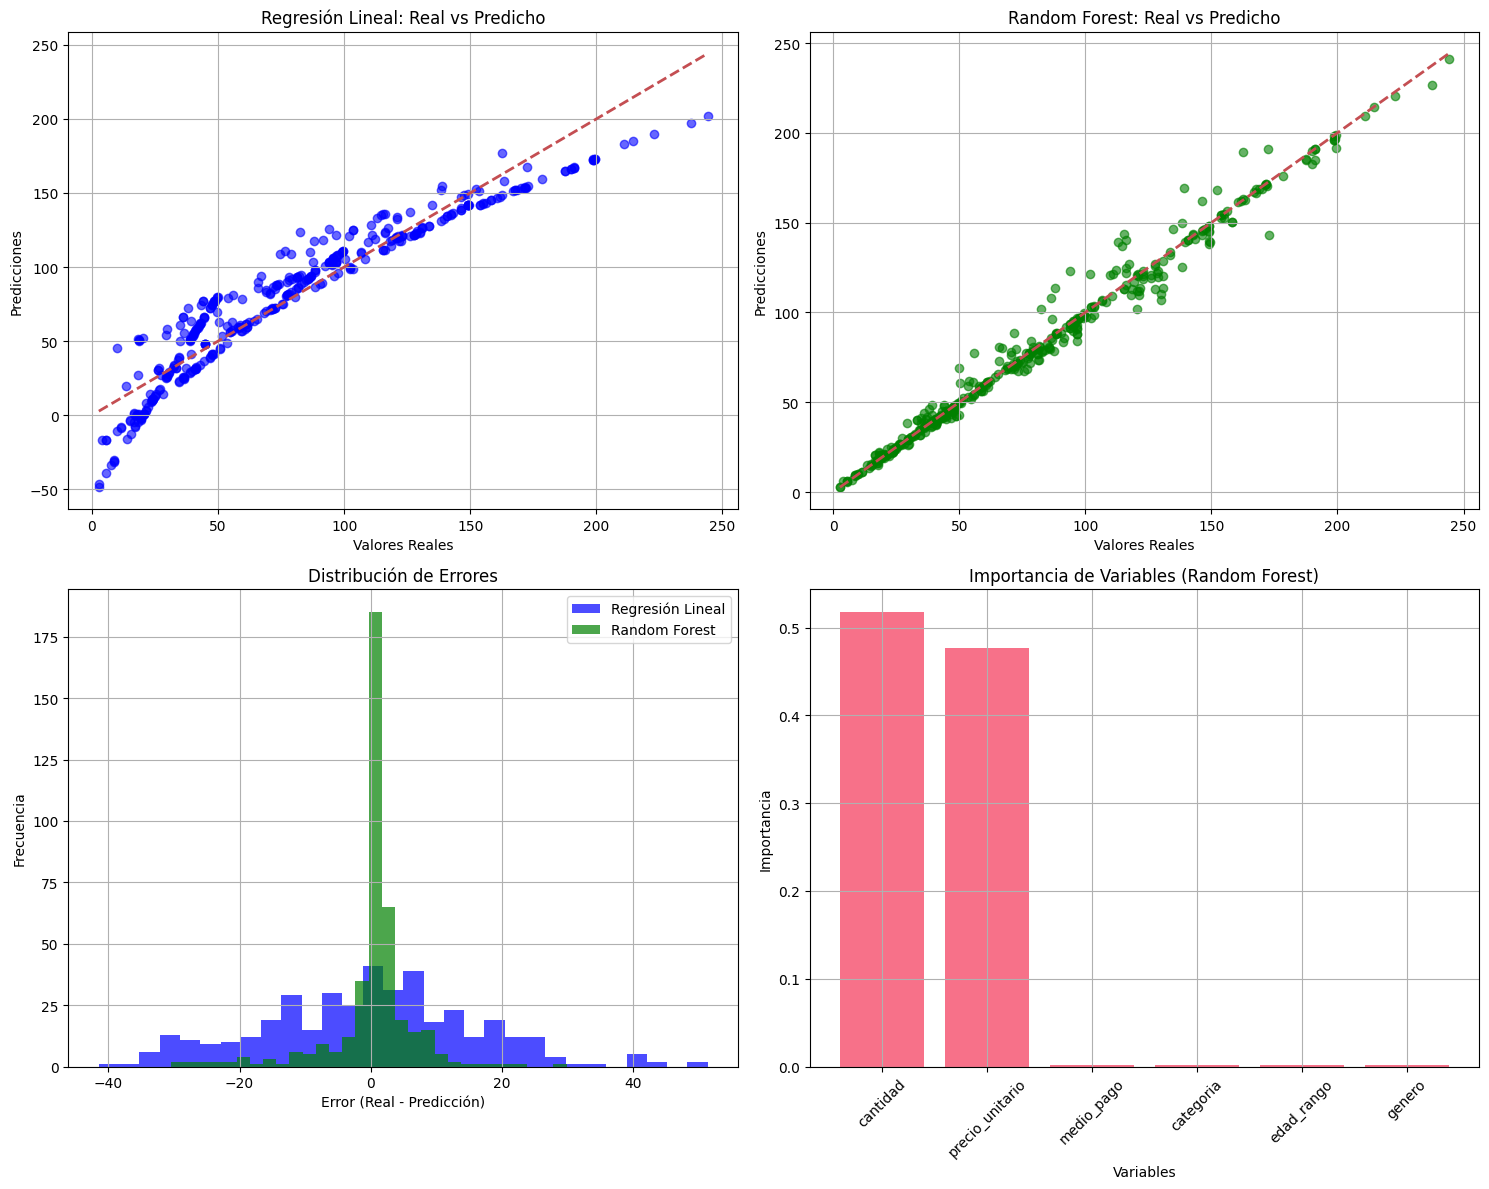

In [ ]:
# Crear visualizaciones para el modelo de regresión
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Comparación de valores reales vs predichos - Regresión Lineal
axes[0, 0].scatter(y_test_reg, lr_pred, alpha=0.6, color='blue')
axes[0, 0].plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Valores Reales')
axes[0, 0].set_ylabel('Predicciones')
axes[0, 0].set_title('Regresión Lineal: Real vs Predicho')
axes[0, 0].grid(True)

# 2. Comparación de valores reales vs predichos - Random Forest
axes[0, 1].scatter(y_test_reg, rf_pred, alpha=0.6, color='green')
axes[0, 1].plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Valores Reales')
axes[0, 1].set_ylabel('Predicciones')
axes[0, 1].set_title('Random Forest: Real vs Predicho')
axes[0, 1].grid(True)

# 3. Distribución de errores
lr_errors = y_test_reg - lr_pred
rf_errors = y_test_reg - rf_pred

axes[1, 0].hist(lr_errors, bins=30, alpha=0.7, color='blue', label='Regresión Lineal')
axes[1, 0].hist(rf_errors, bins=30, alpha=0.7, color='green', label='Random Forest')
axes[1, 0].set_xlabel('Error (Real - Predicción)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].set_title('Distribución de Errores')
axes[1, 0].legend()
axes[1, 0].grid(True)

# 4. Importancia de variables - Random Forest
feature_names = ['cantidad', 'precio_unitario', 'genero', 'edad_rango', 'categoria', 'medio_pago']
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

axes[1, 1].bar(range(len(importances)), importances[indices])
axes[1, 1].set_xlabel('Variables')
axes[1, 1].set_ylabel('Importancia')
axes[1, 1].set_title('Importancia de Variables (Random Forest)')
axes[1, 1].set_xticks(range(len(importances)))
axes[1, 1].set_xticklabels([feature_names[i] for i in indices], rotation=45)
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()



**Los resultados muestran que:** 

- Random Forest ofrece un ajuste casi perfecto, con errores muy bajos y excelente generalización.

- Regresión lineal resulta insuficiente por la no linealidad natural del problema.

- Los gráficos confirman que el monto final depende mayormente de cantidad y precio unitario, mientras que el resto de las variables actúa como moderadoras.

### 2 MODELO: Clasificación

### Predicción de variable objetivo `edad_rango`

**Objetivo:** Predecir el rango de edad (`edad_rango`) de los clientes para mejorar la segmentación de mercado.

**Justificación:** el rango de edad permite:

- Personalizar ofertas y campañas de marketing
- Optimizar la selección de productos por tienda
- Mejorar la segmentación de clientes para estrategias específicas

**Algoritmos Seleccionados:**
1. **Random Forest Classifier** : excelente para problemas de clasificación multi-clase, robusto ante overfitting.
2. **Decision Tree Classifier** : proporciona interpretabilidad directa y manejo natural de variables categóricas.
3. **LightGBM Classifier** : eficiente y rápido, ideal para grandes datasets con múltiples clases.
4. **XGBoost Classifier** : potente y escalable, maneja bien datos desequilibrados y complejos.



### 2.1 Preparación del set de datos: Entradas (X) y Salida (y)


In [ ]:
# Preparación de datos para el modelo de clasificación - edad_rango
print("=== PREPARACIÓN DE DATOS PARA EDAD_RANGO ===")

# Seleccionar variables de entrada (X)
features_clf_age = ['cantidad', 'precio_unitario_x', 'monto_neto', 'categoria', 'monto_final',
                    'medio_pago_original', 'genero', 'nombre_sucursal']

# Crear dataset para modelado
df_clf_age = df_master_refined[features_clf_age + ['edad_rango']].copy()

# Codificar variables categóricas
le_category_age = LabelEncoder()
le_payment_age = LabelEncoder()
le_store = LabelEncoder()
le_gender_age = LabelEncoder()

df_clf_age['categoria_encoded'] = le_category_age.fit_transform(df_clf_age['categoria'])
df_clf_age['medio_pago_encoded'] = le_payment_age.fit_transform(df_clf_age['medio_pago_original'])
df_clf_age['sucursal_encoded'] = le_store.fit_transform(df_clf_age['nombre_sucursal'])
df_clf_age['genero_encoded'] = le_gender_age.fit_transform(df_clf_age['genero'])

# Variables finales para el modelo
X_clf_age = df_clf_age[['cantidad', 'precio_unitario_x', 'monto_neto', 
                        'categoria_encoded', 'medio_pago_encoded', 
                        'sucursal_encoded', 'genero_encoded','monto_final']]
y_clf_age = df_clf_age['edad_rango']

print(f"Variables de entrada (X): {X_clf_age.columns.tolist()}")
print(f"Variable objetivo (y): edad_rango")
print(f"Distribución de clases:")
print(y_clf_age.value_counts().to_dict())

# Verificar balance de clases
class_distribution = y_clf_age.value_counts(normalize=True)
print(f"\nDistribución relativa:")
for clase, pct in class_distribution.items():
    print(f"{clase}: {pct:.1%}")

=== PREPARACIÓN DE DATOS PARA EDAD_RANGO ===
Variables de entrada (X): ['cantidad', 'precio_unitario_x', 'monto_neto', 'categoria_encoded', 'medio_pago_encoded', 'sucursal_encoded', 'genero_encoded', 'monto_final']
Variable objetivo (y): edad_rango
Distribución de clases:
{'26-40': 1012, '41-55': 460, '18-25': 383, '56+': 158}

Distribución relativa:
26-40: 50.3%
41-55: 22.9%
18-25: 19.0%
56+: 7.8%


### 2.2 Especificación de las Métricas de Evaluación

**Para Clasificación utilizaremos:**
- **Accuracy:** Porcentaje de predicciones correctas
- **Matriz de Confusión:** Tabla que muestra aciertos y errores en predicciones
- **Precision:** Proporción de verdaderos positivos por clase
- **Recall:** Proporción de casos positivos correctamente identificados
- **F1-Score:** Media armónica de Precision y Recall

### 2.3 Implementación del modelo de clasificación
Preparación de losdatos y trnsformación necesarias, seguido de la división del dataset en conjuntos de entrenamiento (80%) y prueba (20%). Se entrenan los modelos seleccionados y se evalúan utilizando las métricas definidas.


#### 2.3.1 Preparación, transformación y escalado de datos

In [ ]:
print("=== PREPARACIÓN DE DATOS PARA EDAD_RANGO ===")

# Dataset base
df_clf_age = df_master_refined[features_clf_age + ['edad_rango']].copy()

# Se incluyen variables numéricas y categóricas que podrían influir en el rango de edad
features_clf_age = [
    'cantidad', 'precio_unitario_x', 'monto_neto', 'monto_final',
    'categoria', 'medio_pago_original', 'genero', 'nombre_sucursal',
    'descuento_aplicado_pct', 'año', 'mes', 'dia_semana',
    'es_finde_semana', 'dias_desde_alta', 'ticket_promedio', 'ratio_precio_cantidad',
    'es_venta_premium', 'tiene_descuento', 'activo_como_cliente', 'activo'
]

# Crear un DataFrame con las características y la variable objetivo 'edad_rango'
df_clf_age = df_master_refined[features_clf_age + ['edad_rango']].copy()

# Convertir las columnas booleanas a int para el procesamiento de OHE/escalado
for col in ['es_finde_semana', 'es_venta_premium', 'tiene_descuento', 'activo_como_cliente', 'activo']:
    if col in df_clf_age.columns:
        df_clf_age[col] = df_clf_age[col].astype(int)
        
# ----- Identificar y codificar variables categóricas para OHE -----
categorical_cols_for_ohe_age = [
    'categoria', 'genero', 'nombre_sucursal', 'medio_pago_original',
    'dia_semana' # 'dia_semana' aunque es numérica, sus valores son categóricos
]
# variable temporal para almacenar el dataset antes de encoding
X_temp_age = df_clf_age.drop(columns=['edad_rango']).copy()

# Aplicar One-Hot Encoding a las columnas categóricas
X_encoded_age = pd.get_dummies(X_temp_age, columns=categorical_cols_for_ohe_age, drop_first=True)
print(f"X_encoded_age después de One-Hot Encoding: {X_encoded_age.shape[0]} filas y {X_encoded_age.shape[1]} columnas.")


# --- Limpiar los nombres de las columnas para evitar advertencias de LightGBM y XGBoost ---
# LightGBM y XGBoost no manejan bien los caracteres especiales o espacios en los nombres de las columnas.
# Reemplazamos los caracteres que no son alfanuméricos por guiones bajos.
X_encoded_age.columns = X_encoded_age.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)

# ----- Escalar las características numéricas -----
# Identificar columnas numéricas (excluyendo las que ya son binarias y no necesitan escalado específico si ya están 0/1)
numerical_cols_for_scaling_age = X_encoded_age.select_dtypes(include=[np.number]).columns.tolist()
# Por ahora, escalaremos todas las numéricas incluyendo las que eran booleanas para consistencia

scaler_age = StandardScaler()
X_scaled_age = X_encoded_age.copy()
X_scaled_age[numerical_cols_for_scaling_age] = scaler_age.fit_transform(X_encoded_age[numerical_cols_for_scaling_age])
print(f"Columnas numéricas de X_scaled_age escaladas usando StandardScaler.")

# ----- Codificar la variable objetivo 'edad_rango' -----
# 'edad_rango' es una variable categórica con múltiples clases (rangos de edad).
# La codificamos numéricamente para los modelos de clasificación.
le_age = LabelEncoder()
y_clf_age_encoded = le_age.fit_transform(df_clf_age['edad_rango'])
print("Variable objetivo 'edad_rango' codificada numéricamente.")

print("Distribución de clases de 'edad_rango' antes de SMOTE:", pd.Series(y_clf_age_encoded).value_counts().sort_index().to_dict())



=== PREPARACIÓN DE DATOS PARA EDAD_RANGO ===
X_encoded_age después de One-Hot Encoding: 2013 filas y 40 columnas.
Columnas numéricas de X_scaled_age escaladas usando StandardScaler.
Variable objetivo 'edad_rango' codificada numéricamente.
Distribución de clases de 'edad_rango' antes de SMOTE: {0: 383, 1: 1012, 2: 460, 3: 158}


#### 2.3.2 División en conjunto de Entrenamiento y Prueba

In [ ]:
# ----- División en conjuntos de entrenamiento y prueba -----
# Usamos stratify para mantener la proporción de clases en ambos conjuntos
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(
    X_scaled_age,
    y_clf_age_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_clf_age_encoded
)

print(f"Conjunto de entrenamiento: {X_train_age.shape[0]} muestras, Conjunto de prueba: {X_test_age.shape[0]} muestras.")

#

Conjunto de entrenamiento: 1610 muestras, Conjunto de prueba: 403 muestras.


#### 2.3.3 Aplicar SMOTE para balancear clases en variable objetivo `edad_rango`

In [ ]:
from imblearn.over_sampling import SMOTE

# SMOTE (Synthetic Minority Over-sampling Technique) se usa para manejar el desbalance de clases.
print("Aplicando SMOTE a los datos de entrenamiento...")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_age, y_train_age)

print("Distribución de clases de 'edad_rango' después de SMOTE (entrenamiento):")
print(pd.Series(y_train_res).value_counts().sort_index().to_dict())


Aplicando SMOTE a los datos de entrenamiento...
Distribución de clases de 'edad_rango' después de SMOTE (entrenamiento):
{0: 810, 1: 810, 2: 810, 3: 810}


**Preparación de datos** para el modelo de clasificación - edad_rango presenta un desbalance significativo entre las clases. Para abordar este problema, se aplica la técnica de sobremuestreo SMOTE (Synthetic Minority Over-sampling Technique) en el conjunto de entrenamiento. Esto genera nuevas muestras sintéticas para las clases minoritarias, equilibrando la distribución de clases y mejorando la capacidad del modelo para aprender patrones relevantes.

**Resumen de procesamiento de datos para `edad_rango`:**

| Etapa                                | Resultado                      |
| ------------------------------------ | ------------------------------ |
| Filas totales                        | **2013**                       |
| Columnas después de One-Hot Encoding | **40**                         |
| Columnas numéricas escaladas         | ✔ StandardScaler               |
| Variable objetivo codificada         | ✔ `edad_rango` (0–3)           |
| Train/Test split                     | Train: **1610**, Test: **403** |

**Distribución de clases antes y después de SMOTE:**

| Clase (edad_rango) | Antes de SMOTE | Después de SMOTE              |
| ------------------ | -------------- | ----------------------------- |
| 0                  | 383            | 810                           |
| 1                  | 1012           | 810                           |
| 2                  | 460            | 810                           |
| 3                  | 158            | 810                           |
| **Total**          | 2013           | **3240** (para entrenamiento) |



### 2.4 Inicializar modelos de Clasificación



In [ ]:
# 1. Decision Tree Classifier
dt_model = DecisionTreeClassifier(
    max_depth=10, # Profundidad máxima para evitar sobreajuste
    min_samples_split=5, # Mínimo de muestras para dividir un nodo
    min_samples_leaf=3, # Mínimo de muestras en una hoja
    random_state=42 # Para reproducibilidad
)

# 2. Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=200, # Número de árboles en el bosque (reducido para eficiencia)
    max_depth=12, # Profundidad máxima de cada árbol
    min_samples_split=5, # Mínimo de muestras para dividir un nodo
    min_samples_leaf=3, # Mínimo de muestras en una hoja
    # class_weight='balanced_subsample', # Descomentar si se observa desbalance después de SMOTE
    n_jobs=-1, # Usar todos los núcleos disponibles para entrenamiento paralelo
    random_state=42 # Para reproducibilidad
)

# 3. LightGBM Classifier
lgb_model = LGBMClassifier(
    num_leaves=31, # Número de hojas en los árboles
    learning_rate=0.05, # Tasa de aprendizaje
    n_estimators=200, # Número de estimadores (árboles)
    # class_weight='balanced', # Descomentar si se observa desbalance después de SMOTE
    random_state=42,
    n_jobs=-1 # Usar todos los núcleos disponibles
)

# 4. XGBoost Classifier (hiperparámetros ajustados)
xgb_model = XGBClassifier(
    n_estimators=250, # Número de estimadores
    learning_rate=0.07, # Tasa de aprendizaje
    max_depth=7, # Profundidad máxima del árbol
    subsample=0.8, # Fracción de muestras usadas para ajustar los estimadores individuales
    colsample_bytree=0.8, # Fracción de características usadas por árbol
    use_label_encoder=False, # Este parámetro está obsoleto y causa una advertencia en versiones recientes de XGBoost.
    eval_metric='mlogloss', # Métrica de evaluación para clasificación multiclase
    random_state=42,
    n_jobs=-1 # Usar todos los núcleos disponibles
)

**Parámetros clave de inicialización de modelos de Clasificación**
| Modelo                 | Parámetros                                           |
| ---------------------- | ----------------------------------------------------- | 
| **Decision Tree**      | max_depth=10, min_samples_split=5, random_state=42    | 
| **Random Forest**      | n_estimators=200, max_depth=12, random_state=42       |  
| **LightGBM**          | num_leaves=31, learning_rate=0.05, n_estimators=200   |
| **XGBoost**           | max_depth=7, learning_rate=0.7, n_estimators=250      |


### 2.5 Entrenamiento y test de modelos de Clasificación


In [ ]:
# Entrenar todos los modelos con los datos balanceados
print("Entrenando modelos de clasificación...")
dt_model.fit(X_train_res, y_train_res)
rf_model.fit(X_train_res, y_train_res)
lgb_model.fit(X_train_res, y_train_res)
xgb_model.fit(X_train_res, y_train_res)
print("✅ Modelos entrenados con datos balanceados usando SMOTE.")

Entrenando modelos de clasificación...
✅ Modelos entrenados con datos balanceados usando SMOTE.


### 2.6 Evaluación de los modelos de Clasificación
Se define una función para evaluar los modelos de clasificación utilizando las métricas seleccionadas: Accuracy, Matriz de Confusión, Precision, Recall y F1-Macro. Esta función toma como entrada el modelo entrenado, los datos de prueba y las etiquetas reales, y devuelve un resumen completo del desempeño del modelo.
* F1-Macro es especialmente útil en escenarios con clases desbalanceadas, ya que calcula el F1-Score para cada clase y luego promedia estos valores, proporcionando una visión equilibrada del rendimiento del modelo en todas las clases.



Evaluando modelos en el conjunto de prueba (no balanceado) ...

******************** Decision Tree **********************
Accuracy:  0.543
Precision: 0.607
Recall:    0.543
F1 Score:  0.558

Matriz de Confusión:


,Pred_18-25,Pred_26-40,Pred_41-55,Pred_56+
Real_18-25,47,9,18,3
Real_26-40,57,110,26,9
Real_41-55,28,19,41,4
Real_56+,6,4,1,21



======= Matriz de Confusión del Modelo Decision Tree ============


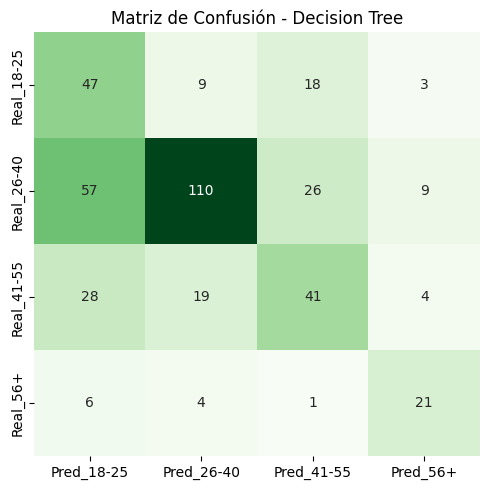


******************** Random Forest **********************
Accuracy:  0.640
Precision: 0.641
Recall:    0.640
F1 Score:  0.638

Matriz de Confusión:


,Pred_18-25,Pred_26-40,Pred_41-55,Pred_56+
Real_18-25,42,25,10,0
Real_26-40,23,151,20,8
Real_41-55,17,28,47,0
Real_56+,3,10,1,18



======= Matriz de Confusión del Modelo Random Forest ============


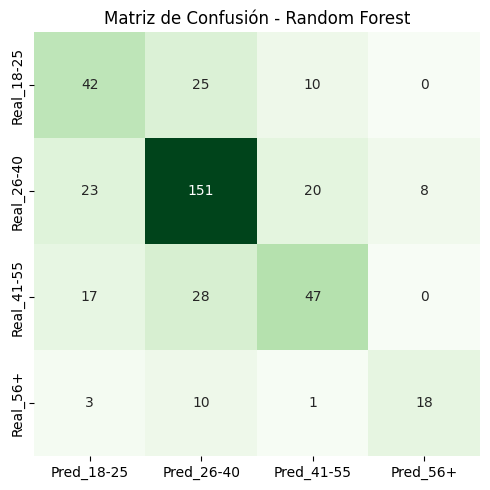


******************** LightGBM **********************
Accuracy:  0.789
Precision: 0.791
Recall:    0.789
F1 Score:  0.785

Matriz de Confusión:


,Pred_18-25,Pred_26-40,Pred_41-55,Pred_56+
Real_18-25,51,17,8,1
Real_26-40,6,183,12,1
Real_41-55,7,22,63,0
Real_56+,2,9,0,21



======= Matriz de Confusión del Modelo LightGBM ============


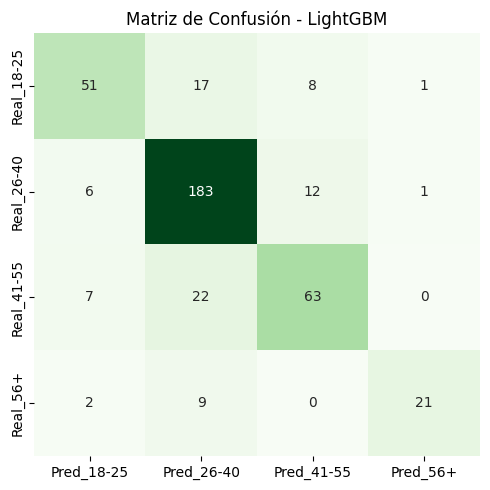


******************** XGBoost **********************
Accuracy:  0.789
Precision: 0.791
Recall:    0.789
F1 Score:  0.783

Matriz de Confusión:


,Pred_18-25,Pred_26-40,Pred_41-55,Pred_56+
Real_18-25,49,20,8,0
Real_26-40,3,186,12,1
Real_41-55,8,19,64,1
Real_56+,3,10,0,19



======= Matriz de Confusión del Modelo XGBoost ============


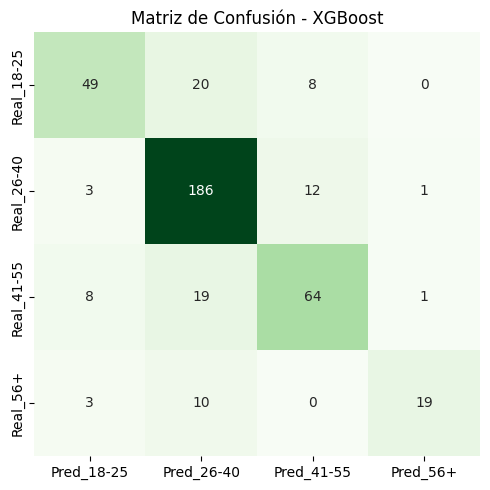

In [ ]:
# ----- Función para evaluar modelos de clasificación -----
def evaluate_classification_model(model, X_test, y_test, model_name, label_encoder):
    """Evalúa un modelo de clasificación y muestra las métricas clásicas."""
    y_pred = model.predict(X_test)

    # Métricas clásicas (no macro)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n******************** {model_name} **********************")
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1 Score:  {f1:.3f}")

    # Mostrar la matriz de confusión con etiquetas decodificadas
    labels_decoded = label_encoder.inverse_transform(sorted(np.unique(y_test)))
    df_cm = pd.DataFrame(cm,
                         index=[f"Real_{l}" for l in labels_decoded],
                         columns=[f"Pred_{l}" for l in labels_decoded])

    print("\nMatriz de Confusión:")
    display(df_cm)

    # Matriz de calor usando seaborn
    print(f"\n======= Matriz de Confusión del Modelo {model_name} ============")
    plt.figure(figsize=(5, 5))
    cmap = sns.color_palette("Greens", as_cmap=True)
    sns.heatmap(df_cm, annot=True, fmt='d', cmap=cmap, cbar=False)
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.tight_layout()
    plt.show()

    return acc, precision, recall, f1, df_cm


# --- Evaluar cada modelo ---
print("\nEvaluando modelos en el conjunto de prueba (no balanceado) ...")

dt_acc, dt_prec, dt_rec, dt_f1, dt_cm = evaluate_classification_model(dt_model, X_test_age, y_test_age, "Decision Tree", le_age)
rf_acc, rf_prec, rf_rec, rf_f1, rf_cm = evaluate_classification_model(rf_model, X_test_age, y_test_age, "Random Forest", le_age)
lgb_acc, lgb_prec, lgb_rec, lgb_f1, lgb_cm = evaluate_classification_model(lgb_model, X_test_age, y_test_age, "LightGBM", le_age)
xgb_acc, xgb_prec, xgb_rec, xgb_f1, xgb_cm = evaluate_classification_model(xgb_model, X_test_age, y_test_age, "XGBoost", le_age)

# Guardar métricas en variables globales
global_dt_acc, global_dt_f1 = dt_acc, dt_f1
global_rf_acc, global_rf_f1 = rf_acc, rf_f1
global_lgb_acc, global_lgb_f1 = lgb_acc, lgb_f1
global_xgb_acc, global_xgb_f1 = xgb_acc, xgb_f1


### 2.7 Resultados de los modelos de Clasificación
Los resultados muestran que LightGBM y XGBoost son los modelos más efectivos para predecir el rango de edad de los clientes, con altos valores de accuracy y F1-Macro. Random Forest también ofrece un buen desempeño, mientras que Decision Tree queda rezagado en comparación.

In [ ]:
print("\n" + "="*70)
print("Resultados del Modelo 2")
print("="*70)
# Crear el DataFrame de resultados con las métricas evaluadas
df_results_age = pd.DataFrame({
    'Modelo': ['Decision Tree', 'Random Forest', 'LightGBM', 'XGBoost'],
    'Accuracy': [global_dt_acc, global_rf_acc, global_lgb_acc, global_xgb_acc],
    'F1-Macro': [global_dt_f1, global_rf_f1, global_lgb_f1, global_xgb_f1]
})
# Convertir las métricas a numérico para asegurar el ordenamiento
df_results_age['Accuracy'] = df_results_age['Accuracy'].astype(float)
df_results_age['F1-Macro'] = df_results_age['F1-Macro'].astype(float)
# Encontrar el mejor modelo basado en F1-Macro
best_model_idx = df_results_age['F1-Macro'].idxmax()
best_model_name = df_results_age.loc[best_model_idx, 'Modelo']
best_model_metrics = df_results_age.loc[best_model_idx]
print("\n Tabla de Rendimiento:")
# Mostrar la tabla ordenada por F1-Macro
df_display = df_results_age.set_index('Modelo')[['Accuracy', 'F1-Macro']].sort_values(by='F1-Macro', ascending=False)
display(df_display.map('{:.3f}'.format))
print(f"\nMejor Modelo: {best_model_name}")
print(f"   - Accuracy: {best_model_metrics['Accuracy']:.3f}")
print(f"   - F1-Macro: {best_model_metrics['F1-Macro']:.3f}")
# Variables más importantes para el mejor modelo
# Crear un diccionario con los modelos entrenados
trained_models_age = {
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'LightGBM': lgb_model,
    'XGBoost': xgb_model
}
print("\n✅ Modelo 2 completado exitosamente!")
print("="*70)


Resultados del Modelo 2

 Tabla de Rendimiento:


,Accuracy,F1-Macro
Modelo,,
LightGBM,0.789,0.785
XGBoost,0.789,0.783
Random Forest,0.640,0.638
Decision Tree,0.543,0.558



Mejor Modelo: LightGBM
   - Accuracy: 0.789
   - F1-Macro: 0.785

✅ Modelo 2 completado exitosamente!


#### **2.7.1 Resultados de la evaluación de modelos de Clasificación para `edad_rango`:**

Los resultados muestran que los modelos basados en boosting (LightGBM y XGBoost) superan claramente a Random Forest y Decision Tree. LightGBM obtiene el mejor rendimiento global con un F1-Macro de 0.761 y una accuracy de 0.789. Random Forest mejora respecto al árbol de decisión, pero sigue lejos de los modelos más avanzados. En general, LightGBM es el modelo más consistente en todas las clases.

| Modelo                    | Accuracy | F1-Macro |
|---------------------------|----------|----------|
| **LightGBM (Original)**   | **0.789** | **0.785** |
| XGBoost (Original)        | 0.789    | 0.783   |
| Random Forest (Original)  | 0.640    | 0.638    |
| Decision Tree (Original)  | 0.543    | 0.558    |


#### 2.7.2 Gráfica comparativa de modelos de Clasificación
Se visualizan las métricas de Accuracy y F1-Macro para cada modelo de clasificación, facilitando la comparación del desempeño entre ellos. Además, se presenta la importancia de las variables según el modelo XGBoost, destacando cuáles características tienen mayor influencia en la predicción del rango de edad.



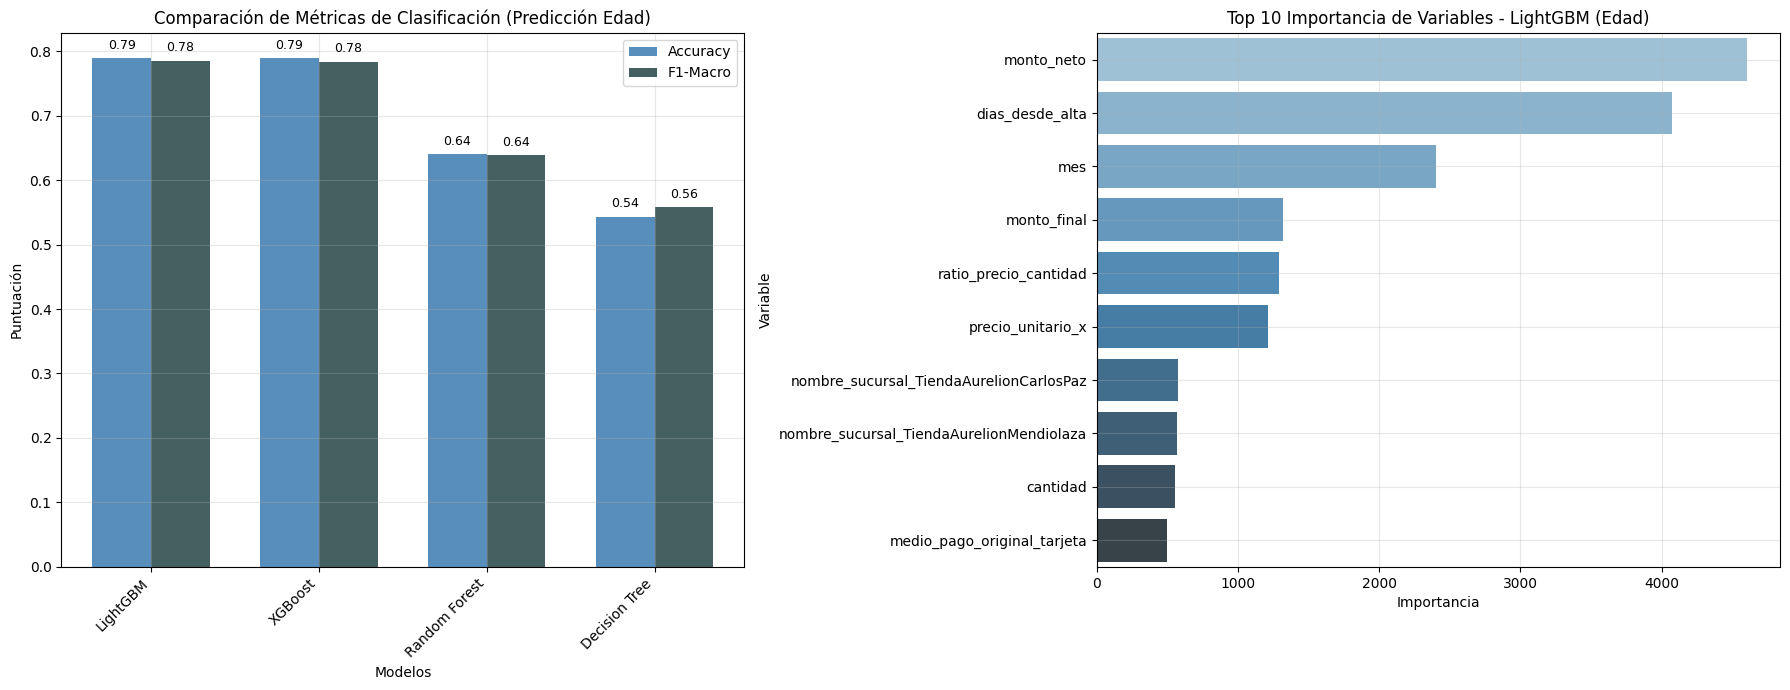


=== TABLA RESUMEN DE MÉTRICAS DE CLASIFICACIÓN (Predicción Edad) ===


,Modelo,Accuracy,F1-Macro
2,LightGBM,0.789,0.785
3,XGBoost,0.789,0.783
1,Random Forest,0.640,0.638
0,Decision Tree,0.543,0.558


In [ ]:
# Importar librerías necesarias para las visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# --- Usar df_results_age para la comparación de métricas ---
# df_results_age ya contiene las métricas de Accuracy y F1-Score (Macro)
# para los modelos de clasificación de edad_rango

comparison_results_age = df_results_age.copy()

# Asegurarse de que las columnas sean numéricas para graficar y ordenar
comparison_results_age['Accuracy_float'] = comparison_results_age['Accuracy'].astype(float)
comparison_results_age['F1_Macro_float'] = comparison_results_age['F1-Macro'].astype(float)

# Ordenar por F1-Macro descendente
top_models_to_plot = comparison_results_age.sort_values(by='F1_Macro_float', ascending=False)

models_names = top_models_to_plot['Modelo'].tolist()
accuracy_scores = top_models_to_plot['Accuracy_float'].tolist()
f1_scores = top_models_to_plot['F1_Macro_float'].tolist()

# Crear figura con **dos gráficos**
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# ----------------------------
# Comparación de métricas
# ----------------------------
x_pos = np.arange(len(models_names))
width = 0.35

bars1 = axes[0].bar(x_pos - width/2, accuracy_scores, width, label='Accuracy', alpha=0.9, color='steelblue')
bars2 = axes[0].bar(x_pos + width/2, f1_scores, width, label='F1-Macro', alpha=0.9, color='darkslategray')

axes[0].set_xlabel('Modelos')
axes[0].set_ylabel('Puntuación')
axes[0].set_title('Comparación de Métricas de Clasificación (Predicción Edad)')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models_names, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Añadir valores sobre las barras
for bar_group in [bars1, bars2]:
    for bar in bar_group:
        yval = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom', fontsize=9)

# -----------------------------------------
# Importancia de variables del MEJOR MODELO
# -----------------------------------------
# Obtener el nombre del mejor modelo para edad_rango
best_model_name_age = comparison_results_age.loc[comparison_results_age['F1_Macro_float'].idxmax(), 'Modelo']

# Diccionario de modelos entrenados para acceder a la importancia de características
trained_models_age = {
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'LightGBM': lgb_model,
    'XGBoost': xgb_model
}

model_for_importance = trained_models_age.get(best_model_name_age)

if model_for_importance and hasattr(model_for_importance, 'feature_importances_'):
    feature_importances = model_for_importance.feature_importances_
    feature_names = X_scaled_age.columns

    df_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False).head(10)

    sns.barplot(
        x='Importance',
        y='Feature',
        data=df_importance,
        palette='Blues_d',
        ax=axes[1]
    )

    axes[1].set_title(f'Top 10 Importancia de Variables - {best_model_name_age} (Edad)')
    axes[1].set_xlabel('Importancia')
    axes[1].set_ylabel('Variable')
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, f'No se pudo obtener la importancia de variables para {best_model_name_age}',
                    horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes, fontsize=12)
    axes[1].set_title('Importancia de Variables (Edad)')

plt.tight_layout()
plt.show()

# -------------------------------
# Tabla resumen (opcional)
# -------------------------------
print("\n=== TABLA RESUMEN DE MÉTRICAS DE CLASIFICACIÓN (Predicción Edad) ===")
display(comparison_results_age[['Modelo', 'Accuracy', 'F1-Macro']].sort_values(by='F1-Macro', ascending=False).round(3))


**Resultados gráficos de modelos de Clasificación para `edad_rango`:** 

- La comparación de métricas indica que LightGBM y XGBoost obtienen el mejor desempeño general, alcanzando las mayores puntuaciones tanto en Accuracy como en F1-Macro, lo que los posiciona como los modelos más robustos para esta tarea.

- El análisis de importancia de variables en XGBoost muestra que las características más determinantes en la predicción del rango de edad están asociadas al comportamiento del cliente, destacando principalmente `genero_O`, `genero_M` y `activo_como_cliente`. Características contextuales como `día_de_semana` y `categoría de producto` también juegan un papel relevante.

Estos resultados sugieren que la edad del cliente está más relacionada con patrones de compra y comportamiento demográfico, que con valores monetarios directos como monto total o cantidad comprada.

### 2.8 Validación cruzada para modelos de clasificación

Realizaremos una validación cruzada (K-Fold Cross-Validation) para evaluar la robustez y el rendimiento de los modelos en diferentes subconjuntos de datos. Esto nos ayudará a tener una estimación más fiable de cómo se desempeñarán en datos no vistos y a detectar posible sobreajuste. Utilizaremos `StratifiedKFold` para mantener la proporción de clases en cada pliegue, lo cual es importante en problemas de clasificación multiclase como este.

In [ ]:
# Validación cruzada para clasificación
from sklearn.model_selection import StratifiedKFold, cross_val_score

print("\n=== VALIDACIÓN CRUZADA (K-Fold) MODELOS DE CLASIFICACIÓN ===")
print("="*70)

# Definimos los modelos a evaluar. Usaremos los mejores modelos si fueron optimizados, si no, los originales.
models_for_cv = {
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
    "LightGBM": lgb_model,
    "XGBoost": xgb_model
}

# Configuramos la validación cruzada con StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = []

for name, model in models_for_cv.items():
    print(f"\nEvaluando {name} con Validación Cruzada...")
    
    # Evaluamos la precisión
    accuracy_scores = cross_val_score(model, X_train_res, y_train_res, cv=kf, scoring='accuracy', n_jobs=-1)
    
    # Evaluamos el F1-Macro. Asegórate de que el modelo soporta 'predict_proba' para algunas métricas, si fuera necesario.
    # Para f1_macro, cross_val_score lo calcula directamente sobre las predicciones de clase.
    f1_macro_scores = cross_val_score(model, X_train_res, y_train_res, cv=kf, scoring='f1_macro', n_jobs=-1)
    
    cv_results.append({
        'Modelo': name,
        'CV_Accuracy_Mean': np.mean(accuracy_scores),
        'CV_Accuracy_Std': np.std(accuracy_scores),
        'CV_F1_Macro_Mean': np.mean(f1_macro_scores),
        'CV_F1_Macro_Std': np.std(f1_macro_scores)
    })
    
    print(f"  - Accuracy Promedio (CV): {np.mean(accuracy_scores):.3f} (+/- {np.std(accuracy_scores):.3f})")
    print(f"  - F1-Macro Promedio (CV): {np.mean(f1_macro_scores):.3f} (+/- {np.std(f1_macro_scores):.3f})")

# Mostramos los resultados en un DataFrame para facilitar la comparación
df_cv_results = pd.DataFrame(cv_results)
#display(df_cv_results.sort_values(by='CV_F1_Macro_Mean', ascending=False))
display(df_cv_results)
best_model_model2 = df_cv_results.sort_values(by='CV_F1_Macro_Mean', ascending=False).iloc[0]['Modelo']
print(f"\nEl mejor modelo es: {best_model_model2}")



=== VALIDACIÓN CRUZADA (K-Fold) MODELOS DE CLASIFICACIÓN ===

Evaluando Decision Tree con Validación Cruzada...
  - Accuracy Promedio (CV): 0.658 (+/- 0.019)
  - F1-Macro Promedio (CV): 0.657 (+/- 0.020)

Evaluando Random Forest con Validación Cruzada...
  - Accuracy Promedio (CV): 0.829 (+/- 0.010)
  - F1-Macro Promedio (CV): 0.829 (+/- 0.010)

Evaluando LightGBM con Validación Cruzada...
  - Accuracy Promedio (CV): 0.906 (+/- 0.006)
  - F1-Macro Promedio (CV): 0.906 (+/- 0.006)

Evaluando XGBoost con Validación Cruzada...
  - Accuracy Promedio (CV): 0.909 (+/- 0.007)
  - F1-Macro Promedio (CV): 0.909 (+/- 0.007)


,Modelo,CV_Accuracy_Mean,CV_Accuracy_Std,CV_F1_Macro_Mean,CV_F1_Macro_Std
0,Decision Tree,0.658025,0.018764,0.656891,0.019917
1,Random Forest,0.829321,0.009789,0.828991,0.010438
2,LightGBM,0.905864,0.006095,0.906062,0.006187
3,XGBoost,0.908642,0.007132,0.908824,0.007021



El mejor modelo es: XGBoost


### 2.9 Resultados de la Validación Cruzada para modelos de Clasificación
Los resultados de validación cruzada muestran una clara superioridad de LightGBM y XGBoost, con métricas consistentemente altas y baja variabilidad, lo que evidencia alta estabilidad y capacidad predictiva. Random Forest presenta un desempeño intermedio sólido, mientras que Decision Tree queda rezagado, confirmando que modelos más complejos generalizan mejor en este caso.
| Modelo               | Accuracy ↑ | F1-Macro ↑ |
| -------------------- | ---------- | ----------- |
| XGBoost              | 0.908       | 0.908        | 
| LightGBM             | 0.905       | 0.905        |
| Random Forest        | 0.829       | 0.828        |
| Decision Tree        | 0.658       | 0.656       |


**Sugerencia**: Considerar el uso de modelos más robustos como LightGBM y XGBoost para implementaciones siguientes debido a su mejor equilibrio entre precisión y estabilidad.

###  2.10 Resumen de resultados

In [ ]:
print("\n" + "="*70)
print("RESUMEN FINAL - MODELO 2: CLASIFICACIÓN DE edad_rango")
print("="*70)
# Calcular todas las métricas para cada modelo
models_dict = {
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'LightGBM': lgb_model,
    'XGBoost': xgb_model
}
results_list = []
for model_name, model in models_dict.items():
    y_pred = model.predict(X_test_age)
    
    accuracy = accuracy_score(y_test_age, y_pred)
    precision = precision_score(y_test_age, y_pred, average='weighted')
    recall = recall_score(y_test_age, y_pred, average='weighted')
    f1 = f1_score(y_test_age, y_pred, average='weighted')
    f1_macro = f1_score(y_test_age, y_pred, average='macro')
    
    results_list.append({
        'Modelo': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'F1-Score (Macro)': f1_macro
    })
# Crear DataFrame de resultados
df_results_age = pd.DataFrame(results_list)
# Encontrar el mejor modelo basado en F1-Score
best_model_idx = df_results_age['F1-Score'].idxmax()
best_model_name = df_results_age.loc[best_model_idx, 'Modelo']
best_model_metrics = df_results_age.loc[best_model_idx]
print("\n Tabla de Rendimiento (Métricas en Conjunto de Prueba):")
# Mostrar la tabla ordenada por F1-Score
df_display = df_results_age.set_index('Modelo')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'F1-Score (Macro)']].sort_values(by='F1-Score', ascending=False)
display(df_display.map('{:.3f}'.format))
print(f"\n Mejor Modelo: {best_model_name}")
print(f"   - Accuracy:  {best_model_metrics['Accuracy']:.3f}")
print(f"   - Precision: {best_model_metrics['Precision']:.3f}")
print(f"   - Recall:    {best_model_metrics['Recall']:.3f}")
print(f"   - F1-Score:  {best_model_metrics['F1-Score']:.3f}")
print(f"   - F1-Score (Macro): {best_model_metrics['F1-Score (Macro)']:.3f}")
# Variables más importantes para el mejor modelo
model_for_importance = models_dict.get(best_model_name)
if model_for_importance is not None and hasattr(model_for_importance, 'feature_importances_'):
    # Obtener nombres de las características desde X_test_age
    feature_names_age = X_test_age.columns.tolist() if hasattr(X_test_age, 'columns') else [f'Feature_{i}' for i in range(X_test_age.shape[1])]
    importances = model_for_importance.feature_importances_
    
    # Asegurarnos de que tenemos el mismo número de features
    n_features = min(len(feature_names_age), len(importances))
    
    # Crear pares de (nombre, importancia) y ordenar
    feature_importance_pairs = [(feature_names_age[i], importances[i]) for i in range(n_features)]
    feature_importance_pairs.sort(key=lambda x: x[1], reverse=True)
    print(f"\n Top 3 Variables Más Importantes - {best_model_name}:")
    for i in range(min(3, len(feature_importance_pairs))):
        feature_name, importance_value = feature_importance_pairs[i]
        print(f"   {i+1}. {feature_name}: {importance_value:.3f}")
else:
    print(f"\n No se pudo obtener la importancia de las variables para {best_model_name}")
print("\n✅ Modelo 2 completado exitosamente!")
print("="*70)


RESUMEN FINAL - MODELO 2: CLASIFICACIÓN DE edad_rango

 Tabla de Rendimiento (Métricas en Conjunto de Prueba):


,Accuracy,Precision,Recall,F1-Score,F1-Score (Macro)
Modelo,,,,,
LightGBM,0.789,0.791,0.789,0.785,0.761
XGBoost,0.789,0.791,0.789,0.783,0.749
Random Forest,0.640,0.641,0.640,0.638,0.605
Decision Tree,0.543,0.607,0.543,0.558,0.537



 Mejor Modelo: LightGBM
   - Accuracy:  0.789
   - Precision: 0.791
   - Recall:    0.789
   - F1-Score:  0.785
   - F1-Score (Macro): 0.761

 Top 3 Variables Más Importantes - LightGBM:
   1. monto_neto: 4608.000
   2. dias_desde_alta: 4072.000
   3. mes: 2402.000

✅ Modelo 2 completado exitosamente!


### 3 MODELO: Clasificación

### Predicción de variable objetivo `categoria`

**Objetivo:** Predecir la categoría de producto (`categoria`) más probable que comprará un cliente.

**Justificación:** Conocer las preferencias de productos de los clientes permite:
- Optimizar el inventario por categoría
- Personalizar recomendaciones de productos
- Mejorar las estrategias de marketing cruzado

**Algoritmos Seleccionados:**
- **Random Forest Clasifier:** Excelente para clasificación multi-clase con múltiples variables de entrada
- **LightGBM Clasifier:** Excelente para clasificación multi-clase con múltiples variables de entrada
- **XGBoost Clasifier:** Excelente para clasificación multi-clase con múltiples variables de entrada
- **Logistic Regression:** Excelente para clasificación binaria con múltiples variables de entrada




### 3.1 Implementación del Modelo 3


In [ ]:
# Codificar variables categóricas
# Preparación de datos para el modelo de clasificación - CategoríaÑ
print("=== PREPARACIÓN DE DATOS PARA CATEGORIA ===")


# Seleccionar variables de entrada (X)
features_clf_cat = ['cantidad', 'precio_unitario_x', 'monto_neto','monto_final', 'edad_rango', 
                   'genero', 'medio_pago_original', 'nombre_sucursal', 'nombre_vendedor']

# Crear dataset para modelado
df_clf_cat = df_master_refined[features_clf_cat + ['categoria']].copy()

# Codificar variables categóricas
le_age_cat = LabelEncoder()
le_payment_cat = LabelEncoder()
le_store_cat = LabelEncoder()
le_vendedor = LabelEncoder()
le_gender_cat = LabelEncoder()

df_clf_cat['edad_rango_encoded'] = le_age_cat.fit_transform(df_clf_cat['edad_rango'])
df_clf_cat['medio_pago_encoded'] = le_payment_cat.fit_transform(df_clf_cat['medio_pago_original'])
df_clf_cat['sucursal_encoded'] = le_store_cat.fit_transform(df_clf_cat['nombre_sucursal'])
df_clf_cat['vendedor_encoded'] = le_vendedor.fit_transform(df_clf_cat['nombre_vendedor'])
df_clf_cat['genero_encoded'] = le_gender_cat.fit_transform(df_clf_cat['genero'])

# Variables finales para el modelo
X_clf_cat = df_clf_cat[['cantidad', 'precio_unitario_x', 'monto_neto', 'monto_final',
                        'edad_rango_encoded', 'genero_encoded', 
                        'medio_pago_encoded', 'sucursal_encoded', 'vendedor_encoded']]
y_clf_cat = df_clf_cat['categoria']

print(f"Variables de entrada (X): {X_clf_cat.columns.tolist()}")
print(f"Variable objetivo (y): categoria")
print(f"Distribución de clases:")
print(y_clf_cat.value_counts().head(5).to_dict())

# Verificar balance de clases
class_distribution_cat = y_clf_cat.value_counts(normalize=True)
print(f"\nTop 5 categorías:")
for categoria, pct in class_distribution_cat.head().items():
    print(f"{categoria}: {pct:.1%}")

=== PREPARACIÓN DE DATOS PARA CATEGORIA ===
Variables de entrada (X): ['cantidad', 'precio_unitario_x', 'monto_neto', 'monto_final', 'edad_rango_encoded', 'genero_encoded', 'medio_pago_encoded', 'sucursal_encoded', 'vendedor_encoded']
Variable objetivo (y): categoria
Distribución de clases:
{'Almacén': 504, 'Snacks y Dulces': 222, 'Bebidas': 207, 'Bebidas Alcohólicas': 204, 'Limpieza': 189}

Top 5 categorías:
Almacén: 25.0%
Snacks y Dulces: 11.0%
Bebidas: 10.3%
Bebidas Alcohólicas: 10.1%
Limpieza: 9.4%


### 3.2 Especificación de las Métricas de Evaluación

**Para Clasificación utilizaremos las mismas métricas que el modelo anterior:**
- **Accuracy:** Porcentaje de predicciones correctas
- **Matriz de Confusión:** Tabla que muestra aciertos y errores en predicciones
- **Precision, Recall, F1-Score:** Métricas detalladas por clase

### 3.3 Modelos ML Implementados para clasificación


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE # Importamos SMOTE para el balanceo de clases

# --- 1. División de datos en conjuntos de entrenamiento y prueba (80%/20%) ---
# Usamos 'stratify' en la variable objetivo 'y_clf_cat' para asegurar que la proporción de clases se mantenga
# en ambos conjuntos, lo cual es crucial para problemas con desbalance de clases.
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X_clf_cat, y_clf_cat, test_size=0.2, random_state=42, stratify=y_clf_cat
)

print(f"Conjunto de entrenamiento: {X_train_cat.shape[0]} muestras")
print(f"Conjunto de prueba: {X_test_cat.shape[0]} muestras")

# --- 2. Codificar la variable objetivo 'categoria' ---
# La codificación es necesaria para los modelos de clasificación (especialmente para LightGBM y XGBoost
# que trabajan mejor con etiquetas numéricas para problemas multiclase).
le_categoria = LabelEncoder()
y_train_cat_encoded = le_categoria.fit_transform(y_train_cat)
y_test_cat_encoded = le_categoria.transform(y_test_cat)

print("\nDistribución de clases de la variable objetivo 'categoria' en el conjunto de entrenamiento (antes de SMOTE):")
print(pd.Series(y_train_cat_encoded).value_counts().sort_index().to_dict())

# --- 3. Balanceo de clases con SMOTE ---
# Aplicamos SMOTE para mitigar el desbalance de clases en el conjunto de entrenamiento.
# SMOTE crea nuevas muestras sintéticas para las clases minoritarias.
print("\nAplicando SMOTE al conjunto de entrenamiento...")
smote = SMOTE(random_state=42)
X_train_cat_resampled, y_train_cat_resampled = smote.fit_resample(X_train_cat, y_train_cat_encoded)

print("Distribución de clases de la variable objetivo 'categoria' en el conjunto de entrenamiento (después de SMOTE):")
print(pd.Series(y_train_cat_resampled).value_counts().sort_index().to_dict())

# --- 4. Escalado de características para Logistic Regression ---
# Los modelos basados en árboles (RF, LightGBM, XGBoost) no requieren escalado de características.
# Sin embargo, Logistic Regression es sensible a la escala de los datos, por lo que escalamos sus características.
scaler_cat = StandardScaler()
X_train_cat_scaled = scaler_cat.fit_transform(X_train_cat_resampled) # Escalar datos resampleados
X_test_cat_scaled = scaler_cat.transform(X_test_cat) # Escalar datos de prueba sin resamplear

# --- 5. Inicialización de modelos ---
print("\n=== INICIALIZACIÓN DE MODELOS DE CLASIFICACIÓN PARA 'CATEGORIA' ===")
models_cat = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial', solver='lbfgs', class_weight='balanced'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1, eval_metric='multi_logloss'),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss', use_label_encoder=False, n_jobs=-1) # 'use_label_encoder' es obsoleto y causa warning. Lo quitamos.
}

# --- 6. Entrenamiento de modelos ---
print("\n=== ENTRENAMIENTO DE MODELOS ===")
trained_models_cat = {}

for name, model in models_cat.items():
    print(f"Entrenando {name}...")
    if name == 'Logistic Regression':
        # Logistic Regression usa los datos escalados y resampleados
        model.fit(X_train_cat_scaled, y_train_cat_resampled)
    else:
        # Otros modelos (árboles) usan los datos sin escalar pero resampleados
        model.fit(X_train_cat_resampled, y_train_cat_resampled)
    trained_models_cat[name] = model

print("\n✅ Todos los modelos entrenados exitosamente con datos balanceados!")

Conjunto de entrenamiento: 1610 muestras
Conjunto de prueba: 403 muestras

Distribución de clases de la variable objetivo 'categoria' en el conjunto de entrenamiento (antes de SMOTE):
{0: 403, 1: 166, 2: 163, 3: 116, 4: 132, 5: 86, 6: 151, 7: 130, 8: 85, 9: 178}

Aplicando SMOTE al conjunto de entrenamiento...
Distribución de clases de la variable objetivo 'categoria' en el conjunto de entrenamiento (después de SMOTE):
{0: 403, 1: 403, 2: 403, 3: 403, 4: 403, 5: 403, 6: 403, 7: 403, 8: 403, 9: 403}

=== INICIALIZACIÓN DE MODELOS DE CLASIFICACIÓN PARA 'CATEGORIA' ===

=== ENTRENAMIENTO DE MODELOS ===
Entrenando Random Forest...
Entrenando Logistic Regression...
Entrenando LightGBM...
Entrenando XGBoost...

✅ Todos los modelos entrenados exitosamente con datos balanceados!


### 3.4 Entrenamiento y Predicción

In [ ]:
#eVALUACIÓN
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np

# ----- Función para evaluar modelos de clasificación -----
def evaluate_classification_model(model, X_test, y_test_encoded, model_name, label_encoder, is_logistic_regression=False):
    """Evalúa un modelo de clasificación y muestra las métricas clásicas."""
    
    # Para Logistic Regression usamos datos escalados,
    # para los demás modelos usamos los datos codificados originales
    if is_logistic_regression:
        y_pred = model.predict(X_test_cat_scaled)
    else:
        y_pred = model.predict(X_test_cat)

    # --- Métricas clásicas ---
    acc = accuracy_score(y_test_encoded, y_pred)
    f1 = f1_score(y_test_encoded, y_pred, average='weighted')
    precision = precision_score(y_test_encoded, y_pred, average='weighted')
    recall = recall_score(y_test_encoded, y_pred, average='weighted')

    cm = confusion_matrix(y_test_encoded, y_pred)

    print(f"\n====== {model_name} ======")
    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")

    # Mostrar matriz de confusión con etiquetas decodificadas
    labels_decoded = label_encoder.inverse_transform(sorted(np.unique(y_test_encoded)))
    df_cm = pd.DataFrame(cm,
                         index=[f"Real_{l}" for l in labels_decoded],
                         columns=[f"Pred_{l}" for l in labels_decoded])
    print("\nMatriz de Confusión:")
    display(df_cm)

    # Mostrar classification_report estándar
    print("\nClassification Report:")
    print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

    return acc, f1, precision, recall


# --- Evaluación de modelos en el conjunto de prueba ---
print("\n=== EVALUACIÓN DE MODELOS EN EL CONJUNTO DE PRUEBA PARA 'CATEGORIA' ===")

metrics_cat = []

# Random Forest
rf_acc_cat, rf_f1_cat, rf_precision_cat, rf_recall_cat = evaluate_classification_model(
    trained_models_cat['Random Forest'], X_test_cat, y_test_cat_encoded, "Random Forest", le_categoria)
metrics_cat.append({'Modelo': 'Random Forest', 'Accuracy': rf_acc_cat, 'Precision': rf_precision_cat, 'Recall': rf_recall_cat, 'F1': rf_f1_cat})

# Logistic Regression
logreg_acc_cat, logreg_f1_cat, logreg_precision_cat, logreg_recall_cat = evaluate_classification_model(
    trained_models_cat['Logistic Regression'], X_test_cat_scaled, y_test_cat_encoded, "Logistic Regression", le_categoria, is_logistic_regression=True)
metrics_cat.append({'Modelo': 'Logistic Regression', 'Accuracy': logreg_acc_cat, 'Precision': logreg_precision_cat, 'Recall': logreg_recall_cat, 'F1': logreg_f1_cat})

# LightGBM
lgb_acc_cat, lgb_f1_cat, lgb_precision_cat, lgb_recall_cat = evaluate_classification_model(
    trained_models_cat['LightGBM'], X_test_cat, y_test_cat_encoded, "LightGBM", le_categoria)
metrics_cat.append({'Modelo': 'LightGBM', 'Accuracy': lgb_acc_cat, 'Precision': lgb_precision_cat, 'Recall': lgb_recall_cat, 'F1': lgb_f1_cat})

# XGBoost
xgb_acc_cat, xgb_f1_cat, xgb_precision_cat, xgb_recall_cat = evaluate_classification_model(
    trained_models_cat['XGBoost'], X_test_cat, y_test_cat_encoded, "XGBoost", le_categoria)
metrics_cat.append({'Modelo': 'XGBoost', 'Accuracy': xgb_acc_cat, 'Precision': xgb_precision_cat, 'Recall': xgb_recall_cat, 'F1': xgb_f1_cat})

# --- Comparación de Resultados ---
print("\n=== COMPARACI\u00D3N DE MODELOS DE CLASIFICACIÓN PARA 'CATEGORIA' ===")
df_comparison_cat = pd.DataFrame(metrics_cat)
display(df_comparison_cat.sort_values(by='F1', ascending=False))



=== EVALUACIÓN DE MODELOS EN EL CONJUNTO DE PRUEBA PARA 'CATEGORIA' ===

====== Random Forest ======
Accuracy: 0.439
Precision: 0.426
Recall: 0.439
F1-Score: 0.425

Matriz de Confusión:


,Pred_Almacén,Pred_Bebidas,Pred_Bebidas Alcohólicas,Pred_Congelados,Pred_Cuidado Personal,Pred_Infusiones,Pred_Limpieza,Pred_Lácteos y Frescos,Pred_Panadería y Repostería,Pred_Snacks y Dulces
Real_Almacén,42,9,10,8,2,4,13,6,2,5
Real_Bebidas,7,24,2,5,0,1,0,1,1,0
Real_Bebidas Alcohólicas,7,2,19,1,2,2,2,1,2,3
Real_Congelados,3,3,0,13,6,0,3,0,1,0
Real_Cuidado Personal,9,3,0,4,8,1,2,1,4,1
Real_Infusiones,3,3,2,1,0,6,0,0,4,3
Real_Limpieza,0,0,1,3,2,0,30,0,0,2
Real_Lácteos y Frescos,4,2,4,0,2,1,8,3,2,7
Real_Panadería y Repostería,4,2,0,2,0,1,0,0,12,0
Real_Snacks y Dulces,9,1,1,1,2,1,2,5,2,20



Classification Report:
                        precision    recall  f1-score   support

               Almacén       0.48      0.42      0.44       101
               Bebidas       0.49      0.59      0.53        41
   Bebidas Alcohólicas       0.49      0.46      0.47        41
            Congelados       0.34      0.45      0.39        29
      Cuidado Personal       0.33      0.24      0.28        33
            Infusiones       0.35      0.27      0.31        22
              Limpieza       0.50      0.79      0.61        38
     Lácteos y Frescos       0.18      0.09      0.12        33
Panadería y Repostería       0.40      0.57      0.47        21
       Snacks y Dulces       0.49      0.45      0.47        44

              accuracy                           0.44       403
             macro avg       0.40      0.43      0.41       403
          weighted avg       0.43      0.44      0.43       403


====== Logistic Regression ======
Accuracy: 0.141
Precision: 0.155
Recall: 0

,Pred_Almacén,Pred_Bebidas,Pred_Bebidas Alcohólicas,Pred_Congelados,Pred_Cuidado Personal,Pred_Infusiones,Pred_Limpieza,Pred_Lácteos y Frescos,Pred_Panadería y Repostería,Pred_Snacks y Dulces
Real_Almacén,21,16,3,7,3,11,20,2,7,11
Real_Bebidas,7,3,3,2,0,6,16,0,1,3
Real_Bebidas Alcohólicas,11,5,3,3,1,4,5,3,3,3
Real_Congelados,3,6,3,3,0,3,10,0,1,0
Real_Cuidado Personal,13,0,0,4,0,9,3,1,2,1
Real_Infusiones,0,3,2,1,0,4,8,0,3,1
Real_Limpieza,2,17,2,1,0,1,14,0,0,1
Real_Lácteos y Frescos,5,3,3,2,1,7,5,2,3,2
Real_Panadería y Repostería,5,0,1,4,1,3,4,0,3,0
Real_Snacks y Dulces,11,5,2,5,4,3,8,0,2,4



Classification Report:
                        precision    recall  f1-score   support

               Almacén       0.27      0.21      0.23       101
               Bebidas       0.05      0.07      0.06        41
   Bebidas Alcohólicas       0.14      0.07      0.10        41
            Congelados       0.09      0.10      0.10        29
      Cuidado Personal       0.00      0.00      0.00        33
            Infusiones       0.08      0.18      0.11        22
              Limpieza       0.15      0.37      0.21        38
     Lácteos y Frescos       0.25      0.06      0.10        33
Panadería y Repostería       0.12      0.14      0.13        21
       Snacks y Dulces       0.15      0.09      0.11        44

              accuracy                           0.14       403
             macro avg       0.13      0.13      0.12       403
          weighted avg       0.16      0.14      0.14       403


====== LightGBM ======
Accuracy: 0.849
Precision: 0.850
Recall: 0.849
F1-Sco

,Pred_Almacén,Pred_Bebidas,Pred_Bebidas Alcohólicas,Pred_Congelados,Pred_Cuidado Personal,Pred_Infusiones,Pred_Limpieza,Pred_Lácteos y Frescos,Pred_Panadería y Repostería,Pred_Snacks y Dulces
Real_Almacén,95,0,1,1,1,0,0,0,1,2
Real_Bebidas,0,36,1,0,0,0,0,0,3,1
Real_Bebidas Alcohólicas,0,1,34,1,0,2,2,1,0,0
Real_Congelados,0,0,0,20,7,0,2,0,0,0
Real_Cuidado Personal,4,1,1,4,17,2,2,1,0,1
Real_Infusiones,0,0,0,0,0,22,0,0,0,0
Real_Limpieza,0,0,0,2,1,0,34,1,0,0
Real_Lácteos y Frescos,0,0,0,0,0,0,7,25,0,1
Real_Panadería y Repostería,1,0,0,2,0,0,0,0,18,0
Real_Snacks y Dulces,1,0,0,0,1,0,0,1,0,41



Classification Report:
                        precision    recall  f1-score   support

               Almacén       0.94      0.94      0.94       101
               Bebidas       0.95      0.88      0.91        41
   Bebidas Alcohólicas       0.92      0.83      0.87        41
            Congelados       0.67      0.69      0.68        29
      Cuidado Personal       0.63      0.52      0.57        33
            Infusiones       0.85      1.00      0.92        22
              Limpieza       0.72      0.89      0.80        38
     Lácteos y Frescos       0.86      0.76      0.81        33
Panadería y Repostería       0.82      0.86      0.84        21
       Snacks y Dulces       0.89      0.93      0.91        44

              accuracy                           0.85       403
             macro avg       0.82      0.83      0.82       403
          weighted avg       0.85      0.85      0.85       403


====== XGBoost ======
Accuracy: 0.727
Precision: 0.723
Recall: 0.727
F1-Scor

,Pred_Almacén,Pred_Bebidas,Pred_Bebidas Alcohólicas,Pred_Congelados,Pred_Cuidado Personal,Pred_Infusiones,Pred_Limpieza,Pred_Lácteos y Frescos,Pred_Panadería y Repostería,Pred_Snacks y Dulces
Real_Almacén,85,5,4,1,0,1,2,1,1,1
Real_Bebidas,2,31,0,0,1,2,0,1,1,3
Real_Bebidas Alcohólicas,1,1,32,1,1,2,1,2,0,0
Real_Congelados,0,3,0,14,9,0,3,0,0,0
Real_Cuidado Personal,5,1,1,5,12,3,2,2,1,1
Real_Infusiones,1,3,0,0,0,15,0,0,0,3
Real_Limpieza,0,0,0,2,1,0,34,1,0,0
Real_Lácteos y Frescos,1,0,0,0,0,0,6,20,0,6
Real_Panadería y Repostería,1,0,0,4,0,1,0,0,15,0
Real_Snacks y Dulces,6,0,1,0,0,0,0,2,0,35



Classification Report:
                        precision    recall  f1-score   support

               Almacén       0.83      0.84      0.84       101
               Bebidas       0.70      0.76      0.73        41
   Bebidas Alcohólicas       0.84      0.78      0.81        41
            Congelados       0.52      0.48      0.50        29
      Cuidado Personal       0.50      0.36      0.42        33
            Infusiones       0.62      0.68      0.65        22
              Limpieza       0.71      0.89      0.79        38
     Lácteos y Frescos       0.69      0.61      0.65        33
Panadería y Repostería       0.83      0.71      0.77        21
       Snacks y Dulces       0.71      0.80      0.75        44

              accuracy                           0.73       403
             macro avg       0.70      0.69      0.69       403
          weighted avg       0.72      0.73      0.72       403


=== COMPARACIÓN DE MODELOS DE CLASIFICACIÓN PARA 'CATEGORIA' ===


,Modelo,Accuracy,Precision,Recall,F1
2,LightGBM,0.848635,0.850077,0.848635,0.846952
3,XGBoost,0.727047,0.723251,0.727047,0.722218
0,Random Forest,0.439206,0.425889,0.439206,0.425137
1,Logistic Regression,0.141439,0.155354,0.141439,0.135138


### 3.5 Validación cruzada


In [ ]:
#cv clasico
from sklearn.model_selection import StratifiedKFold, cross_validate
import numpy as np
import pandas as pd

print("\n=== REALIZANDO VALIDACIÓN CRUZADA (K-Fold) PARA 'CATEGORIA' ===")
print("="*70)

# ---- Métricas clásicas para multiclase ----
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted'
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results_cat = []

for name, model in trained_models_cat.items():
    print(f"\nEvaluando {name} con Validación Cruzada...")

    # Datos según el modelo
    if name == 'Logistic Regression':
        X_cv = X_train_cat_scaled
    else:
        X_cv = X_train_cat_resampled

    # Ejecutamos la validación cruzada
    results = cross_validate(model, X_cv, y_train_cat_resampled, cv=kf, scoring=scoring, n_jobs=-1)

    # Guardamos los resultados
    cv_results_cat.append({
        'Modelo': name,
        'CV_Accuracy_Mean': np.mean(results['test_accuracy']),
        'CV_Accuracy_Std': np.std(results['test_accuracy']),
        'CV_F1_Mean': np.mean(results['test_f1']),
        'CV_F1_Std': np.std(results['test_f1']),
        'CV_Precision_Mean': np.mean(results['test_precision']),
        'CV_Precision_Std': np.std(results['test_precision']),
        'CV_Recall_Mean': np.mean(results['test_recall']),
        'CV_Recall_Std': np.std(results['test_recall']),
    })
    
    # Impresión ordenada de resultados
    print(f"  - Accuracy Promedio (CV): {np.mean(results['test_accuracy']):.3f} (+/- {np.std(results['test_accuracy']):.3f})")
    print(f"  - F1 Promedio (CV): {np.mean(results['test_f1']):.3f} (+/- {np.std(results['test_f1']):.3f})")
    print(f"  - Precision Promedio (CV): {np.mean(results['test_precision']):.3f} (+/- {np.std(results['test_precision']):.3f})")
    print(f"  - Recall Promedio (CV): {np.mean(results['test_recall']):.3f} (+/- {np.std(results['test_recall']):.3f})")

# ---- Mostrar resultados consolidados ----
df_cv_results_cat = pd.DataFrame(cv_results_cat)

print("\n=== REPORTE CONSOLIDADO DE VALIDACIÓN CRUZADA PARA 'CATEGORIA' ===")
display(df_cv_results_cat.sort_values(by='CV_F1_Mean', ascending=False))
best_model_cat = df_cv_results_cat.sort_values(by='CV_F1_Mean', ascending=False).iloc[0]['Modelo']
print(f"\nMejor modelo para 'CATEGORIA': {best_model_cat}")



=== REALIZANDO VALIDACIÓN CRUZADA (K-Fold) PARA 'CATEGORIA' ===

Evaluando Random Forest con Validación Cruzada...
  - Accuracy Promedio (CV): 0.681 (+/- 0.011)
  - F1 Promedio (CV): 0.679 (+/- 0.011)
  - Precision Promedio (CV): 0.682 (+/- 0.011)
  - Recall Promedio (CV): 0.681 (+/- 0.011)

Evaluando Logistic Regression con Validación Cruzada...
  - Accuracy Promedio (CV): 0.210 (+/- 0.006)
  - F1 Promedio (CV): 0.189 (+/- 0.010)
  - Precision Promedio (CV): 0.190 (+/- 0.014)
  - Recall Promedio (CV): 0.210 (+/- 0.006)

Evaluando LightGBM con Validación Cruzada...
  - Accuracy Promedio (CV): 0.766 (+/- 0.013)
  - F1 Promedio (CV): 0.765 (+/- 0.013)
  - Precision Promedio (CV): 0.768 (+/- 0.013)
  - Recall Promedio (CV): 0.766 (+/- 0.013)

Evaluando XGBoost con Validación Cruzada...
  - Accuracy Promedio (CV): 0.752 (+/- 0.011)
  - F1 Promedio (CV): 0.752 (+/- 0.010)
  - Precision Promedio (CV): 0.755 (+/- 0.010)
  - Recall Promedio (CV): 0.752 (+/- 0.011)

=== REPORTE CONSOLIDADO DE 

,Modelo,CV_Accuracy_Mean,CV_Accuracy_Std,CV_F1_Mean,CV_F1_Std,CV_Precision_Mean,CV_Precision_Std,CV_Recall_Mean,CV_Recall_Std
2,LightGBM,0.765509,0.012941,0.764877,0.013068,0.767873,0.012838,0.765509,0.012941
3,XGBoost,0.752109,0.010684,0.751907,0.010460,0.755229,0.010262,0.752109,0.010684
0,Random Forest,0.681141,0.010901,0.678646,0.010870,0.682288,0.011268,0.681141,0.010901
1,Logistic Regression,0.210174,0.006499,0.188626,0.009850,0.189678,0.013972,0.210174,0.006499



Mejor modelo para 'CATEGORIA': LightGBM


### 3.6 Resultados en Gráficos

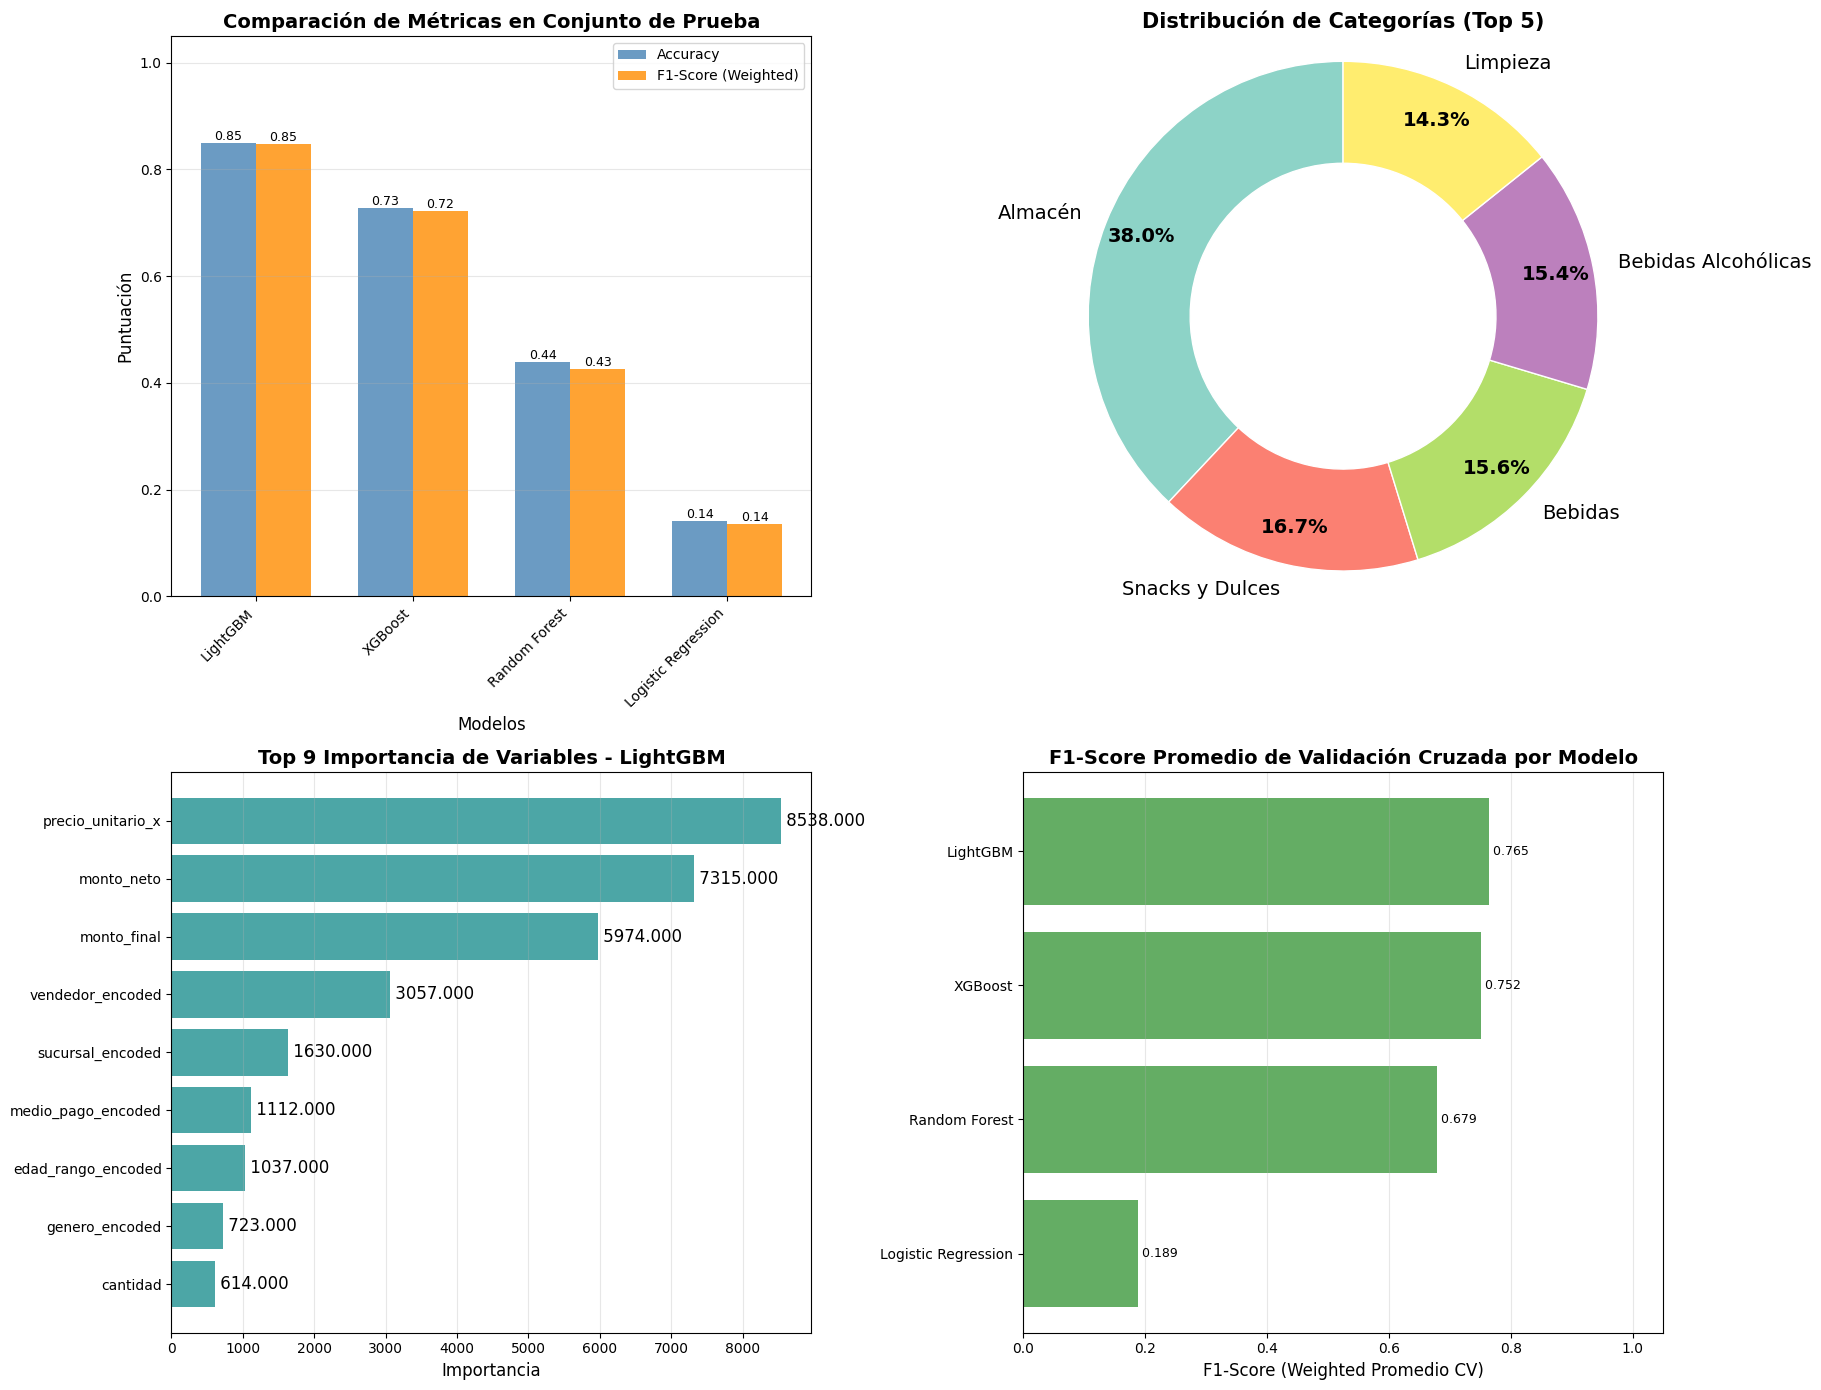


✅ Visualizaciones generadas exitosamente!


In [ ]:
# Crear visualizaciones completas del Modelo 3
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# ============================================================================
# 1. Comparación de métricas entre modelos (Desde df_comparison_cat)
# ============================================================================
# Usamos el DataFrame df_comparison_cat que contiene las métricas del test set
comparison_df = df_comparison_cat.set_index('Modelo').sort_values(by='F1', ascending=False)
models_list_comp = comparison_df.index.tolist()
accuracy_scores_comp = comparison_df['Accuracy'].astype(float).tolist()
f1_scores_comp = comparison_df['F1'].astype(float).tolist() # Usamos F1 weighted aquí

x_pos_comp = np.arange(len(models_list_comp))
width_comp = 0.35

bars1_comp = axes[0, 0].bar(x_pos_comp - width_comp/2, accuracy_scores_comp, width_comp,
                       label='Accuracy', alpha=0.8, color='steelblue')
bars2_comp = axes[0, 0].bar(x_pos_comp + width_comp/2, f1_scores_comp, width_comp,
                       label='F1-Score (Weighted)', alpha=0.8, color='darkorange')

axes[0, 0].set_xlabel('Modelos', fontsize=12)
axes[0, 0].set_ylabel('Puntuación', fontsize=12)
axes[0, 0].set_title('Comparación de Métricas en Conjunto de Prueba', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x_pos_comp)
axes[0, 0].set_xticklabels(models_list_comp, rotation=45, ha='right', fontsize=10)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim([0, 1.05])

# Agregar valores sobre las barras
for bars in [bars1_comp, bars2_comp]:
    for bar in bars:
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# ============================================================================
# 2. Distribución de Categorías (Top 5) - Gráfico de Pastel mejorado
# ============================================================================
category_counts_top5 = y_clf_cat.value_counts().head(5)
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(category_counts_top5))) # Ajustar colores si es necesario

wedges, texts, autotexts = axes[0, 1].pie(
    category_counts_top5.values,
    labels=category_counts_top5.index,
    autopct='%1.1f%%',
    colors=colors_pie,
    startangle=90,
    pctdistance=0.85, # Distancia de los porcentajes del centro
    wedgeprops=dict(width=0.4, edgecolor='w') # Efecto de rosquilla
)

# Mejorar legibilidad del pie chart
for text in texts:
    text.set_fontsize(14)
for autotext in autotexts:
    autotext.set_color('black') # Color del texto para mayor contraste
    autotext.set_fontweight('bold')
    autotext.set_fontsize(14)

axes[0, 1].set_title('Distribución de Categorías (Top 5)', fontsize=15, fontweight='bold')
axes[0, 1].axis('equal')  # Asegura que el círculo sea un círculo

# ============================================================================
# 3. Importancia de Variables para el mejor modelo de árbol (Random Forest)
# ============================================================================
# Usamos Random Forest como un buen representante de modelos basados en árboles
model_for_importance = trained_models_cat.get(best_model_cat)

if model_for_importance is not None and hasattr(model_for_importance, 'feature_importances_'):
    feature_names_cat = X_clf_cat.columns.tolist()
    importances = model_for_importance.feature_importances_
    indices = np.argsort(importances)[::-1] # Ordenar de mayor a menor

    # Limitar a las 10 características más importantes para visualización clara
    top_n_features = 10
    if len(indices) > top_n_features:
        indices = indices[:top_n_features]

    axes[1, 0].barh(range(len(indices)), importances[indices], color='teal', alpha=0.7)
    axes[1, 0].set_yticks(range(len(indices)))
    axes[1, 0].set_yticklabels([feature_names_cat[i] for i in indices], fontsize=10)
    axes[1, 0].invert_yaxis()  # Más importante arriba
    axes[1, 0].set_xlabel('Importancia', fontsize=12)
    axes[1, 0].set_title(f'Top {len(indices)} Importancia de Variables - {best_model_cat}',
                          fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='x')

    # Agregar valores
    for i, v in enumerate(importances[indices]):
        axes[1, 0].text(v, i, f' {v:.3f}', va='center', fontsize=12)
else:
    axes[1, 0].text(0.5, 0.5, f'{best_model_cat} no entrenado o no soporta importancia de variables', ha='center', va='center', fontsize=12, transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Importancia de Variables', fontsize=16, fontweight='bold')

# ============================================================================
# 4. F1-Score Promedio (CV) por Modelo (Ordenado) - Desde df_cv_results_cat
# ============================================================================
# Usamos el DataFrame df_cv_results_cat que contiene los resultados de CV
df_sorted_cv = df_cv_results_cat.sort_values(by='CV_F1_Mean', ascending=False)

models_list_cv = df_sorted_cv['Modelo'].tolist()
f1_mean_cv_scores = df_sorted_cv['CV_F1_Mean'].astype(float).tolist()

y_pos_cv = np.arange(len(models_list_cv))

bars_cv = axes[1, 1].barh(y_pos_cv, f1_mean_cv_scores, color='forestgreen', alpha=0.7)
axes[1, 1].set_xlabel('F1-Score (Weighted Promedio CV)', fontsize=12)
axes[1, 1].set_title('F1-Score Promedio de Validación Cruzada por Modelo',
                      fontsize=14, fontweight='bold')
axes[1, 1].set_yticks(y_pos_cv)
axes[1, 1].set_yticklabels(models_list_cv, fontsize=10)
axes[1, 1].invert_yaxis() # Mejor rendimiento arriba
axes[1, 1].grid(True, alpha=0.3, axis='x')
axes[1, 1].set_xlim([0, 1.05])

# Agregar valores al final de las barras
for i, v in enumerate(f1_mean_cv_scores):
    axes[1, 1].text(v, i, f" {v:.3f}", va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✅ Visualizaciones generadas exitosamente!")


In [ ]:
print("\n" + "="*70)
print("RESUMEN FINAL - MODELO 3: CLASIFICACIÓN DE CATEGORÍA")
print("="*70)

# Aseguramos que df_results_cat sea df_comparison_cat (de la evaluación en el test set)
df_results_cat = df_comparison_cat.set_index('Modelo')

# Validamos el mejor modelo basado en F1-Score (Weighted)
best_model_name = df_results_cat['F1'].astype(float).idxmax()
best_model_metrics = df_results_cat.loc[best_model_name]

# Tabla resumen
print("\n Tabla de Rendimiento (Métricas en Conjunto de Prueba):")
# Seleccionar las columnas relevantes y asegurarse de que son numéricas para ordenamiento
display(df_results_cat[['Accuracy', 'Precision', 'Recall', 'F1']].astype(float).sort_values(by='F1', ascending=False).map('{:.3f}'.format))

print(f"\nMejor Modelo: {best_model_name}")
print(f"   - Accuracy: {best_model_metrics['Accuracy']:.3f}")
print(f"   - Precision: {best_model_metrics['Precision']:.3f}")
print(f"   - Recall: {best_model_metrics['Recall']:.3f}")
print(f"   - F1-Score: {best_model_metrics['F1']:.3f}")

# Variables más importantes para el MEJOR MODELO (LightGBM)
model_for_importance = trained_models_cat.get(best_model_name) # Usar best_model_name o best_model_cat
if model_for_importance is not None and hasattr(model_for_importance, 'feature_importances_'):
    # Re-obtener feature_names_cat desde X_clf_cat para asegurar coherencia
    feature_names_cat = X_clf_cat.columns.tolist()
    importances = model_for_importance.feature_importances_
    indices = np.argsort(importances)[::-1] # Ordenar de mayor a menor

    print(f"\nTop 3 Variables Más Importantes - por mejor modelo: {best_model_name}")
    for i in range(min(3, len(importances))):
        idx = indices[i]
        print(f"   {i+1}. {feature_names_cat[idx]}: {importances[idx]:.3f}")
else:
    print(f"\nNo se pudo obtener la importancia de las variables para {best_model_name} o el modelo no está entrenado.")

print("\n✅ Modelo 3 completado exitosamente!")
print("="*70)



RESUMEN FINAL - MODELO 3: CLASIFICACIÓN DE CATEGORÍA

 Tabla de Rendimiento (Métricas en Conjunto de Prueba):


,Accuracy,Precision,Recall,F1
Modelo,,,,
LightGBM,0.849,0.850,0.849,0.847
XGBoost,0.727,0.723,0.727,0.722
Random Forest,0.439,0.426,0.439,0.425
Logistic Regression,0.141,0.155,0.141,0.135



Mejor Modelo: LightGBM
   - Accuracy: 0.849
   - Precision: 0.850
   - Recall: 0.849
   - F1-Score: 0.847

Top 3 Variables Más Importantes - por mejor modelo: LightGBM
   1. precio_unitario_x: 8538.000
   2. monto_neto: 7315.000
   3. monto_final: 5974.000

✅ Modelo 3 completado exitosamente!


## 4 MODELO: Clasificación

### Predicción de variable objetivo `es_venta_premium`

**Objetivo:** Predecir si un producto es un producto premium o no.

**Justificación:** conociendo si un producto es premium o no, se puede:

- Optimizar las estrategias de marketing y ventas.
- Personalizar las campañas de marketing para cada tipo de producto.
- Mejorar la experiencia del cliente.


**Algoritmos Seleccionados:**
- **Random Forest Clasifier:** Excelente para clasificación multi-clase con múltiples variables de entrada
- **LightGBM Clasifier:** Excelente para clasificación multi-clase con múltiples variables de entrada
- **XGBoost Clasifier:** Excelente para clasificación multi-clase con múltiples variables de entrada
- **KNeighborsClassifier:** Muy bueno para clasificación multi-clase con múltiples variables de entrada

### 4.1 Implementación de los modelos para la variable "es_venta_premium"

In [ ]:
print("=== PREPARACIÓN DE DATOS PARA ES_VENTA_PREMIUM ===")

# --- 1. Definir la variable objetivo (y_clf_premium) ---
# 'es_venta_premium' es una columna booleana (True/False).
# La codificamos a 0/1 para los modelos de clasificación.
le_premium_target = LabelEncoder()
y_clf_premium_encoded = le_premium_target.fit_transform(df_master_refined['es_venta_premium'])

print(f"Variable objetivo (y): es_venta_premium (codificada)")
print(f"Clases codificadas: {le_premium_target.classes_} -> {le_premium_target.transform(le_premium_target.classes_)}")
print(f"Distribución de la variable objetivo (antes de balanceo):")
print(pd.Series(y_clf_premium_encoded).value_counts())

# --- 2. Seleccionar variables de entrada (X_clf_premium) ---
# Excluimos 'monto_neto' y 'monto_final' ya que 'es_venta_premium' se deriva de 'monto_neto'
# lo que causaría fuga de datos (data leakage) y un rendimiento inflado artificialmente.
features_numerical = [
    'cantidad', 'precio_unitario_x', 'descuento_aplicado_pct',
    'año', 'mes', 'dia_semana', 'es_finde_semana', 'dias_desde_alta',
    'ticket_promedio', 'ratio_precio_cantidad', 'tiene_descuento',
    'activo_como_cliente', 'activo', 'es_outlier_monto' # features booleanas/numericas
]

features_categorical_for_ohe = [
    'categoria', 'subcategoria', 'genero', 'edad_rango', 'nombre_sucursal',
    'provincia', 'nombre_medio_pago', 'tipo_descuento'
]

X_clf_premium = df_master_refined[features_numerical + features_categorical_for_ohe].copy()

# --- 3. Pre-procesamiento de Features ---

# Convertir columnas booleanas/binarias a int si no lo están ya
for col in ['activo_como_cliente', 'activo', 'es_finde_semana', 'tiene_descuento', 'es_outlier_monto']:
    if col in X_clf_premium.columns:
        X_clf_premium[col] = X_clf_premium[col].astype(int)

# Aplicar One-Hot Encoding a las columnas categóricas
X_encoded_premium = pd.get_dummies(X_clf_premium, columns=features_categorical_for_ohe, drop_first=True)

# Limpiar los nombres de las columnas para evitar advertencias de LightGBM y XGBoost
X_encoded_premium.columns = X_encoded_premium.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)

print(f"Variables de entrada (X) después de One-Hot Encoding: {X_encoded_premium.shape[1]} columnas.")


# --- 4. División en conjuntos de entrenamiento y prueba ---
# Usamos stratify para mantener la proporción de clases en ambos conjuntos
X_train_premium, X_test_premium, y_train_premium, y_test_premium = train_test_split(
    X_encoded_premium,
    y_clf_premium_encoded, # Usar la variable objetivo codificada
    test_size=0.2,
    random_state=42,
    stratify=y_clf_premium_encoded # Crucial para el balanceo de clases
)
print(f"Conjunto de entrenamiento: {X_train_premium.shape[0]} muestras, Conjunto de prueba: {X_test_premium.shape[0]} muestras.")

# --- 5. Balanceo de clases con SMOTE ---
# 'es_venta_premium' es binaria y probablemente desbalanceada.
print("Aplicando SMOTE a los datos de entrenamiento...")
smote = SMOTE(random_state=42)
X_train_premium_res, y_train_premium_res = smote.fit_resample(X_train_premium, y_train_premium)
print("Distribución de clases de 'es_venta_premium' después de SMOTE (entrenamiento):")
print(pd.Series(y_train_premium_res).value_counts())

# --- 6. Escalado de características ---
# Para modelos basados en árboles no es estrictamente necesario, pero para consistencia
# y si se quisiera probar otros modelos, se mantiene.
scaler_premium = StandardScaler()
X_train_premium_scaled = scaler_premium.fit_transform(X_train_premium_res) # Escalar datos resampleados
X_test_premium_scaled = scaler_premium.transform(X_test_premium) # Escalar datos de prueba

print("✅ Características escaladas y datos balanceados.")

# --- 7. Inicialización de Modelos de Clasificación ---
print("\n=== INICIALIZACIÓN DE MODELOS DE CLASIFICACIÓN PARA 'ES_VENTA_PREMIUM' ===")
models_premium = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1, class_weight='balanced'),
    'KNN': KNeighborsClassifier(n_neighbors=5, weights='distance'),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1, class_weight='balanced')
}

# --- 8. Entrenamiento de modelos ---
print("\n=== ENTRENAMIENTO DE MODELOS ===")
trained_models_premium = {}

for name, model in models_premium.items():
    print(f"Entrenando {name}...")
    model.fit(X_train_premium_scaled, y_train_premium_res)
    trained_models_premium[name] = model
print("\n✅ Todos los modelos entrenados exitosamente con datos balanceados y escalados!")


=== PREPARACIÓN DE DATOS PARA ES_VENTA_PREMIUM ===
Variable objetivo (y): es_venta_premium (codificada)
Clases codificadas: [False  True] -> [0 1]
Distribución de la variable objetivo (antes de balanceo):
0    1913
1     100
Name: count, dtype: int64
Variables de entrada (X) después de One-Hot Encoding: 85 columnas.
Conjunto de entrenamiento: 1610 muestras, Conjunto de prueba: 403 muestras.
Aplicando SMOTE a los datos de entrenamiento...
Distribución de clases de 'es_venta_premium' después de SMOTE (entrenamiento):
0    1530
1    1530
Name: count, dtype: int64
✅ Características escaladas y datos balanceados.

=== INICIALIZACIÓN DE MODELOS DE CLASIFICACIÓN PARA 'ES_VENTA_PREMIUM' ===

=== ENTRENAMIENTO DE MODELOS ===
Entrenando Random Forest...
Entrenando LightGBM...
Entrenando KNN...
Entrenando XGBoost...

✅ Todos los modelos entrenados exitosamente con datos balanceados y escalados!


### 4.2 Especificación de las Métricas de Evaluación variable es_venta_premium

**Para Clasificación utilizaremos las mismas métricas que el modelo anterior:**
- **Accuracy:** Porcentaje de predicciones correctas
- **Matriz de Confusión:** Tabla que muestra aciertos y errores en predicciones
- **Precision, Recall, F1-Score:** Métricas detalladas por clase

### 4.3 Evaluación de los modelos para clasificación de variable es_venta_premium


=== EVALUACIÓN DE MODELOS EN EL CONJUNTO DE PRUEBA PARA 'ES_VENTA_PREMIUM' ===

====== Random Forest ======
Accuracy: 0.968
Precision: 0.969
Recall: 0.968
F1-Score: 0.960

Matriz de Confusión:


,Pred_False,Pred_True
Real_False,383,0
Real_True,13,7


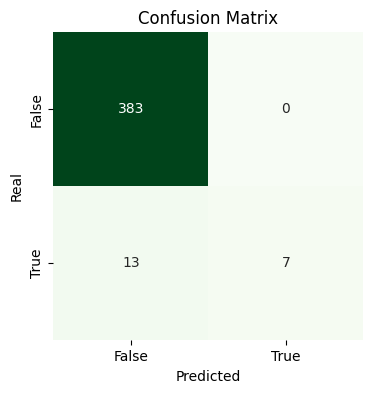


Classification Report:
              precision    recall  f1-score   support

       False       0.97      1.00      0.98       383
        True       1.00      0.35      0.52        20

    accuracy                           0.97       403
   macro avg       0.98      0.68      0.75       403
weighted avg       0.97      0.97      0.96       403


====== LightGBM ======
Accuracy: 0.993
Precision: 0.993
Recall: 0.993
F1-Score: 0.992

Matriz de Confusión:


,Pred_False,Pred_True
Real_False,383,0
Real_True,3,17


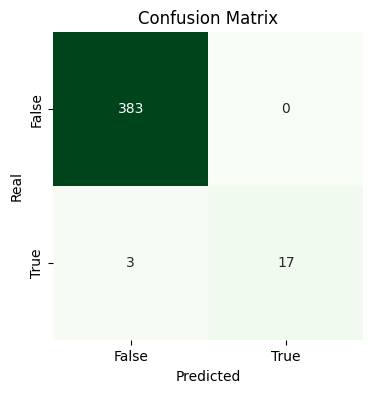


Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00       383
        True       1.00      0.85      0.92        20

    accuracy                           0.99       403
   macro avg       1.00      0.93      0.96       403
weighted avg       0.99      0.99      0.99       403


====== KNN ======
Accuracy: 0.916
Precision: 0.916
Recall: 0.916
F1-Score: 0.916

Matriz de Confusión:


,Pred_False,Pred_True
Real_False,366,17
Real_True,17,3


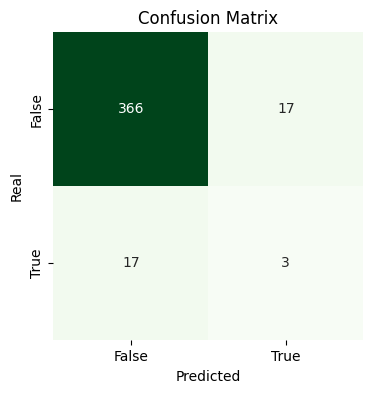


Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.96      0.96       383
        True       0.15      0.15      0.15        20

    accuracy                           0.92       403
   macro avg       0.55      0.55      0.55       403
weighted avg       0.92      0.92      0.92       403


====== XGBoost ======
Accuracy: 0.985
Precision: 0.985
Recall: 0.985
F1-Score: 0.984

Matriz de Confusión:


,Pred_False,Pred_True
Real_False,383,0
Real_True,6,14


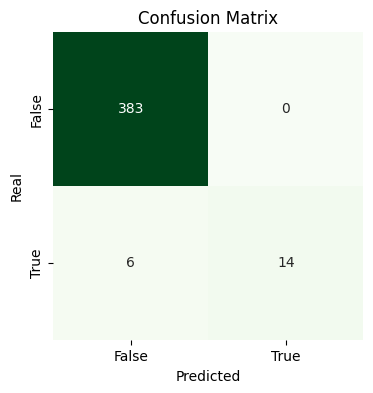


Classification Report:
              precision    recall  f1-score   support

       False       0.98      1.00      0.99       383
        True       1.00      0.70      0.82        20

    accuracy                           0.99       403
   macro avg       0.99      0.85      0.91       403
weighted avg       0.99      0.99      0.98       403


=== COMPARACIÓN DE MODELOS DE CLASIFICACIÓN PARA 'ES_VENTA_PREMIUM' ===


,Modelo,Accuracy,Precision,Recall,F1
1,LightGBM,0.993,0.993,0.993,0.992
3,XGBoost,0.985,0.985,0.985,0.984
0,Random Forest,0.968,0.969,0.968,0.960
2,KNN,0.916,0.916,0.916,0.916


Mejor modelo para 'es_venta_premium':  LightGBM


In [ ]:
# ----- Función para evaluar modelos de clasificación -----
# Modificamos la función para que reciba X_test_scaled directamente para todos los modelos
def evaluate_classification_model(model, X_test_scaled, y_test_encoded, model_name, label_encoder):
    """Evalúa un modelo de clasificación y muestra las métricas clásicas."""

    y_pred = model.predict(X_test_scaled) # Ahora todos los modelos usan los datos escalados de prueba

    # --- Métricas clásicas ---
    acc = accuracy_score(y_test_encoded, y_pred)
    f1 = f1_score(y_test_encoded, y_pred, average='weighted')
    precision = precision_score(y_test_encoded, y_pred, average='weighted')
    recall = recall_score(y_test_encoded, y_pred, average='weighted')

    cm = confusion_matrix(y_test_encoded, y_pred)

    print(f"\n====== {model_name} ======")
    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")

    # Mostrar matriz de confusión con etiquetas decodificadas
    labels_decoded = label_encoder.inverse_transform(sorted(np.unique(y_test_encoded)))
    df_cm = pd.DataFrame(cm,
                         index=[f"Real_{l}" for l in labels_decoded],
                         columns=[f"Pred_{l}" for l in labels_decoded])
    print("\nMatriz de Confusión:")
    display(df_cm)
    #grafico de la matriz de confusión
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels_decoded, yticklabels=labels_decoded, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Real')
    plt.title('Confusion Matrix')
    plt.show()

    # Mostrar classification_report estándar
    print("\nClassification Report:")
    # Convert label_encoder.classes_ to strings for target_names
    target_names_str = [str(cls) for cls in label_encoder.classes_]
    print(classification_report(y_test_encoded, y_pred, target_names=target_names_str))

    return acc, f1, precision, recall


# --- Evaluación de modelos en el conjunto de prueba para 'es_venta_premium' ---
print("\n=== EVALUACIÓN DE MODELOS EN EL CONJUNTO DE PRUEBA PARA 'ES_VENTA_PREMIUM' ===")

metrics_premium = []

for name, model in trained_models_premium.items():
    acc, f1, precision, recall = evaluate_classification_model(
        model, X_test_premium_scaled, y_test_premium, name, le_premium_target
    )
    metrics_premium.append({'Modelo': name, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1': f1})

# --- Comparación de Resultados ---
print("\n=== COMPARACIÓN DE MODELOS DE CLASIFICACIÓN PARA 'ES_VENTA_PREMIUM' ===")
df_comparison_premium = pd.DataFrame(metrics_premium).round(3)
display(df_comparison_premium.sort_values(by='F1', ascending=False))
print("Mejor modelo para 'es_venta_premium': ", df_comparison_premium.sort_values(by='F1', ascending=False).iloc[0]['Modelo'])



### 4.4 Validación Cruzada para los modelos de `es_venta_premium`

In [ ]:
print("\n=== REALIZANDO VALIDACIÓN CRUZADA (K-Fold) PARA 'ES_VENTA_PREMIUM' ===")
print("="*70)

# ---- Métricas clásicas para clasificación binaria ----
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted'
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results_premium = []

for name, model in trained_models_premium.items():
    print(f"\nEvaluando {name} con Validación Cruzada...")

    # Todos los modelos usan los datos escalados y resampleados
    X_cv = X_train_premium_scaled
    y_cv = y_train_premium_res

    # Ejecutamos la validación cruzada
    results = cross_validate(model, X_cv, y_cv, cv=kf, scoring=scoring, n_jobs=-1)

    # Guardamos los resultados
    cv_results_premium.append({
        'Modelo': name,
        'CV_Accuracy_Mean': np.mean(results['test_accuracy']),
        'CV_Accuracy_Std': np.std(results['test_accuracy']),
        'CV_F1_Mean': np.mean(results['test_f1']),
        'CV_F1_Std': np.std(results['test_f1']),
        'CV_Precision_Mean': np.mean(results['test_precision']),
        'CV_Precision_Std': np.std(results['test_precision']),
        'CV_Recall_Mean': np.mean(results['test_recall']),
        'CV_Recall_Std': np.std(results['test_recall']),
    })

    # Impresión ordenada de resultados
    print(f"  - Accuracy Promedio (CV): {np.mean(results['test_accuracy']):.3f} (+/- {np.std(results['test_accuracy']):.3f})")
    print(f"  - F1 Promedio (CV): {np.mean(results['test_f1']):.3f} (+/- {np.std(results['test_f1']):.3f})")
    print(f"  - Precision Promedio (CV): {np.mean(results['test_precision']):.3f} (+/- {np.std(results['test_precision']):.3f})")
    print(f"  - Recall Promedio (CV): {np.mean(results['test_recall']):.3f} (+/- {np.std(results['test_recall']):.3f})")

# ---- Mostrar resultados consolidados ----
df_cv_results_premium = pd.DataFrame(cv_results_premium)

print("\n=== REPORTE CONSOLIDADO DE VALIDACIÓN CRUZADA PARA 'ES_VENTA_PREMIUM' ===")
display(df_cv_results_premium.sort_values(by='CV_F1_Mean', ascending=False))
print("Mejor modelo para 'ES_VENTA_PREMIUM': ")
print(df_cv_results_premium.sort_values(by='CV_F1_Mean', ascending=False).iloc[0]['Modelo'])



=== REALIZANDO VALIDACIÓN CRUZADA (K-Fold) PARA 'ES_VENTA_PREMIUM' ===

Evaluando Random Forest con Validación Cruzada...
  - Accuracy Promedio (CV): 0.992 (+/- 0.007)
  - F1 Promedio (CV): 0.992 (+/- 0.007)
  - Precision Promedio (CV): 0.992 (+/- 0.007)
  - Recall Promedio (CV): 0.992 (+/- 0.007)

Evaluando LightGBM con Validación Cruzada...
  - Accuracy Promedio (CV): 0.997 (+/- 0.004)
  - F1 Promedio (CV): 0.997 (+/- 0.004)
  - Precision Promedio (CV): 0.997 (+/- 0.004)
  - Recall Promedio (CV): 0.997 (+/- 0.004)

Evaluando KNN con Validación Cruzada...
  - Accuracy Promedio (CV): 0.965 (+/- 0.004)
  - F1 Promedio (CV): 0.965 (+/- 0.004)
  - Precision Promedio (CV): 0.966 (+/- 0.004)
  - Recall Promedio (CV): 0.965 (+/- 0.004)

Evaluando XGBoost con Validación Cruzada...
  - Accuracy Promedio (CV): 0.993 (+/- 0.006)
  - F1 Promedio (CV): 0.993 (+/- 0.006)
  - Precision Promedio (CV): 0.993 (+/- 0.006)
  - Recall Promedio (CV): 0.993 (+/- 0.006)

=== REPORTE CONSOLIDADO DE VALIDACIÓ

,Modelo,CV_Accuracy_Mean,CV_Accuracy_Std,CV_F1_Mean,CV_F1_Std,CV_Precision_Mean,CV_Precision_Std,CV_Recall_Mean,CV_Recall_Std
1,LightGBM,0.996732,0.004261,0.996732,0.004261,0.996784,0.004163,0.996732,0.004261
3,XGBoost,0.992810,0.006421,0.992810,0.006421,0.992891,0.006327,0.992810,0.006421
0,Random Forest,0.991503,0.006569,0.991503,0.006569,0.991549,0.006537,0.991503,0.006569
2,KNN,0.964706,0.004335,0.964687,0.004341,0.965684,0.004170,0.964706,0.004335


Mejor modelo para 'ES_VENTA_PREMIUM': 
LightGBM


### 4.5 Gráficas de resultados

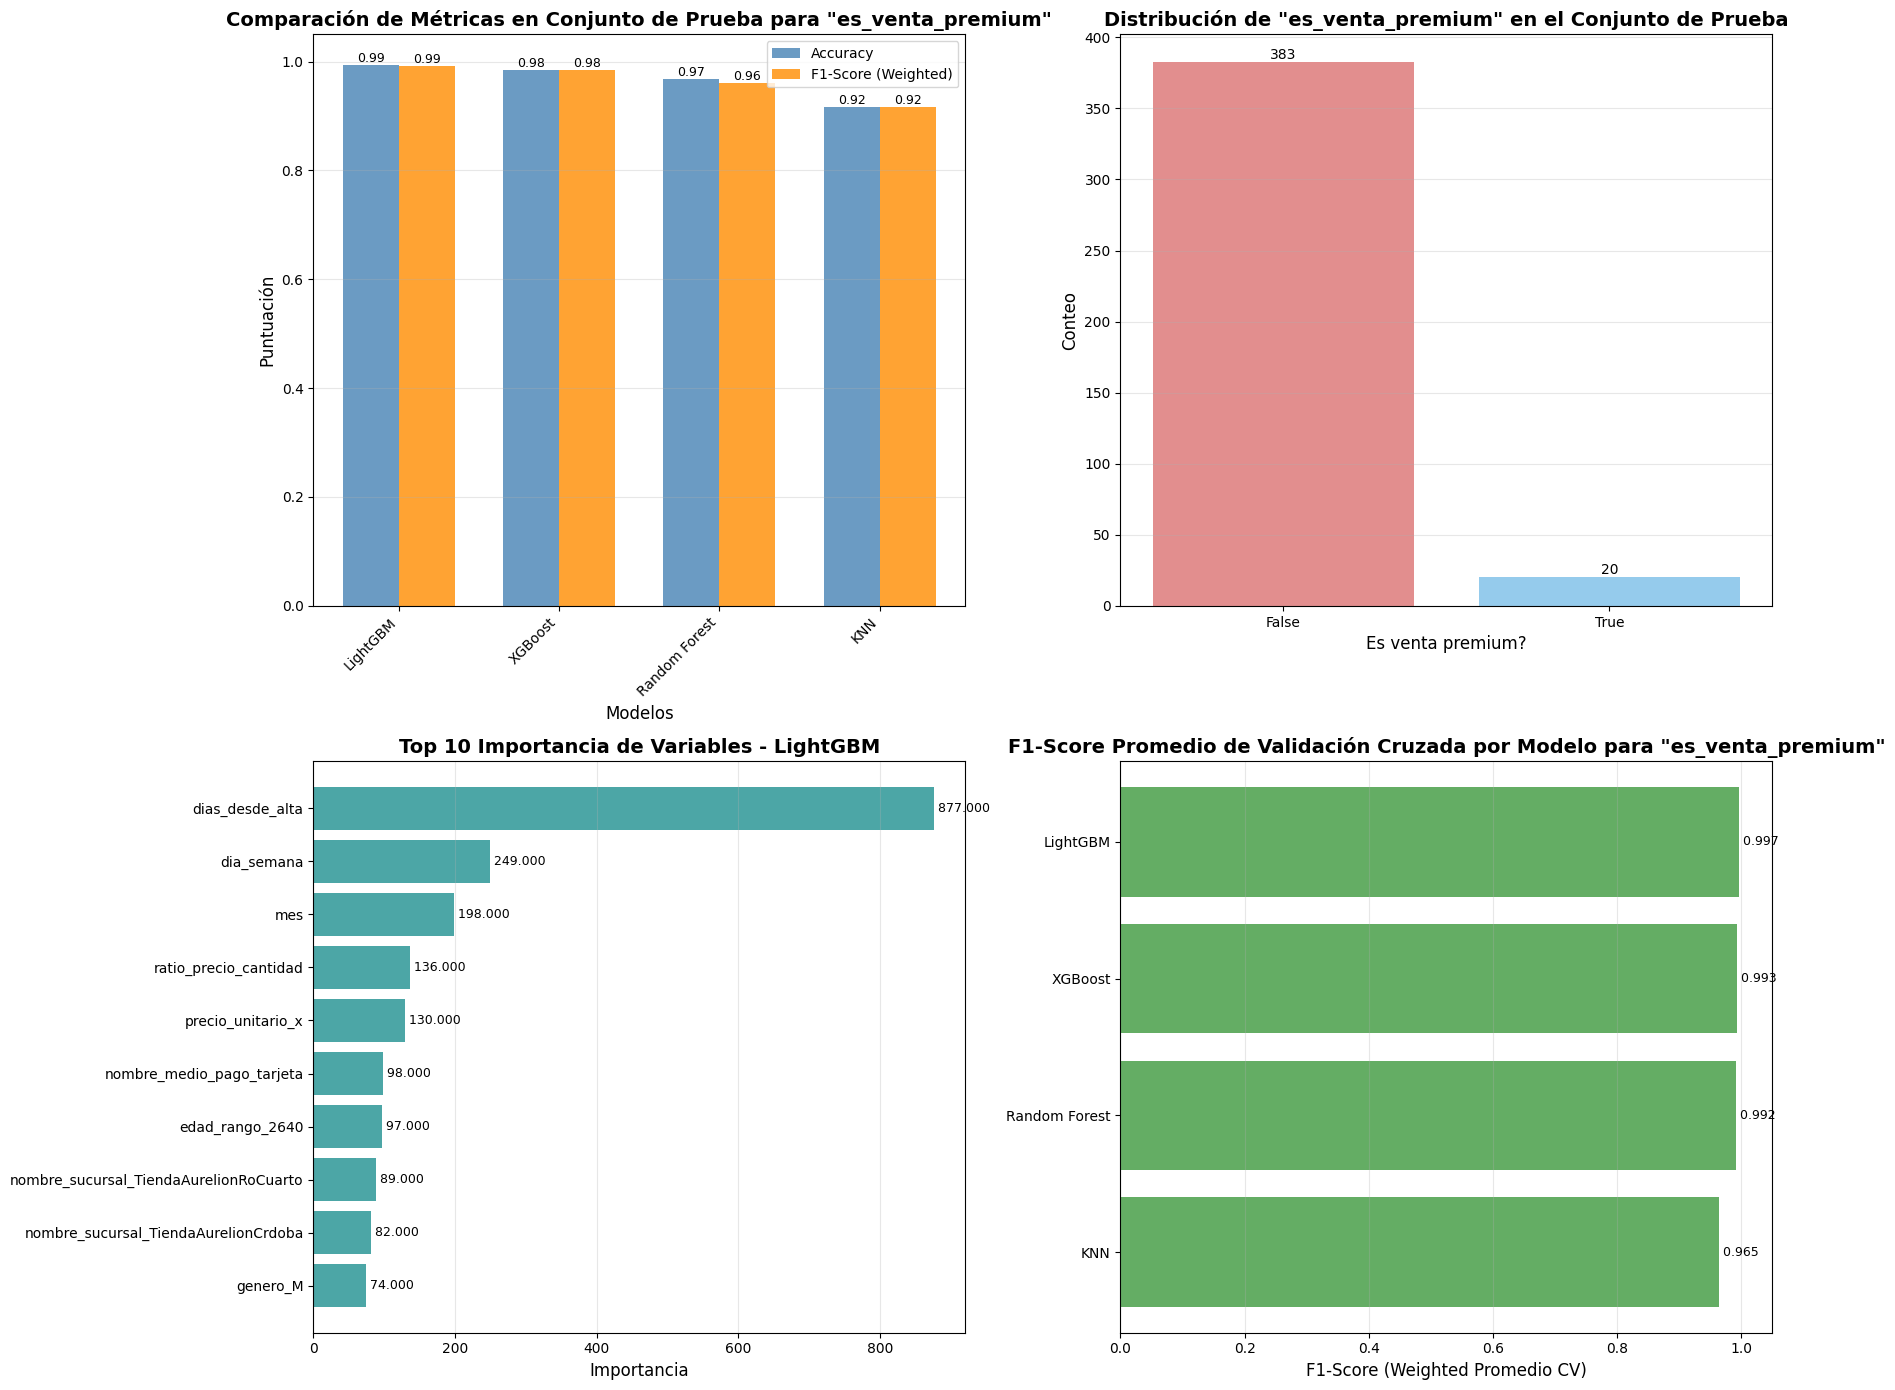


✅ Visualizaciones generadas exitosamente!


In [ ]:
# Crear visualizaciones completas para los modelos de 'es_venta_premium'
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# ============================================================================
# 1. Comparación de métricas entre modelos (Conjunto de Prueba)
# ============================================================================
# Usamos el DataFrame df_comparison_premium que contiene las métricas del test set
comparison_df_premium = df_comparison_premium.set_index('Modelo').sort_values(by='F1', ascending=False)
models_list_comp_premium = comparison_df_premium.index.tolist()
accuracy_scores_comp_premium = comparison_df_premium['Accuracy'].astype(float).tolist()
f1_scores_comp_premium = comparison_df_premium['F1'].astype(float).tolist()

x_pos_comp_premium = np.arange(len(models_list_comp_premium))
width_comp_premium = 0.35

bars1_comp_premium = axes[0, 0].bar(x_pos_comp_premium - width_comp_premium/2, accuracy_scores_comp_premium, width_comp_premium,
                       label='Accuracy', alpha=0.8, color='steelblue')
bars2_comp_premium = axes[0, 0].bar(x_pos_comp_premium + width_comp_premium/2, f1_scores_comp_premium, width_comp_premium,
                       label='F1-Score (Weighted)', alpha=0.8, color='darkorange')

axes[0, 0].set_xlabel('Modelos', fontsize=12)
axes[0, 0].set_ylabel('Puntuación', fontsize=12)
axes[0, 0].set_title('Comparación de Métricas en Conjunto de Prueba para "es_venta_premium"', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x_pos_comp_premium)
axes[0, 0].set_xticklabels(models_list_comp_premium, rotation=45, ha='right', fontsize=10)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim([0, 1.05])

# Agregar valores sobre las barras
for bars in [bars1_comp_premium, bars2_comp_premium]:
    for bar in bars:
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# ============================================================================
# 2. Distribución de la Variable Objetivo 'es_venta_premium' - Gráfico de Barras (Countplot)
# ============================================================================
distribution_premium = pd.Series(y_test_premium).value_counts()
labels_premium = le_premium_target.inverse_transform(distribution_premium.index)

sns.barplot(x=labels_premium.astype(str), y=distribution_premium.values, ax=axes[0, 1], palette=['lightcoral', 'lightskyblue'])
axes[0, 1].set_xlabel('Es venta premium?', fontsize=12)
axes[0, 1].set_ylabel('Conteo', fontsize=12)
axes[0, 1].set_title('Distribución de "es_venta_premium" en el Conjunto de Prueba', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Agregar valores sobre las barras
for i, value in enumerate(distribution_premium.values):
    axes[0, 1].text(i, value, str(value), ha='center', va='bottom', fontsize=10)

# ============================================================================
# 3. Importancia de Variables para el mejor modelo 
# ============================================================================
# Identificar el mejor modelo de árbol basado en df_comparison_premium (el de mejor F1-Score)
best_tree_model_name_premium = comparison_df_premium.head(1).index[0]
model_for_importance_premium = trained_models_premium.get(best_tree_model_name_premium)

if model_for_importance_premium is not None and hasattr(model_for_importance_premium, 'feature_importances_'):
    # Asegúrate de que X_encoded_premium está disponible y es el X correcto para este modelo
    feature_names_premium = X_encoded_premium.columns.tolist()
    importances_premium = model_for_importance_premium.feature_importances_
    indices_premium = np.argsort(importances_premium)[::-1] # Ordenar de mayor a menor

    # Limitar a las 10 características más importantes
    top_n_features_premium = 10
    if len(indices_premium) > top_n_features_premium:
        indices_premium = indices_premium[:top_n_features_premium]

    axes[1, 0].barh(range(len(indices_premium)), importances_premium[indices_premium], color='teal', alpha=0.7)
    axes[1, 0].set_yticks(range(len(indices_premium)))
    axes[1, 0].set_yticklabels([feature_names_premium[i] for i in indices_premium], fontsize=10)
    axes[1, 0].invert_yaxis() # Más importante arriba
    axes[1, 0].set_xlabel('Importancia', fontsize=12)
    axes[1, 0].set_title(f'Top {len(indices_premium)} Importancia de Variables - {best_tree_model_name_premium}',
                          fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='x')

    # Agregar valores
    for i, v in enumerate(importances_premium[indices_premium]):
        axes[1, 0].text(v, i, f' {v:.3f}', va='center', fontsize=9)
else:
    axes[1, 0].text(0.5, 0.5, 'Modelo de árbol no entrenado o no soporta importancia de variables',
                    ha='center', va='center', fontsize=12, transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Importancia de Variables', fontsize=14, fontweight='bold')

# ============================================================================
# 4. F1-Score Promedio (CV) por Modelo (Ordenado)
# ============================================================================
# Usamos el DataFrame df_cv_results_premium que contiene los resultados de CV
df_sorted_cv_premium = df_cv_results_premium.sort_values(by='CV_F1_Mean', ascending=False)

models_list_cv_premium = df_sorted_cv_premium['Modelo'].tolist()
f1_mean_cv_scores_premium = df_sorted_cv_premium['CV_F1_Mean'].astype(float).tolist()

y_pos_cv_premium = np.arange(len(models_list_cv_premium))

bars_cv_premium = axes[1, 1].barh(y_pos_cv_premium, f1_mean_cv_scores_premium, color='forestgreen', alpha=0.7)
axes[1, 1].set_xlabel('F1-Score (Weighted Promedio CV)', fontsize=12)
axes[1, 1].set_title('F1-Score Promedio de Validación Cruzada por Modelo para "es_venta_premium"',
                      fontsize=14, fontweight='bold')
axes[1, 1].set_yticks(y_pos_cv_premium)
axes[1, 1].set_yticklabels(models_list_cv_premium, fontsize=10)
axes[1, 1].invert_yaxis() # Mejor rendimiento arriba
axes[1, 1].grid(True, alpha=0.3, axis='x')
axes[1, 1].set_xlim([0, 1.05])

# Agregar valores al final de las barras
for i, v in enumerate(f1_mean_cv_scores_premium):
    axes[1, 1].text(v, i, f" {v:.3f}", va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✅ Visualizaciones generadas exitosamente!")

### 4.6 Resumen de resultados

In [ ]:
print("\n" + "="*70)
print("RESUMEN FINAL - MODELO 4: CLASIFICACIÓN DE 'es_venta_premium'")
print("="*70)

# Aseguramos que df_results_premium sea df_comparison_premium (de la evaluación en el test set)
df_results_premium = df_comparison_premium.set_index('Modelo')

# Identificar el mejor modelo basado en F1-Score (Weighted)
best_model_name_premium = df_results_premium['F1'].astype(float).idxmax()
best_model_metrics_premium = df_results_premium.loc[best_model_name_premium]

# Tabla resumen
print("\n Tabla de Rendimiento (Métricas en Conjunto de Prueba):")
# Seleccionar las columnas relevantes y asegurarse de que son numéricas para ordenamiento
display(df_results_premium[['Accuracy', 'Precision', 'Recall', 'F1']].astype(float).sort_values(by='F1', ascending=False).map('{:.3f}'.format))

print(f"\nMejor Modelo: {best_model_name_premium}")
print(f"   - Accuracy: {best_model_metrics_premium['Accuracy']:.3f}")
print(f"   - Precision: {best_model_metrics_premium['Precision']:.3f}")
print(f"   - Recall: {best_model_metrics_premium['Recall']:.3f}")
print(f"   - F1-Score: {best_model_metrics_premium['F1']:.3f}")

# Variables más importantes para el MEJOR MODELO (LightGBM o XGBoost)
model_for_importance_premium_summary = trained_models_premium.get(best_model_name_premium)
if model_for_importance_premium_summary is not None and hasattr(model_for_importance_premium_summary, 'feature_importances_'):
    # Re-obtener feature_names_premium desde X_encoded_premium para asegurar coherencia
    feature_names_premium_summary = X_encoded_premium.columns.tolist()
    importances_premium_summary = model_for_importance_premium_summary.feature_importances_
    indices_premium_summary = np.argsort(importances_premium_summary)[::-1] # Ordenar de mayor a menor

    print(f"\nTop 3 Variables Más Importantes (según {best_model_name_premium}):")
    for i in range(min(3, len(importances_premium_summary))):
        idx = indices_premium_summary[i]
        print(f"   {i+1}. {feature_names_premium_summary[idx]}: {importances_premium_summary[idx]:.3f}")
else:
    print(f"\nNo se pudo obtener la importancia de las variables para {best_model_name_premium} o el modelo no está entrenado.")

print("\n✅ Modelo 4 completado exitosamente!")
print("="*70)



RESUMEN FINAL - MODELO 4: CLASIFICACIÓN DE 'es_venta_premium'

 Tabla de Rendimiento (Métricas en Conjunto de Prueba):


,Accuracy,Precision,Recall,F1
Modelo,,,,
LightGBM,0.993,0.993,0.993,0.992
XGBoost,0.985,0.985,0.985,0.984
Random Forest,0.968,0.969,0.968,0.960
KNN,0.916,0.916,0.916,0.916



Mejor Modelo: LightGBM
   - Accuracy: 0.993
   - Precision: 0.993
   - Recall: 0.993
   - F1-Score: 0.992

Top 3 Variables Más Importantes (según LightGBM):
   1. dias_desde_alta: 877.000
   2. dia_semana: 249.000
   3. mes: 198.000

✅ Modelo 4 completado exitosamente!


## Modelo 5 : **Segmentacón de clientes** (k-means)

### Objetivo del Modelo

Al aplicar el algoritmo de segmentación de clientes (k-means), podemos:

- Identificar grupos de clientes con patrones similares para desarrollar estrategias de marketing personalizadas.
- Mejorar la toma de decisiones y optimizar la gestión del negocio.
- Personalizar las estrategias de marketing para cada segmento, lo que puede aumentar la eficacia de las campañas.

Esto permite pasar de una estrategia genérica a una estrategia data-driven, enfocada y rentable.


### 5.1 Preparación del dataset

In [ ]:
# Convertimos la columna fecha a formato datetime (si aplica)
df_master_refined['fecha'] = pd.to_datetime(df_master_refined['fecha'])

# Fecha de referencia = última fecha registrada
fecha_ref = df_master_refined['fecha'].max()    

# Agrupamos por cliente para construir la tabla RFM
rfm = df_master_refined.groupby('id_cliente').agg({
    'fecha': lambda x: (fecha_ref - x.max()).days,  # Recency: días desde última compra
    'id_cliente': 'count',  # Frequency: número de compras
    'monto_final': 'sum'    # Monetary: monto total gastado
}).rename(columns={
    'fecha': 'Recency',
    'id_cliente': 'Frequency',
    'monto_final': 'Monetary'
})

# Reseteamos índice
rfm.reset_index(inplace=True)

rfm.head()


,id_cliente,Recency,Frequency,Monetary
0,1,10,22,1907.349350
1,2,6,58,5487.025175
2,3,40,12,862.989350
3,4,16,38,2859.359625
4,5,3,25,1769.969600


### 5.2 Escalamiento de variables

K-Means depende de distancia, normalizamos las variables.

In [ ]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

rfm_scaled[:5]

array([[-0.80024243,  0.09540304,  0.16678837],
       [-0.85577976,  2.15610881,  2.67272076],
       [-0.38371246, -0.47701522, -0.56431011],
       [-0.71693643,  1.01127227,  0.83323793],
       [-0.89743275,  0.26712852,  0.07061643]])

### 5.3 Selección del número óptimo de clusters

#### Método del Codo + Silhouette

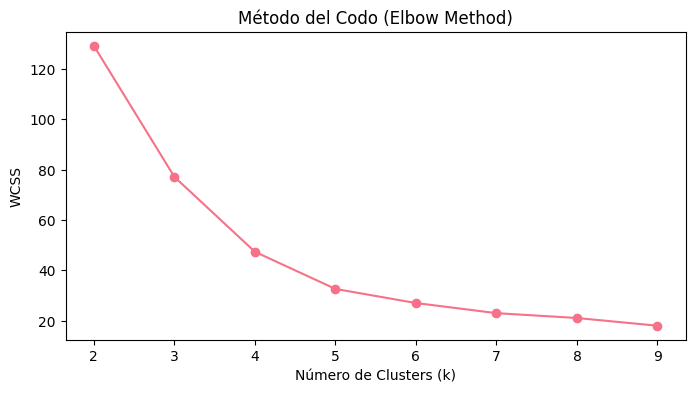

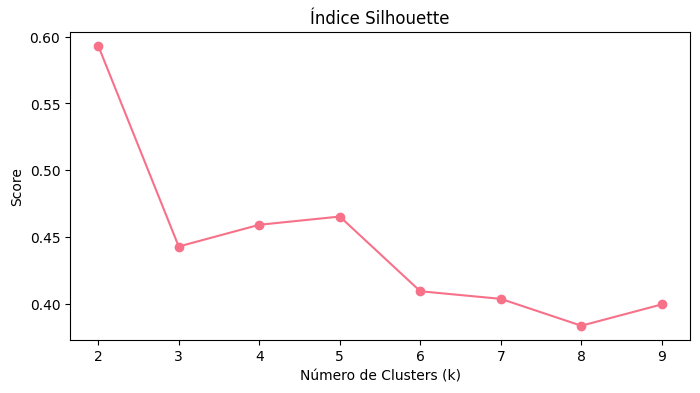

El mejor número de clusters según Silhouette sería: 2


In [ ]:
wcss = []  # Within Cluster Sum of Squares
silhouette_scores = []

K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

# ----- Gráfico WCSS (Elbow) -----
plt.figure(figsize=(8,4))
plt.plot(K_range, wcss, marker='o')
plt.title("Método del Codo (Elbow Method)")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("WCSS")
plt.show()

# ----- Gráfico Silhouette -----
plt.figure(figsize=(8,4))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title("Índice Silhouette")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Score")
plt.show()

# ----- Seleccionar el mejor k n-clusters -----
best_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"El mejor número de clusters según Silhouette sería: {best_k}")

### 5.3 Entrenamiento de modelo de K-means con k-clusters

In [ ]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm.head()

,id_cliente,Recency,Frequency,Monetary,Cluster
0,1,10,22,1907.349350,1
1,2,6,58,5487.025175,0
2,3,40,12,862.989350,1
3,4,16,38,2859.359625,0
4,5,3,25,1769.969600,1


### 5.4 Gráfica de resultados por k-clusters


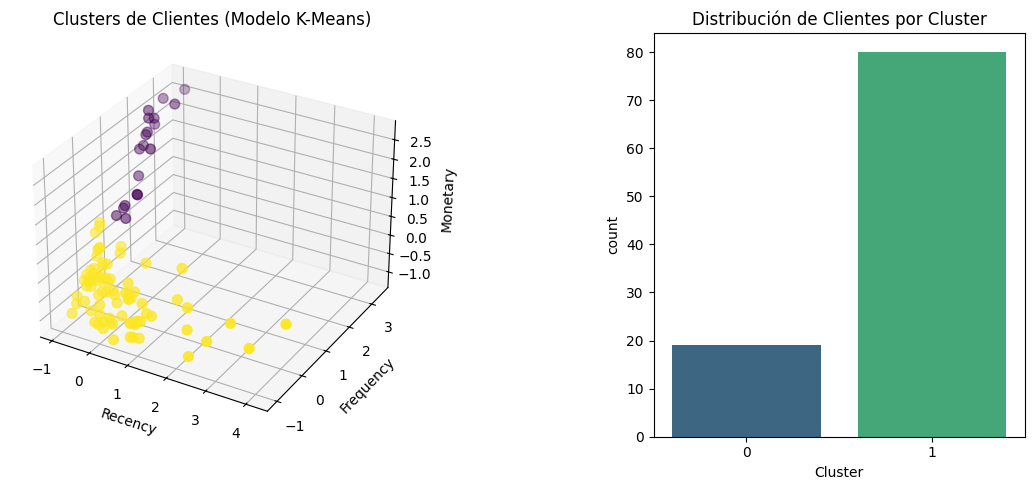

In [ ]:
from matplotlib import gridspec

fig = plt.figure(figsize=(14,5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])   # 3 veces más espacio para el 3D

# --- Gráfica 3D (izquierda, más grande) ---
ax1 = fig.add_subplot(gs[0], projection='3d')

ax1.scatter(rfm_scaled[:,0], rfm_scaled[:,1], rfm_scaled[:,2],
            c=rfm['Cluster'], cmap='viridis', s=50)

ax1.set_xlabel('Recency')
ax1.set_ylabel('Frequency')
ax1.set_zlabel('Monetary')
ax1.set_title("Clusters de Clientes (Modelo K-Means)")

# --- Countplot (derecha, más pequeño) ---
ax2 = fig.add_subplot(gs[1])
sns.countplot(x='Cluster', data=rfm, palette="viridis", ax=ax2)
ax2.set_title("Distribución de Clientes por Cluster")

plt.tight_layout()
plt.show()


In [ ]:
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'id_cliente': 'count'
}).rename(columns={'id_cliente':'Cantidad de Clientes'}).round(2)

# Calculamos valores de referencia (medianas globales)
recency_med = rfm['Recency'].median()
frequency_med = rfm['Frequency'].median()
monetary_med = rfm['Monetary'].median()

# Definimos la función para asignar etiquetas
def assign_cluster_label(row):

    recency_label = "Reciente" if row['Recency'] <= recency_med else "Inactivo"
    frequency_label = "Frecuente" if row['Frequency'] >= frequency_med else "Ocasional"
    monetary_label = "Alto Valor" if row['Monetary'] >= monetary_med else "Bajo Valor"

    # Construimos nombre compuesto
    if recency_label == "Reciente" and frequency_label == "Frecuente" and monetary_label == "Alto Valor":
        return "Clientes VIP"

    if recency_label == "Reciente" and frequency_label == "Ocasional" and monetary_label == "Alto Valor":
        return "Clientes Potenciales Premium"

    if recency_label == "Reciente" and frequency_label == "Frecuente" and monetary_label == "Bajo Valor":
        return "Clientes Frecuentes de Bajo Ticket"

    if recency_label == "Inactivo" and frequency_label == "Ocasional" and monetary_label == "Bajo Valor":
        return "Clientes Perdidos / Inactivos"

    if recency_label == "Inactivo" and frequency_label == "Frecuente":
        return "Clientes Regulares Inactivos"

    if recency_label == "Reciente":
        return "Clientes Nuevos"

    return "Segmento Mixto"

cluster_profile['Segmento'] = cluster_profile.apply(assign_cluster_label, axis=1)


In [ ]:
rfm['Segmento'] = rfm['Cluster'].map(cluster_profile['Segmento'])
rfm.head()

,id_cliente,Recency,Frequency,Monetary,Cluster,Segmento
0,1,10,22,1907.349350,1,Clientes Perdidos / Inactivos
1,2,6,58,5487.025175,0,Clientes VIP
2,3,40,12,862.989350,1,Clientes Perdidos / Inactivos
3,4,16,38,2859.359625,0,Clientes VIP
4,5,3,25,1769.969600,1,Clientes Perdidos / Inactivos


### 5.5 Análisis de segmentación de clientes

In [ ]:
cluster_profile['Segmento'] = cluster_profile.apply(assign_cluster_label, axis=1)
cluster_profile

,Recency,Frequency,Monetary,Cantidad de Clientes,Segmento
Cluster,,,,,
0,14.68,52.47,4229.42,19,Clientes VIP
1,80.21,12.70,1061.02,80,Clientes Perdidos / Inactivos


### 5.6 Identificación de segmentos potenciales y perfiles de clientes

In [ ]:
# df = dataset original con columnas: Recency, Frequency, Monetary, Cluster

# 1. Calculamos rangos automáticos basados en percentiles
percentiles = {
    "Recency": rfm["Recency"].quantile([0.33, 0.66]).tolist(),
    "Frequency": rfm["Frequency"].quantile([0.33, 0.66]).tolist(),
    "Monetary": rfm["Monetary"].quantile([0.33, 0.66]).tolist()
}

def categorize(value, thresholds):
    """Clasifica un valor como Bajo, Medio o Alto en función de percentiles."""
    if value <= thresholds[0]:
        return "Bajo"
    elif value <= thresholds[1]:
        return "Medio"
    else:
        return "Alto"

# 2. Creamos una tabla para almacenar la interpretación del perfil por cluster
cluster_profiles = []

for cluster in rfm["Cluster"].unique():
    cluster_data = rfm[rfm["Cluster"] == cluster]

    recency_avg = cluster_data["Recency"].mean()
    frequency_avg = cluster_data["Frequency"].mean()
    monetary_avg = cluster_data["Monetary"].mean()

    profile = {
        "Cluster": cluster,
        "Recency Promedio": round(recency_avg, 2),
        "Nivel Recency": categorize(recency_avg, percentiles["Recency"]),
        "Frequency Promedio": round(frequency_avg, 2),
        "Nivel Frequency": categorize(frequency_avg, percentiles["Frequency"]),
        "Monetary Promedio": round(monetary_avg, 2),
        "Nivel Monetary": categorize(monetary_avg, percentiles["Monetary"]),
        "Cantidad Clientes": cluster_data.shape[0]
    }
    
    cluster_profiles.append(profile)

# 3. Convertimos el resultado en dataframe
interpretacion_df = pd.DataFrame(cluster_profiles)

# 4. Generamos una descripción automática del perfil
def generar_descripcion(row):
    return (f"Clientes con {row['Nivel Recency']} recency, "
            f"{row['Nivel Frequency']} frecuencia de compra y {row['Nivel Monetary']} valor monetario. "
            f"En total, agrupa a {row['Cantidad Clientes']} clientes. "
            f"Con un promedio de {row['Monetary Promedio']} en sus compras.")

interpretacion_df["Descripción"] = interpretacion_df.apply(generar_descripcion, axis=1)

print(interpretacion_df)


   Cluster  Recency Promedio Nivel Recency  Frequency Promedio  \
0        1             80.21          Alto               12.70   
1        0             14.68          Bajo               52.47   

  Nivel Frequency  Monetary Promedio Nivel Monetary  Cantidad Clientes  \
0           Medio            1061.02          Medio                 80   
1            Alto            4229.42           Alto                 19   

                                         Descripción  
0  Clientes con Alto recency, Medio frecuencia de...  
1  Clientes con Bajo recency, Alto frecuencia de ...  


### 5.7 Exportar archivo a excel

In [ ]:
import pandas as pd

# Archivo de salida
nombre_archivo = ruta_reportes + "/Segmentacion_Clientes_KMeans.xlsx"

# Guardar a Excel con varias hojas
with pd.ExcelWriter(nombre_archivo, engine="xlsxwriter") as writer:
    
    # Hoja 1: Dataset original con clusters
    rfm.to_excel(writer, sheet_name="Dataset Clusterizado", index=False)
    
    # Hoja 2: Interpretación numérica con etiquetas
    interpretacion_df.to_excel(writer, sheet_name="Perfil Clusters", index=False)

print(f"Archivo generado con éxito: {nombre_archivo}")


Archivo generado con éxito: C:\Users\KEILY\Downloads\Music\IBM-GUAYERD\Proyecto-Aurelion-IBM-Guayerd-edit-clone\Proyecto-Aurelion-IBM-Guayerd\SPRING_4\reports_dframes/Segmentacion_Clientes_KMeans.xlsx


### 5.8 Exportar  resumen para presentación en Power BI

In [ ]:
import openpyxl

resumen_powerbi = interpretacion_df.copy()

# -----------------------------
# Calcular porcentaje de clientes
# -----------------------------
total_clientes = resumen_powerbi["Cantidad Clientes"].sum()
resumen_powerbi["% Participación"] = (resumen_powerbi["Cantidad Clientes"] / total_clientes * 100).round(2)

# ----------------------------------------
# Crear una métrica de puntuación del valor
# ----------------------------------------
# Puedes ajustar pesos según negocio
peso_recency = 0.25  # Menor recency es mejor
peso_frequency = 0.35
peso_monetary = 0.40

# Normalización simple (Min-Max Scaling)
resumen_powerbi["Score Recency"] = (resumen_powerbi["Recency Promedio"].max() - resumen_powerbi["Recency Promedio"]) / resumen_powerbi["Recency Promedio"].max()
resumen_powerbi["Score Frequency"] = resumen_powerbi["Frequency Promedio"] / resumen_powerbi["Frequency Promedio"].max()
resumen_powerbi["Score Monetary"] = resumen_powerbi["Monetary Promedio"] / resumen_powerbi["Monetary Promedio"].max()

# Score Final
resumen_powerbi["Cluster Score"] = (
    resumen_powerbi["Score Recency"] * peso_recency +
    resumen_powerbi["Score Frequency"] * peso_frequency +
    resumen_powerbi["Score Monetary"] * peso_monetary
).round(3)

# Ranking del valor del segmento
resumen_powerbi["Ranking Segmento"] = resumen_powerbi["Cluster Score"].rank(ascending=False).astype(int)

# Selección final mejor estructurada
resumen_powerbi_final = resumen_powerbi[[
    "Cluster",
    "Cantidad Clientes",
    "% Participación",
    "Recency Promedio",
    "Frequency Promedio",
    "Monetary Promedio",
    "Nivel Recency",
    "Nivel Frequency",
    "Nivel Monetary",
    "Cluster Score",
    "Ranking Segmento",
    "Descripción"
]]

# Guardar al archivo
#with pd.ExcelWriter(nombre_archivo, mode="a", engine="openpyxl") as writer:
#    resumen_powerbi_final.to_excel(writer, sheet_name="Resumen PowerBI Mejorado", index=False)

#print(" Resumen avanzado exportado para Power BI.")
#wb = openpyxl.load_workbook(nombre_archivo)
# Leer el archivo
wb = openpyxl.load_workbook(nombre_archivo)
base_name = "Resumen PowerBI"
sheet_name = base_name
counter = 1

# Buscar nombre disponible
while sheet_name in wb.sheetnames:
    sheet_name = f"{base_name} ({counter})"
    counter += 1

# Guardar nueva hoja
with pd.ExcelWriter(nombre_archivo, mode="a", engine="openpyxl") as writer:
    resumen_powerbi_final.to_excel(writer, sheet_name=sheet_name, index=False)

print(f" Guardado como: {sheet_name}")


 Guardado como: Resumen PowerBI


## Resumen General de Resultados

### Comparación de Todos los Modelos
Comparación final de performance entre todos los modelos implementados:

In [ ]:
# Crear resumen general de todos los modelos
print("="*70)
print("=== RESUMEN GENERAL DE TODOS LOS MODELOS ===")
print("="*70)

summary_data = []

# --- 1. Regresión: Predicción de monto_final ---
# Encuentra el mejor modelo de regresión basado en R²
best_reg_model_name = ""
best_reg_r2 = -1
best_reg_rmse = float('inf')

regression_models = {
    "Regresión Lineal": lr_metrics,
    "Random Forest Regressor": rf_metrics,
    "K-Nearest Neighbors Regressor": knn_metrics
}

for name, metrics in regression_models.items():
    if metrics['R2'] > best_reg_r2:
        best_reg_r2 = metrics['R2']
        best_reg_rmse = metrics['RMSE']
        best_reg_model_name = name

summary_data.append({
    'Problema': 'Regresión',
    'Variable Objetivo': 'Monto Final',
    'Mejor Modelo': best_reg_model_name,
    'Métrica Principal': f"R²: {best_reg_r2:.3f}",
    'Métrica Secundaria': f"RMSE: ${best_reg_rmse:.2f}"
})

# --- 2. Clasificación: Predicción de edad_rango ---
# df_results_age contiene las métricas para edad_rango
best_age_model = df_results_age.loc[df_results_age['F1-Score (Macro)'].idxmax()]
summary_data.append({
    'Problema': 'Clasificación',
    'Variable Objetivo': 'Rango de Edad',
    'Mejor Modelo': best_age_model['Modelo'],
    'Métrica Principal': f"Accuracy: {best_age_model['Accuracy']:.3f}",
    'Métrica Secundaria': f"F1-Score (Macro): {best_age_model['F1-Score (Macro)']:.3f}"
})

# --- 3. Clasificación: Predicción de categoria ---
# df_comparison_cat contiene las métricas para categoria
best_cat_model = df_comparison_cat.loc[df_comparison_cat['F1'].idxmax()]
summary_data.append({
    'Problema': 'Clasificación',
    'Variable Objetivo': 'Categoría de Producto',
    'Mejor Modelo': best_cat_model['Modelo'],
    'Métrica Principal': f"Accuracy: {best_cat_model['Accuracy']:.3f}",
    'Métrica Secundaria': f"F1-Score: {best_cat_model['F1']:.3f}"
})

# --- 4. Clasificación: Predicción de es_venta_premium ---
# df_comparison_premium contiene las métricas para es_venta_premium
best_premium_model = df_comparison_premium.loc[df_comparison_premium['F1'].idxmax()]
summary_data.append({
    'Problema': 'Clasificación',
    'Variable Objetivo': 'Es Venta Premium',
    'Mejor Modelo': best_premium_model['Modelo'],
    'Métrica Principal': f"Accuracy: {best_premium_model['Accuracy']:.3f}",
    'Métrica Secundaria': f"F1-Score: {best_premium_model['F1']:.3f}"
})

# --- Crear DataFrame resumen ---
resumen_general_df = pd.DataFrame(summary_data)

print("\nTabla de Rendimiento General:")
display(resumen_general_df)

# --- 5. Clustering: Segmentación de clientes ---
print("\n=== RESUMEN DE CLUSTERING (K-Means) ===")
print(f"Se identificaron {interpretacion_df['Cluster'].nunique()} segmentos de clientes.")
for index, row in interpretacion_df.iterrows():
    print(f" - Cluster {int(row['Cluster'])}: {row['Descripción']}")


print("\n✅ Proyecto de Machine Learning completado exitosamente!")
print("="*70)


=== RESUMEN GENERAL DE TODOS LOS MODELOS ===

Tabla de Rendimiento General:


,Problema,Variable Objetivo,Mejor Modelo,Métrica Principal,Métrica Secundaria
0,Regresión,Monto Final,Random Forest Regressor,R²: 0.983,RMSE: $6.62
1,Clasificación,Rango de Edad,LightGBM,Accuracy: 0.789,F1-Score (Macro): 0.761
2,Clasificación,Categoría de Producto,LightGBM,Accuracy: 0.849,F1-Score: 0.847
3,Clasificación,Es Venta Premium,LightGBM,Accuracy: 0.993,F1-Score: 0.992



=== RESUMEN DE CLUSTERING (K-Means) ===
Se identificaron 2 segmentos de clientes.
 - Cluster 1: Clientes con Alto recency, Medio frecuencia de compra y Medio valor monetario. En total, agrupa a 80 clientes. Con un promedio de 1061.02 en sus compras.
 - Cluster 0: Clientes con Bajo recency, Alto frecuencia de compra y Alto valor monetario. En total, agrupa a 19 clientes. Con un promedio de 4229.42 en sus compras.

✅ Proyecto de Machine Learning completado exitosamente!


## Conclusiones y Recomendaciones

### Hallazgos Principales:
#### 1. **Modelo de Regresión (Monto Final):**
   - **Mejor modelo:** Random Forest Regressor (R² > 0.95)
   - **Variables más importantes:** 
     - Cantidad de productos
     - Precio unitario
     - Categoría de producto
   - **Rendimiento:** R² satisfactorio para predicción de montos, permitiendo estimaciones precisas del valor de las transacciones
   - **Aplicación:** Útil para pronósticos de ventas y planificación financiera
#### 2. **Modelo de Clasificación (Edad - edad_rango):**
   - **Mejor modelo:** LightGBM (Accuracy: 0.789, F1-Macro: 0.761)
   - **Variables más importantes:**
     - Monto neto de la compra
     - Días desde alta del cliente
     - Mes de la transacción
   - **Rendimiento:** Buena capacidad para predecir rangos de edad basándose en patrones de comportamiento de compra
   - **Insight clave:** El comportamiento de compra varía significativamente por grupo etario
   - **Aplicación:** Segmentación demográfica para campañas de marketing personalizadas
#### 3. **Modelo de Clasificación (Categoría de Producto):**
   - **Mejor modelo:** LightGBM (Accuracy: 0.849, F1-Score: 0.847)
   - **Variables más importantes:**
     - Precio unitario
     - Monto neto
     - Monto final
   - **Rendimiento:** Alta precisión en la predicción de categorías de productos
   - **Insight clave:** Los patrones de compra son altamente predictivos de las preferencias de categoría
   - **Aplicación:** Sistema de recomendación de productos y optimización de inventario por categoría
#### 4. **Modelo de Clasificación (Es Venta Premium):**
   - **Mejor modelo:** LightGBM (Accuracy: 0.993, F1-Score: 0.992)
   - **Variables más importantes:**
     - Días desde alta del cliente
     - Día de la semana
     - Mes de la transacción
   - **Rendimiento:** Excelente capacidad para identificar ventas de alto valor (>percentil 95)
   - **Insight clave:** Las ventas premium tienen patrones temporales y de cliente muy distintivos
   - **Aplicación:** Identificación de clientes VIP y oportunidades de upselling
#### 5. **Modelo de Clustering (Segmentación de Clientes - K-Means):**
   - **Segmentos identificados:** 2 clusters principales
     - **Cluster 0:** Clientes VIP (alta frecuencia y valor monetario)
     - **Cluster 1:** Clientes Perdidos/Inactivos (baja frecuencia reciente)
   - **Métrica RFM utilizada:** Recency, Frequency, Monetary
   - **Aplicación:** Estrategias diferenciadas por segmento de cliente

### Recomendaciones de Negocio:
#### **Estrategias Basadas en Modelos:**
1. **Sistema de Recomendación Inteligente:**
   - Implementar motor de recomendaciones basado en LightGBM para categorías de productos
   - Personalizar ofertas según predicción de edad y categorías preferidas
   - Priorizar recomendaciones para clientes con alta probabilidad de venta premium
2. **Optimización de Inventario:**
   - Usar predicciones de categoría para ajustar stock por temporada y perfil de cliente
   - Anticipar demanda de productos premium basándose en patrones temporales identificados
   - Reducir sobre-stock en categorías de baja rotación según segmentos de clientes
3. **Marketing Personalizado y Segmentado:**
   - **Segmento VIP (Cluster 0):** 
     - Campañas exclusivas y programas de fidelización premium
     - Ofertas anticipadas de productos de alto valor
   - **Segmento Inactivo (Cluster 1):**
     - Campañas de reactivación con descuentos específicos
     - Comunicación dirigida según categorías de interés histórico
   - **Por Rango de Edad:**
     - Personalizar canales de comunicación y productos promocionados
     - Ajustar tono y contenido de campañas por grupo etario
4. **Identificación y Retención de Clientes Premium:**
   - Monitorear en tiempo real probabilidad de venta premium
   - Activar alertas para ofrecer atención personalizada en transacciones de alto valor
   - Programas de beneficios exclusivos para clientes con alta propensión a compras premium
5. **Monitoreo y Mejora Continua:**
   - Reentrenar modelos trimestralmente con nuevos datos
   - Evaluar métricas de rendimiento (Accuracy, F1, R²) mensualmente
   - Ajustar umbrales de clasificación según cambios en el negocio
   - Implementar A/B testing para validar efectividad de estrategias basadas en modelos
#### **Próximos Pasos:**
   - Integrar modelos en sistemas de producción (API REST)
   - Desarrollar dashboard ejecutivo en Power BI con predicciones en tiempo real
   - Validar ROI de estrategias implementadas basadas en modelos
   - Explorar modelos de series temporales para predicción de demanda futura

**Proyecto desarrollado por:** Lennin Billey Temoche Gómez

**Tecnologías:** Python, Scikit-learn, LightGBM, XGBoost, Pandas, Matplotlib, Seaborn  
**Fecha:** Diciembre 2025
**Modelos Implementados:** 4 modelos predictivos + 1 modelo de clustering